In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Discrete data + probability
Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise. Normalized meaning to make similar data the same, ex: `?page=`

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

ip                     timestamp  \
0  97.105.19.58  [16/Apr/2019:19:34:42 +0000]   
1  97.105.19.58  [16/Apr/2019:19:34:42 +0000]   
2  97.105.19.58  [16/Apr/2019:19:34:44 +0000]   
3  97.105.19.58  [16/Apr/2019:19:34:46 +0000]   
4  97.105.19.58  [16/Apr/2019:19:34:48 +0000]   

                         request_method  status    size destination  \
0  "GET /api/v1/sales?page=81 HTTP/1.1"     200  512495         NaN   
1          "GET /api/v1/items HTTP/1.1"     200    3561         NaN   
2  "GET /api/v1/sales?page=82 HTTP/1.1"     200  510103         NaN   
3  "GET /api/v1/sales?page=83 HTTP/1.1"     200  510003         NaN   
4  "GET /api/v1/sales?page=84 HTTP/1.1"     200  511963         NaN   

              request_agent  
0  "python-requests/2.21.0"  
1  "python-requests/2.21.0"  
2  "python-requests/2.21.0"  
3  "python-requests/2.21.0"  
4  "python-requests/2.21.0"

In [4]:
df.timestamp.replace(r'(\[|\])', '', regex=True, inplace=True)
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

In [5]:
df = df.set_index('timestamp')

In [6]:
df.head()

ip                        request_method  \
timestamp                                                                 
2019-04-16 19:34:42  97.105.19.58  "GET /api/v1/sales?page=81 HTTP/1.1"   
2019-04-16 19:34:42  97.105.19.58          "GET /api/v1/items HTTP/1.1"   
2019-04-16 19:34:44  97.105.19.58  "GET /api/v1/sales?page=82 HTTP/1.1"   
2019-04-16 19:34:46  97.105.19.58  "GET /api/v1/sales?page=83 HTTP/1.1"   
2019-04-16 19:34:48  97.105.19.58  "GET /api/v1/sales?page=84 HTTP/1.1"   

                     status    size destination             request_agent  
timestamp                                                                  
2019-04-16 19:34:42     200  512495         NaN  "python-requests/2.21.0"  
2019-04-16 19:34:42     200    3561         NaN  "python-requests/2.21.0"  
2019-04-16 19:34:44     200  510103         NaN  "python-requests/2.21.0"  
2019-04-16 19:34:46     200  510003         NaN  "python-requests/2.21.0"  
2019-04-16 19:34:48     200  511963         NaN  "python-requests/2.21.0"

In [7]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [8]:
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

ip              request_method  status    size  \
timestamp                                                                       
2019-04-16 19:34:42  97.105.19.58  GET /api/v1/sales HTTP/1.1     200  512495   
2019-04-16 19:34:42  97.105.19.58  GET /api/v1/items HTTP/1.1     200    3561   
2019-04-16 19:34:44  97.105.19.58  GET /api/v1/sales HTTP/1.1     200  510103   
2019-04-16 19:34:46  97.105.19.58  GET /api/v1/sales HTTP/1.1     200  510003   
2019-04-16 19:34:48  97.105.19.58  GET /api/v1/sales HTTP/1.1     200  511963   

                    destination           request_agent  
timestamp                                                
2019-04-16 19:34:42         NaN  python-requests/2.21.0  
2019-04-16 19:34:42         NaN  python-requests/2.21.0  
2019-04-16 19:34:44         NaN  python-requests/2.21.0  
2019-04-16 19:34:46         NaN  python-requests/2.21.0  
2019-04-16 19:34:48         NaN  python-requests/2.21.0

In [9]:
df['size_mb'] = [n/1024/1024 for n in df['size']]
df.describe()

status          size       size_mb
count  13978.000000  1.397800e+04  13978.000000
mean     200.356703  4.500019e+05      0.429155
std       10.182001  1.614915e+05      0.154010
min      200.000000  0.000000e+00      0.000000
25%      200.000000  5.006370e+05      0.477445
50%      200.000000  5.101380e+05      0.486506
75%      200.000000  5.112910e+05      0.487605
max      499.000000  2.056327e+06      1.961066

In [10]:
df.head()

ip              request_method  status    size  \
timestamp                                                                       
2019-04-16 19:34:42  97.105.19.58  GET /api/v1/sales HTTP/1.1     200  512495   
2019-04-16 19:34:42  97.105.19.58  GET /api/v1/items HTTP/1.1     200    3561   
2019-04-16 19:34:44  97.105.19.58  GET /api/v1/sales HTTP/1.1     200  510103   
2019-04-16 19:34:46  97.105.19.58  GET /api/v1/sales HTTP/1.1     200  510003   
2019-04-16 19:34:48  97.105.19.58  GET /api/v1/sales HTTP/1.1     200  511963   

                    destination           request_agent   size_mb  
timestamp                                                          
2019-04-16 19:34:42         NaN  python-requests/2.21.0  0.488753  
2019-04-16 19:34:42         NaN  python-requests/2.21.0  0.003396  
2019-04-16 19:34:44         NaN  python-requests/2.21.0  0.486472  
2019-04-16 19:34:46         NaN  python-requests/2.21.0  0.486377  
2019-04-16 19:34:48         NaN  python-requests/2.21.0  0.488246

In [11]:
vcounts = pd.DataFrame(df.request_method.value_counts().\
                       reset_index()).\
          rename(columns={'index':'request_method', 'request_method':'value_counts'})

probs = pd.DataFrame(df.request_method.value_counts()/len(df.request_method)).\
        reset_index().\
        rename(columns={'index':'request_method', 'request_method':'probability'})

In [12]:
vcounts

request_method  value_counts
0                     GET /api/v1/sales HTTP/1.1         12403
1                     GET /api/v1/items HTTP/1.1          1065
2                    GET /api/v1/stores HTTP/1.1           229
3                                 GET / HTTP/1.1           107
4                    GET /documentation HTTP/1.1           100
5                      GET /favicon.ico HTTP/1.1            26
6             GET /api/v1//api/v1/items HTTP/1.1            11
7        GET /api/v1/items/api/v1/items HTTP/1.1             7
8           GET /api/v1/items/next_page HTTP/1.1             5
9                          GET /api/v1/ HTTP/1.1             4
10                    GET /api/v1/sales/HTTP/1.1             3
11                    GET /api/v1/store HTTP/1.1             3
12                   GET /api/v1/sales/ HTTP/1.1             3
13               GET /api/v1/itemsitems HTTP/1.1             3
14                     GET /api/v1items HTTP/1.1             2
15        GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1             1
16              GET /api/v1/helloclass! HTTP/1.1             1
17                          GET /api/v1 HTTP/1.1             1
18             GET /api/v1/items&page=0 HTTP/1.1             1
19                    GET /api/v1/items/HTTP/1.1             1
20  GET /api/v1//api/v1/items/next_page HTTP/1.1             1
21                  GET /api/V1/HiZach! HTTP/1.1             1

In [13]:
probs

request_method  probability
0                     GET /api/v1/sales HTTP/1.1     0.887323
1                     GET /api/v1/items HTTP/1.1     0.076191
2                    GET /api/v1/stores HTTP/1.1     0.016383
3                                 GET / HTTP/1.1     0.007655
4                    GET /documentation HTTP/1.1     0.007154
5                      GET /favicon.ico HTTP/1.1     0.001860
6             GET /api/v1//api/v1/items HTTP/1.1     0.000787
7        GET /api/v1/items/api/v1/items HTTP/1.1     0.000501
8           GET /api/v1/items/next_page HTTP/1.1     0.000358
9                          GET /api/v1/ HTTP/1.1     0.000286
10                    GET /api/v1/sales/HTTP/1.1     0.000215
11                    GET /api/v1/store HTTP/1.1     0.000215
12                   GET /api/v1/sales/ HTTP/1.1     0.000215
13               GET /api/v1/itemsitems HTTP/1.1     0.000215
14                     GET /api/v1items HTTP/1.1     0.000143
15        GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1     0.000072
16              GET /api/v1/helloclass! HTTP/1.1     0.000072
17                          GET /api/v1 HTTP/1.1     0.000072
18             GET /api/v1/items&page=0 HTTP/1.1     0.000072
19                    GET /api/v1/items/HTTP/1.1     0.000072
20  GET /api/v1//api/v1/items/next_page HTTP/1.1     0.000072
21                  GET /api/V1/HiZach! HTTP/1.1     0.000072

In [14]:
request_method_prob = pd.merge(vcounts, probs)

In [15]:
request_method_prob[request_method_prob.probability < 0.01]

request_method  value_counts  probability
3                                 GET / HTTP/1.1           107     0.007655
4                    GET /documentation HTTP/1.1           100     0.007154
5                      GET /favicon.ico HTTP/1.1            26     0.001860
6             GET /api/v1//api/v1/items HTTP/1.1            11     0.000787
7        GET /api/v1/items/api/v1/items HTTP/1.1             7     0.000501
8           GET /api/v1/items/next_page HTTP/1.1             5     0.000358
9                          GET /api/v1/ HTTP/1.1             4     0.000286
10                    GET /api/v1/sales/HTTP/1.1             3     0.000215
11                    GET /api/v1/store HTTP/1.1             3     0.000215
12                   GET /api/v1/sales/ HTTP/1.1             3     0.000215
13               GET /api/v1/itemsitems HTTP/1.1             3     0.000215
14                     GET /api/v1items HTTP/1.1             2     0.000143
15        GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1             1     0.000072
16              GET /api/v1/helloclass! HTTP/1.1             1     0.000072
17                          GET /api/v1 HTTP/1.1             1     0.000072
18             GET /api/v1/items&page=0 HTTP/1.1             1     0.000072
19                    GET /api/v1/items/HTTP/1.1             1     0.000072
20  GET /api/v1//api/v1/items/next_page HTTP/1.1             1     0.000072
21                  GET /api/V1/HiZach! HTTP/1.1             1     0.000072

22


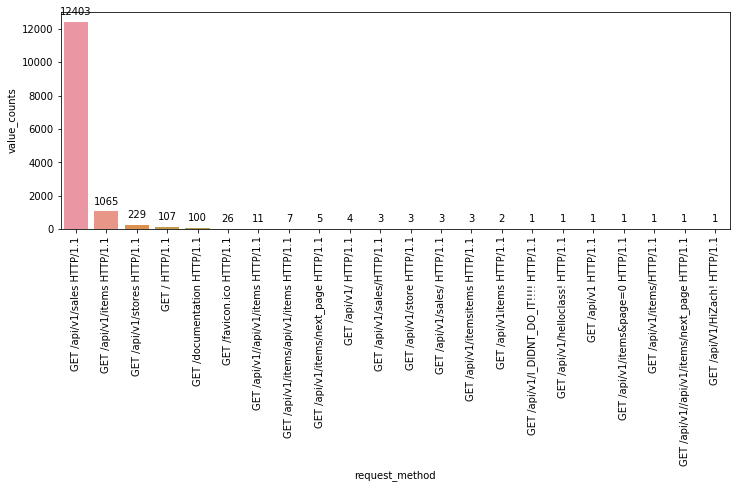

In [16]:
print(len(request_method_prob))

# print(request_method_prob.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=request_method_prob, x = 'request_method', y = 'value_counts', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

In [17]:
train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]

In [18]:
train_prob = pd.DataFrame(train.request_method.value_counts()/len(train.request_method)).\
    reset_index().\
    rename(columns={'index':'request_method', 'request_method':'request_prob'})

In [19]:
df.reset_index().merge(train_prob, on=['request_method'], how='left').\
fillna(value=0).set_index('timestamp').request_prob.value_counts()

0.887577    12403
0.076213     1065
0.016388      229
0.007657      107
0.007156      100
0.001861       26
0.000787       11
0.000215        9
0.000501        7
0.000072        6
0.000358        5
0.000286        4
0.000000        4
0.000143        2
Name: request_prob, dtype: int64

### Conditional Probability

# Time series Anomaly Detection - EMA

In [20]:
df = pd.read_csv('anonymized-curriculum-access.txt', header=None)
df.head()

0
0             2018-01-26 09:55:03 / 1 8 97.105.19.61
1       2018-01-26 09:56:02 java-ii 1 8 97.105.19.61
2  2018-01-26 09:56:05 java-ii/object-oriented-pr...
3  2018-01-26 09:56:06 slides/object_oriented_pro...
4  2018-01-26 09:56:24 javascript-i/conditionals ...

In [21]:
df = df[0].str.split(' ')
df.head()

0        [2018-01-26, 09:55:03, /, 1, 8, 97.105.19.61]
1    [2018-01-26, 09:56:02, java-ii, 1, 8, 97.105.1...
2    [2018-01-26, 09:56:05, java-ii/object-oriented...
3    [2018-01-26, 09:56:06, slides/object_oriented_...
4    [2018-01-26, 09:56:24, javascript-i/conditiona...
Name: 0, dtype: object

In [22]:
df = pd.DataFrame(df).rename(columns={0:'col'})
df.head()

col
0      [2018-01-26, 09:55:03, /, 1, 8, 97.105.19.61]
1  [2018-01-26, 09:56:02, java-ii, 1, 8, 97.105.1...
2  [2018-01-26, 09:56:05, java-ii/object-oriented...
3  [2018-01-26, 09:56:06, slides/object_oriented_...
4  [2018-01-26, 09:56:24, javascript-i/conditiona...

In [23]:
date = []
for row in df.col:
    date.append(row[0])
    
time = []
for row in df.col:
    time.append(row[1])
    
page = []
for row in df.col:
    page.append(row[2])
    
student_id = []
for row in df.col:
    student_id.append(row[3])
    
cohort = []
for row in df.col:
    cohort.append(row[4])
    
ip = []
for row in df.col:
    ip.append(row[5])

In [24]:
df['date'] = date
df['time'] = time
df['page'] = page
df['individual_id'] = student_id
df['cohort'] = cohort
df['ip'] = ip

In [25]:
df.drop(columns='col', inplace=True)
df.head()

date      time                                 page individual_id  \
0  2018-01-26  09:55:03                                    /             1   
1  2018-01-26  09:56:02                              java-ii             1   
2  2018-01-26  09:56:05  java-ii/object-oriented-programming             1   
3  2018-01-26  09:56:06   slides/object_oriented_programming             1   
4  2018-01-26  09:56:24            javascript-i/conditionals             2   

  cohort            ip  
0      8  97.105.19.61  
1      8  97.105.19.61  
2      8  97.105.19.61  
3      8  97.105.19.61  
4     22  97.105.19.61

### Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.


In [26]:
df.cohort.value_counts()

24     34485
22     28268
23     26655
25     24681
26     24088
29     20471
27     19255
       14322
1       8821
14      6523
21      6465
28      6163
31      2997
13      2163
17      1805
8       1671
18      1482
19       901
16       740
15       632
7        338
12       230
nan      136
2         89
11        79
6         59
9          5
4          4
Name: cohort, dtype: int64

In [27]:
df.loc[df.cohort == '', 'cohort'] = 0

In [28]:
df.cohort.value_counts()

24     34485
22     28268
23     26655
25     24681
26     24088
29     20471
27     19255
0      14322
1       8821
14      6523
21      6465
28      6163
31      2997
13      2163
17      1805
8       1671
18      1482
19       901
16       740
15       632
7        338
12       230
nan      136
2         89
11        79
6         59
9          5
4          4
Name: cohort, dtype: int64

In [29]:
df.loc[df.cohort == 'nan', 'cohort'] = 0

In [30]:
df.cohort.value_counts()

24    34485
22    28268
23    26655
25    24681
26    24088
29    20471
27    19255
0     14458
1      8821
14     6523
21     6465
28     6163
31     2997
13     2163
17     1805
8      1671
18     1482
19      901
16      740
15      632
7       338
12      230
2        89
11       79
6        59
9         5
4         4
Name: cohort, dtype: int64

In [31]:
df.head()

date      time                                 page individual_id  \
0  2018-01-26  09:55:03                                    /             1   
1  2018-01-26  09:56:02                              java-ii             1   
2  2018-01-26  09:56:05  java-ii/object-oriented-programming             1   
3  2018-01-26  09:56:06   slides/object_oriented_programming             1   
4  2018-01-26  09:56:24            javascript-i/conditionals             2   

  cohort            ip  
0      8  97.105.19.61  
1      8  97.105.19.61  
2      8  97.105.19.61  
3      8  97.105.19.61  
4     22  97.105.19.61

In [32]:
first_days = df.groupby('individual_id')['date'].min().reset_index().rename(columns={'date':'first_day'})

In [33]:
first_days.head()

individual_id   first_day
0             1  2018-01-26
1            10  2018-01-26
2           100  2018-02-13
3           101  2018-02-15
4           102  2018-02-15

In [34]:
df = first_days.merge(df, on='individual_id')
df.head()

individual_id   first_day        date      time  \
0             1  2018-01-26  2018-01-26  09:55:03   
1             1  2018-01-26  2018-01-26  09:56:02   
2             1  2018-01-26  2018-01-26  09:56:05   
3             1  2018-01-26  2018-01-26  09:56:06   
4             1  2018-01-26  2018-01-26  10:40:15   

                                  page cohort            ip  
0                                    /      8  97.105.19.61  
1                              java-ii      8  97.105.19.61  
2  java-ii/object-oriented-programming      8  97.105.19.61  
3   slides/object_oriented_programming      8  97.105.19.61  
4               javascript-i/functions      8  97.105.19.61

In [35]:
df['days_gone'] = pd.to_datetime(df.date) - pd.to_datetime(df.first_day)

In [36]:
df.sample(10, random_state=123)

individual_id   first_day        date      time  \
8486             110  2018-02-28  2018-03-05  19:20:26   
225972            68  2018-01-30  2018-02-16  11:25:16   
218235             6  2018-01-26  2018-02-12  16:22:13   
54447            189  2018-05-29  2018-08-14  11:00:10   
4850              11  2018-01-26  2018-04-25  15:59:40   
191314           355  2019-02-04  2019-02-21  11:16:18   
219328             6  2018-01-26  2019-03-18  22:11:09   
196290           367  2019-02-06  2019-02-15  16:50:50   
196216           367  2019-02-06  2019-02-11  08:37:30   
49559            186  2018-05-29  2018-07-27  09:04:07   

                                               page cohort             ip  \
8486                                 java-i/methods     21  107.204.132.6   
225972  content/php_ii/control-structures-i/if.html     13  216.1.153.162   
218235                   jquery/events/mouse-events     22   97.105.19.61   
54447                        mysql/clauses/order-by     24   97.105.19.58   
4850                                         spring      1   97.105.19.61   
191314                                  3.5.1-where      0   97.105.19.58   
219328                        html-css/introduction     22  24.99.149.248   
196290                                            /      0   97.105.19.58   
196216                     2.00.00_Excel_Prob_Stats      0   97.105.19.58   
49559                   java-i/introduction-to-java     24   97.105.19.58   

       days_gone  
8486      5 days  
225972   17 days  
218235   17 days  
54447    77 days  
4850     89 days  
191314   17 days  
219328  416 days  
196290    9 days  
196216    5 days  
49559    59 days

In [37]:
df['post_graduation'] = df.days_gone > (pd.to_datetime('2019-06-14') - pd.to_datetime('2019-02-06'))

In [38]:
df.head()

individual_id   first_day        date      time  \
0             1  2018-01-26  2018-01-26  09:55:03   
1             1  2018-01-26  2018-01-26  09:56:02   
2             1  2018-01-26  2018-01-26  09:56:05   
3             1  2018-01-26  2018-01-26  09:56:06   
4             1  2018-01-26  2018-01-26  10:40:15   

                                  page cohort            ip days_gone  \
0                                    /      8  97.105.19.61    0 days   
1                              java-ii      8  97.105.19.61    0 days   
2  java-ii/object-oriented-programming      8  97.105.19.61    0 days   
3   slides/object_oriented_programming      8  97.105.19.61    0 days   
4               javascript-i/functions      8  97.105.19.61    0 days   

   post_graduation  
0            False  
1            False  
2            False  
3            False  
4            False

In [39]:
df = df[df.post_graduation == True]

In [40]:
df['days_gone_string'] = df.days_gone.astype('str')
df.days_gone = df.days_gone_string.str.replace('days 00:00:00.000000000', '').astype('int')

In [41]:
df['weeks_gone'] = round(df.days_gone/7)

In [42]:
df['months_gone'] = round(df.days_gone/30)

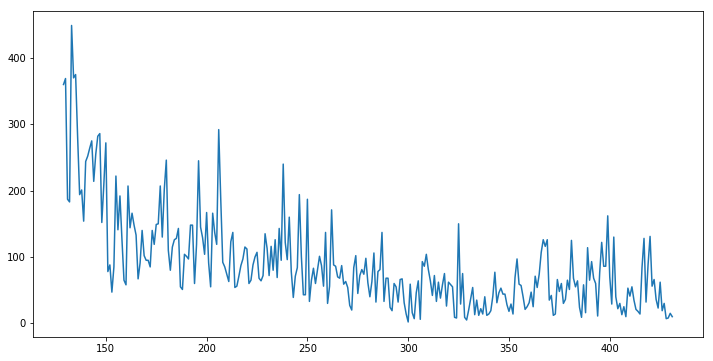

In [43]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df.days_gone.value_counts())

In [44]:
days_gone_df = pd.DataFrame(df.days_gone.value_counts()/len(df.days_gone)).\
    reset_index().\
    rename(columns={'index':'days_gone', 'days_gone':'dg_probs'})

In [45]:
weeks_gone_df = pd.DataFrame(df.weeks_gone.value_counts()/len(df.weeks_gone)).\
                reset_index().\
                rename(columns={'index':'weeks_gone', 'weeks_gone':'wg_probs'})

months_gone_df = pd.DataFrame(df.months_gone.value_counts()/len(df.months_gone)).\
                reset_index().\
                rename(columns={'index':'months_gone', 'months_gone':'mg_probs'})

In [46]:
months_gone_df

months_gone  mg_probs
0           5.0  0.195494
1           6.0  0.137753
2           7.0  0.122304
3           8.0  0.112053
4           4.0  0.084547
5           9.0  0.078094
6          13.0  0.069872
7          10.0  0.061576
8          12.0  0.060396
9          14.0  0.040928
10         11.0  0.036982

In [47]:
df = df.merge(days_gone_df).merge(weeks_gone_df).merge(months_gone_df)
df.head()

individual_id   first_day        date      time          page cohort  \
0             1  2018-01-26  2018-06-04  07:47:17             /      8   
1             1  2018-01-26  2018-06-04  07:51:18      java-iii      8   
2             1  2018-01-26  2018-06-04  07:51:19  java-iii/mvc      8   
3             1  2018-01-26  2018-06-04  07:51:20    slides/mvc      8   
4             1  2018-01-26  2018-06-04  07:52:41    slides/mvc      8   

             ip  days_gone  post_graduation             days_gone_string  \
0  97.105.19.61        129             True  129 days 00:00:00.000000000   
1  97.105.19.61        129             True  129 days 00:00:00.000000000   
2  97.105.19.61        129             True  129 days 00:00:00.000000000   
3  97.105.19.61        129             True  129 days 00:00:00.000000000   
4  97.105.19.61        129             True  129 days 00:00:00.000000000   

   weeks_gone  months_gone  dg_probs  wg_probs  mg_probs  
0        18.0          4.0  0.013274  0.013274  0.084547  
1        18.0          4.0  0.013274  0.013274  0.084547  
2        18.0          4.0  0.013274  0.013274  0.084547  
3        18.0          4.0  0.013274  0.013274  0.084547  
4        18.0          4.0  0.013274  0.013274  0.084547

In [48]:
df.days_gone = df.days_gone-126
df.weeks_gone = round(df.days_gone/7)
df.months_gone = round(df.days_gone/30)

In [49]:
df.drop(columns=['days_gone_string', 'post_graduation', 'first_day'], inplace=True)

In [50]:
df = df[df.page != '/']

In [51]:
df.sample(10)

individual_id        date      time  \
6740            265  2019-02-22  11:24:14   
20735            37  2018-11-29  20:27:33   
13688           155  2018-10-26  16:26:25   
1877             61  2018-06-13  09:27:09   
20514            11  2018-11-19  09:01:11   
8037            118  2018-08-22  15:02:10   
18856            11  2018-11-01  10:06:37   
15668           145  2018-11-12  17:38:54   
336              53  2018-06-06  15:32:19   
4557            272  2019-02-09  16:32:36   

                                                    page cohort  \
6740                       jquery/events/keyboard-events     26   
20735          content/php_iv/gitbook/images/favicon.ico     19   
13688                                       spring/setup     22   
1877                    javascript-i/arrays/manipulating      0   
20514  javascript-i/introduction/working-with-data-ty...      1   
8037          content/git/initializing-a-repository.html     13   
18856                              javascript-ii/modules      1   
15668               java-iii/deployment-and-dependencies     23   
336                   examples/bootstrap-grid/assets.zip     14   
4557                              javascript-ii/ajax-api     26   

                    ip  days_gone  weeks_gone  months_gone  dg_probs  \
6740   173.173.101.207         32         5.0          1.0  0.004646   
20735  173.174.207.225        181        26.0          6.0  0.003429   
13688    45.31.212.143         87        12.0          3.0  0.005051   
1877      97.105.19.61          9         1.0          0.0  0.013827   
20514     97.105.19.58        171        24.0          6.0  0.002470   
8037     72.181.105.69         44         6.0          1.0  0.003503   
18856     97.105.19.58        153        22.0          5.0  0.003613   
15668    76.185.182.91        112        16.0          4.0  0.008849   
336       97.105.19.61          3         0.0          0.0  0.013274   
4557       24.243.8.81         19         3.0          1.0  0.009402   

       wg_probs  mg_probs  
6740   0.033701  0.195494  
20735  0.018362  0.061576  
13688  0.028096  0.122304  
1877   0.081634  0.084547  
20514  0.011910  0.061576  
8037   0.026658  0.137753  
18856  0.019284  0.078094  
15668  0.034106  0.112053  
336    0.013274  0.084547  
4557   0.061576  0.195494

### consider reducing noise of pages

In [52]:
page_df = pd.DataFrame(df.page.value_counts()/len(df.page)).reset_index().rename(columns={'index':'page', 'page':'page_probs'})
page_df.head()

page  page_probs
0         spring    0.035321
1   javascript-i    0.026761
2       java-iii    0.024881
3       html-css    0.019841
4  javascript-ii    0.018961

In [53]:
df = df.merge(page_df)

In [54]:
df.dtypes

individual_id     object
date              object
time              object
page              object
cohort            object
ip                object
days_gone          int64
weeks_gone       float64
months_gone      float64
dg_probs         float64
wg_probs         float64
mg_probs         float64
page_probs       float64
dtype: object

In [55]:
df.date = pd.to_datetime(df.date)

In [56]:
df.set_index('date', inplace=True)
df.head()

individual_id      time      page cohort            ip  days_gone  \
date                                                                           
2018-06-04             1  07:51:18  java-iii      8  97.105.19.61          3   
2018-06-04             1  08:39:22  java-iii      8  97.105.19.61          3   
2018-06-04            11  09:57:42  java-iii      1  97.105.19.61          3   
2018-06-04            11  13:32:17  java-iii      1  97.105.19.61          3   
2018-10-18           211  08:43:43  java-iii      1  97.105.19.58          3   

            weeks_gone  months_gone  dg_probs  wg_probs  mg_probs  page_probs  
date                                                                           
2018-06-04         0.0          0.0  0.013274  0.013274  0.084547    0.024881  
2018-06-04         0.0          0.0  0.013274  0.013274  0.084547    0.024881  
2018-06-04         0.0          0.0  0.013274  0.013274  0.084547    0.024881  
2018-06-04         0.0          0.0  0.013274  0.013274  0.084547    0.024881  
2018-10-18         0.0          0.0  0.013274  0.013274  0.084547    0.024881

### Stopping point
Consider using multi level index to plot each individual's page visits based on days past graduation.

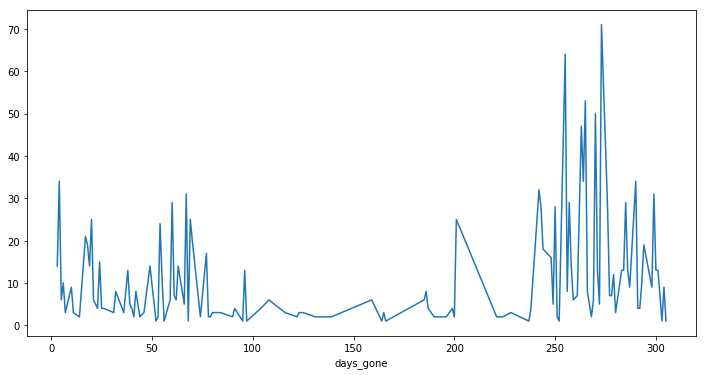

In [57]:
a = pd.DataFrame(df.groupby(['individual_id', 'days_gone']).count())
plt.figure(figsize=(12, 6))
a.loc['1']['time'].plot()

In [58]:
a.head()

time  page  cohort  ip  weeks_gone  months_gone  \
individual_id days_gone                                                    
1             3            14    14      14  14          14           14   
              4            34    34      34  34          34           34   
              5             6     6       6   6           6            6   
              6            10    10      10  10          10           10   
              7             3     3       3   3           3            3   

                         dg_probs  wg_probs  mg_probs  page_probs  
individual_id days_gone                                            
1             3                14        14        14          14  
              4                34        34        34          34  
              5                 6         6         6           6  
              6                10        10        10          10  
              7                 3         3         3           3

In [59]:
ts_df = df.resample('D')['days_gone'].median()

train_len = int(0.7 * len(ts_df))

In [60]:
train = ts_df[0:train_len]
test = ts_df[train_len:]

In [61]:
print(train.shape)
print(test.shape)
print(ts_df.shape)

(212,)
(91,)
(303,)


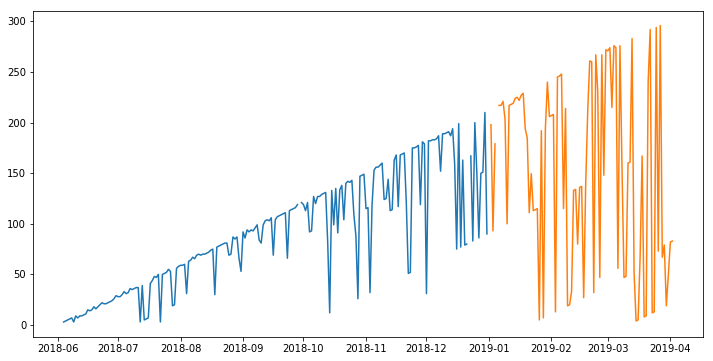

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(train)
plt.plot(test)
plt.show()

In [63]:
df.cohort.value_counts()

28    4758
1     3765
14    3347
23    2248
26    1873
24    1629
22    1386
21    1205
0      868
27     721
8      550
13     498
15     450
18     378
25     365
19     298
16     223
7      200
12     119
17     113
11       5
Name: cohort, dtype: int64

In [64]:
cohort_28 = df[df.cohort == '28']
cohort_28.sample(10)

individual_id      time                         page cohort  \
date                                                                     
2019-03-18             1  15:23:55                      10._NLP     28   
2019-01-22            53  09:13:14                   index.html     28   
2019-03-27             1  09:48:15                  6_Exercises     28   
2019-01-25            64  12:06:30                     appendix     28   
2019-03-29            11  09:38:41    javascript-i/conditionals     28   
2019-02-11           211  16:17:34          java-iii/user-input     28   
2019-02-24             1  21:23:39                3.6-functions     28   
2019-03-18           248  14:44:07  Classification_DecisionTree     28   
2019-03-27           211  08:00:08                      java-ii     28   
2019-03-22            11  09:33:55     html-css/css-i/box-model     28   

                        ip  days_gone  weeks_gone  months_gone  dg_probs  \
date                                                                       
2019-03-18    97.105.19.58        290        41.0         10.0  0.003097   
2019-01-22    97.105.19.58        233        33.0          8.0  0.000922   
2019-03-27    97.105.19.58        299        43.0         10.0  0.002286   
2019-01-25    97.105.19.58        235        34.0          8.0  0.001733   
2019-03-29    97.105.19.58        301        43.0         10.0  0.001106   
2019-02-11    97.105.19.58        119        17.0          4.0  0.003097   
2019-02-24  70.121.207.245        268        38.0          9.0  0.000406   
2019-03-18    97.105.19.58         68        10.0          2.0  0.002212   
2019-03-27    97.105.19.58        163        23.0          5.0  0.002507   
2019-03-22    97.105.19.58        294        42.0         10.0  0.004830   

            wg_probs  mg_probs  page_probs  
date                                        
2019-03-18  0.009882  0.040928    0.000160  
2019-01-22  0.012168  0.060396    0.017921  
2019-03-27  0.006047  0.040928    0.000840  
2019-01-25  0.018583  0.060396    0.017761  
2019-03-29  0.006047  0.040928    0.005840  
2019-02-11  0.022492  0.112053    0.005920  
2019-02-24  0.017957  0.069872    0.000720  
2019-03-18  0.035028  0.137753    0.000200  
2019-03-27  0.018325  0.061576    0.018201  
2019-03-22  0.019800  0.040928    0.004240

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


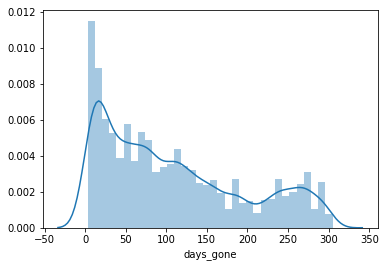

In [65]:
sns.distplot(df.days_gone)

In [69]:
test = cohort_28.groupby([cohort_28.index.date, 'individual_id']).count().reset_index().rename(columns={'level_0':'date'})
test[['date', 'individual_id', 'page']].head()
test['string_id'] = 'individual id '+test.individual_id



In [70]:
test.head()

date individual_id  time  page  cohort  ip  days_gone  weeks_gone  \
0  2018-12-06            40    11    11      11  11         11          11   
1  2018-12-06            53     3     3       3   3          3           3   
2  2018-12-06            64     2     2       2   2          2           2   
3  2018-12-07            11     6     6       6   6          6           6   
4  2018-12-07           211    18    18      18  18         18          18   

   months_gone  dg_probs  wg_probs  mg_probs  page_probs          string_id  
0           11        11        11        11          11   individual id 40  
1            3         3         3         3           3   individual id 53  
2            2         2         2         2           2   individual id 64  
3            6         6         6         6           6   individual id 11  
4           18        18        18        18          18  individual id 211

In [71]:
test.dtypes

date             object
individual_id    object
time              int64
page              int64
cohort            int64
ip                int64
days_gone         int64
weeks_gone        int64
months_gone       int64
dg_probs          int64
wg_probs          int64
mg_probs          int64
page_probs        int64
string_id        object
dtype: object

In [72]:
avg_line = test.set_index(pd.to_datetime(test.date)).resample('D').page.mean().fillna(0).reset_index()

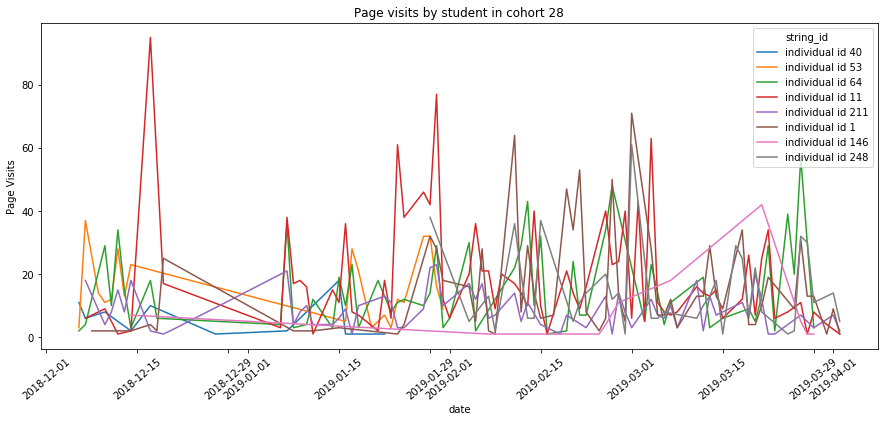

In [73]:
plt.figure(figsize=(15, 6))
sns.lineplot(x=test.date, y=test.page, hue=test.string_id)
# sns.lineplot(x=avg_line.date, y=avg_line.page, label='average')
plt.xticks(rotation=40)
plt.title('Page visits by student in cohort 28')
plt.ylabel('Page Visits')
plt.show()

In [74]:
cohort_28.resample('D')

DatetimeIndexResampler [freq=<Day>, axis=0, closed=left, label=left, convention=start, base=0]

(array([737029., 737043., 737057., 737060., 737074., 737088., 737091.,
        737105., 737119., 737133., 737147., 737150.]),
 <a list of 12 Text xticklabel objects>)

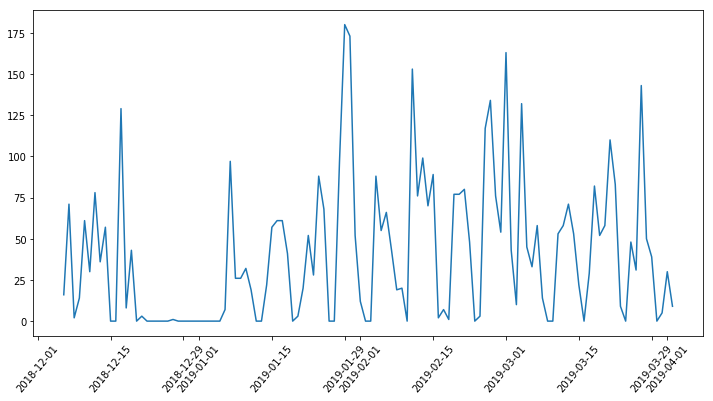

In [75]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=cohort_28.resample('D')['individual_id'].count())
plt.xticks(rotation=50)

Text(0, 0.5, 'Number of Website Hits')

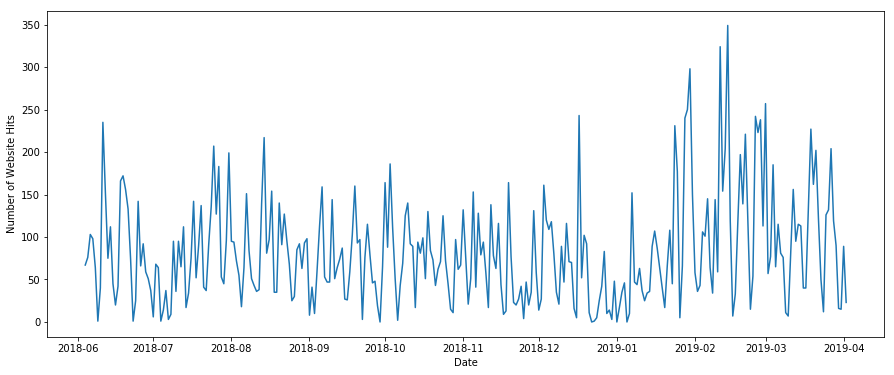

In [76]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df.resample('D')['page'].count())
plt.xlabel('Date')
plt.ylabel('Number of Website Hits')

### Looking at each cohort's students' usage.

In [77]:
def plotting_cohorts(cohort_number):
    cohort_dict = {}
    cohort_dict[f'{cohort_number}'] = df[df.cohort == f'{cohort_number}']
    
    test = cohort_dict[f'{cohort_number}'].groupby([cohort_dict[f'{cohort_number}'].index.date, 'individual_id']).count().reset_index().rename(columns={'level_0':'date'})
    test['string_id'] = 'individual id '+test.individual_id

    plt.figure(figsize=(15, 6))
    sns.lineplot(x=test.date, y=test.page, hue=test.string_id)
    # sns.lineplot(x=avg_line.date, y=avg_line.page, label='average')
    plt.xticks(rotation=40)
    plt.title(f'Page visits by students in cohort {cohort_number}')
    plt.ylabel('Page Visits')
    plt.show()
    return cohort_dict[f'{cohort_number}']

Cohort: 8


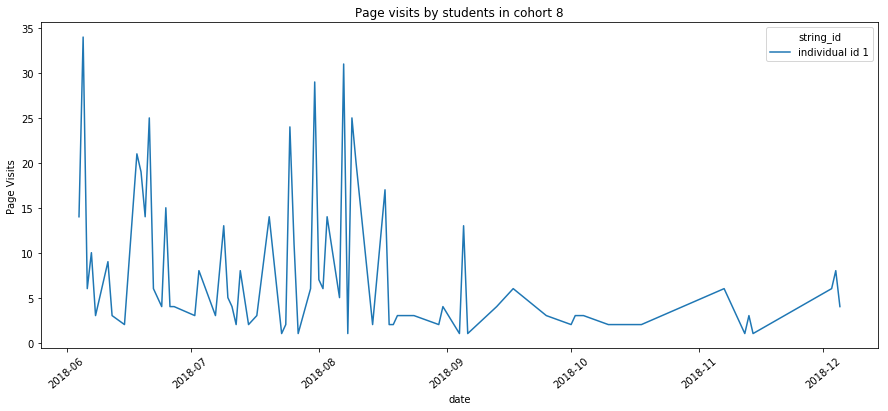

Cohort: 1


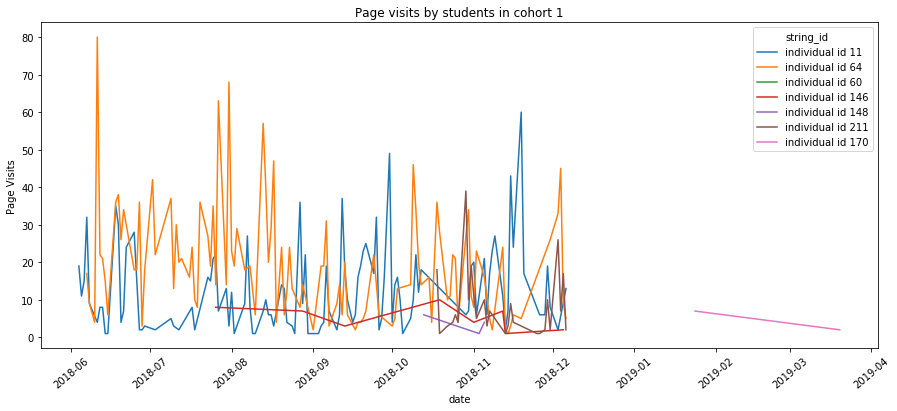

Cohort: 23


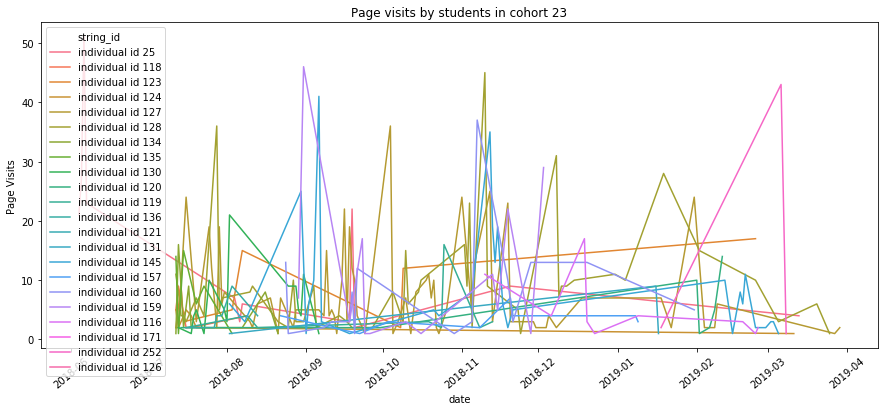

Cohort: 22


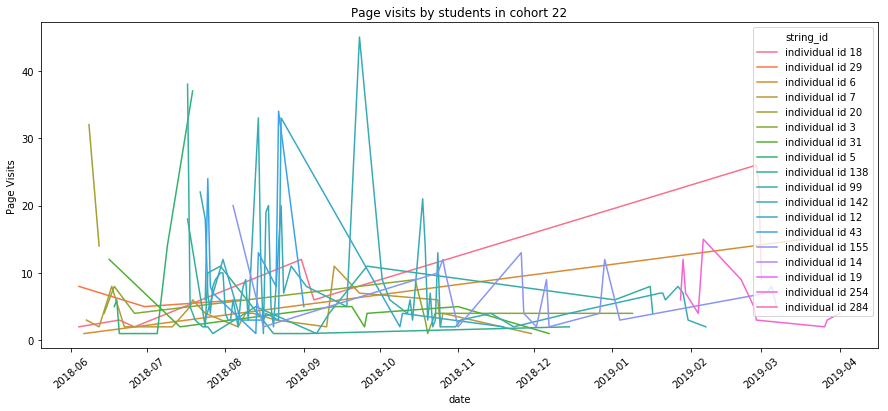

Cohort: 27


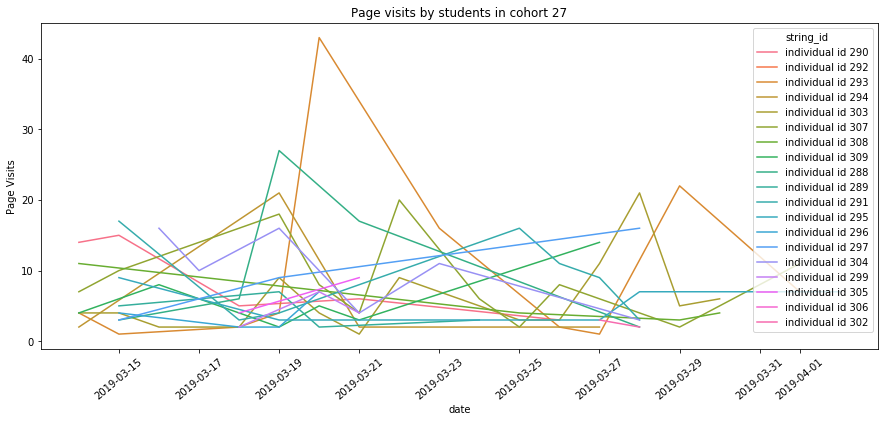

Cohort: 26


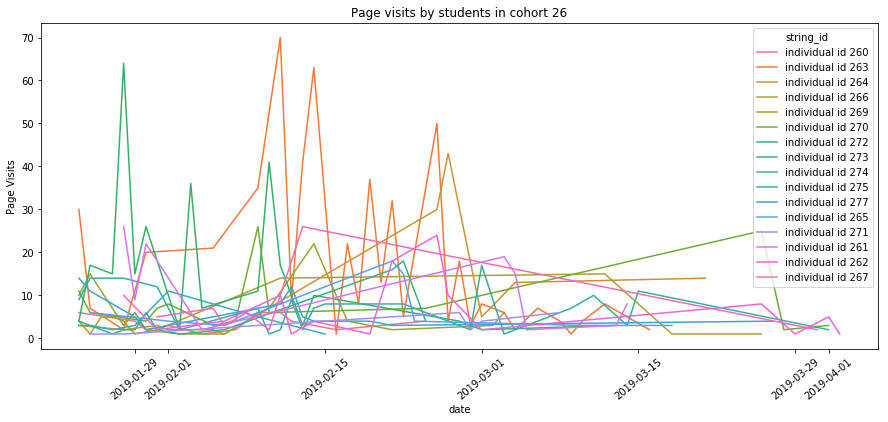

Cohort: 24


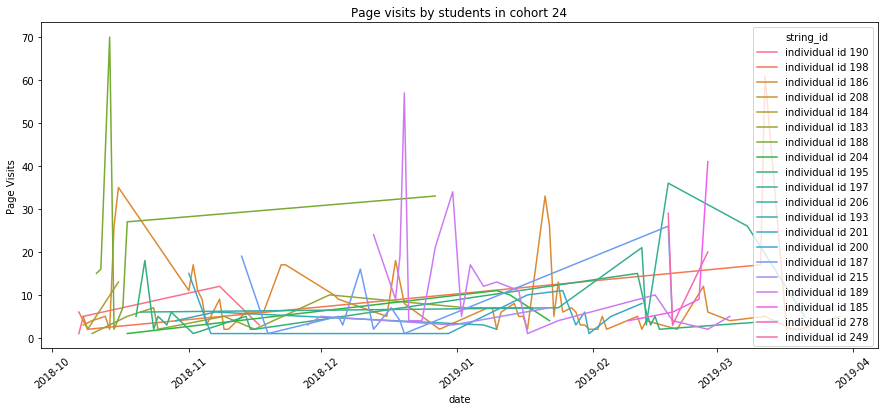

Cohort: 21


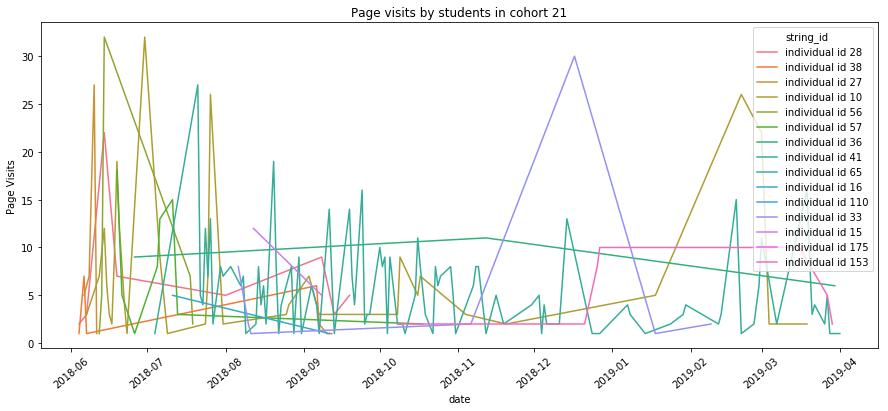

Cohort: 18


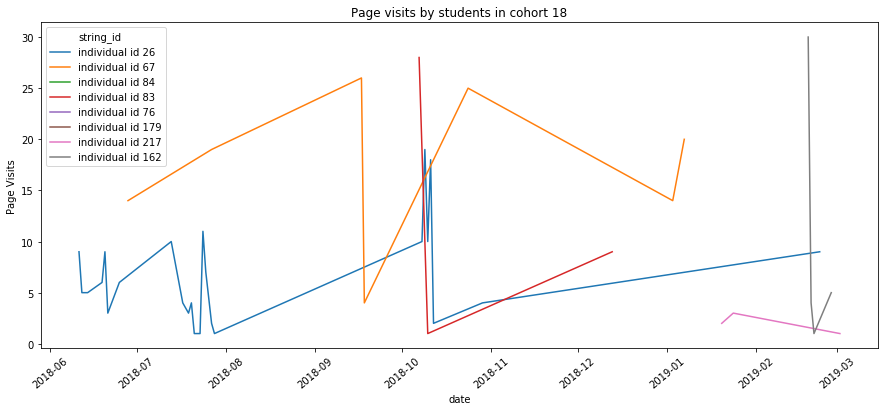

Cohort: 15


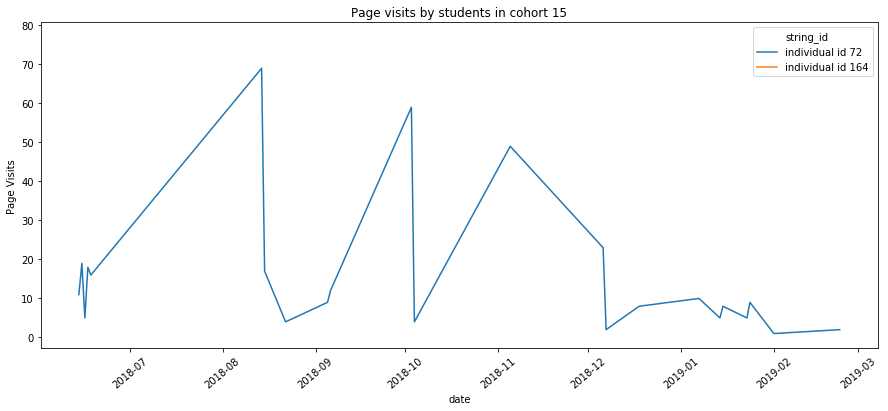

Cohort: 25


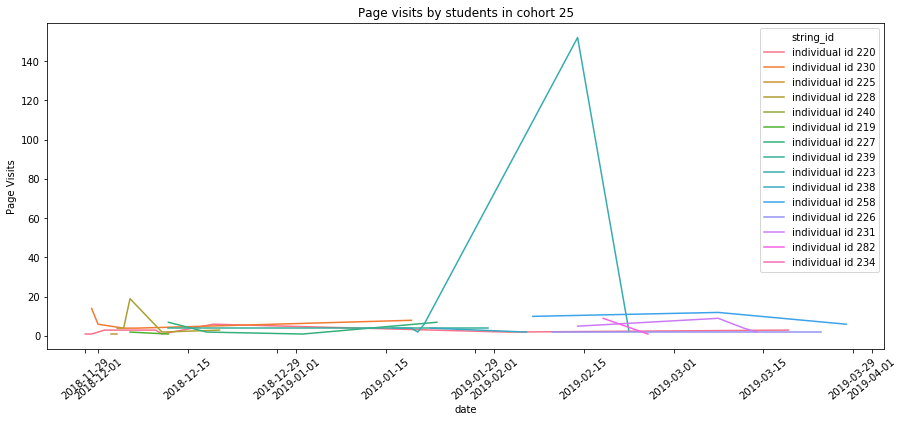

Cohort: 16


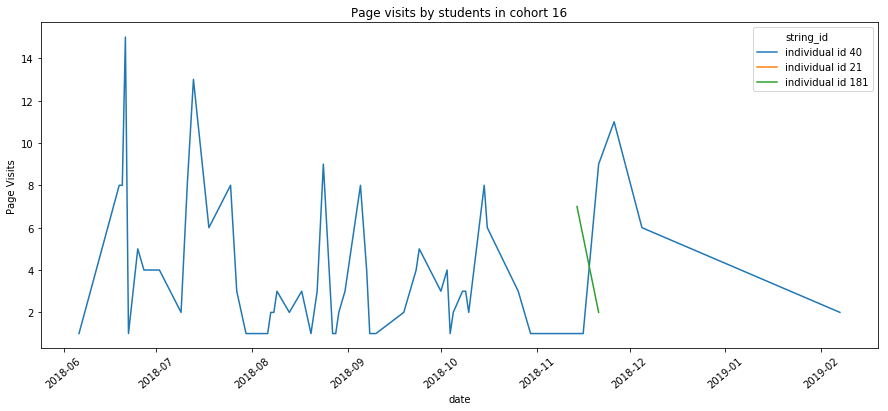

Cohort: 14


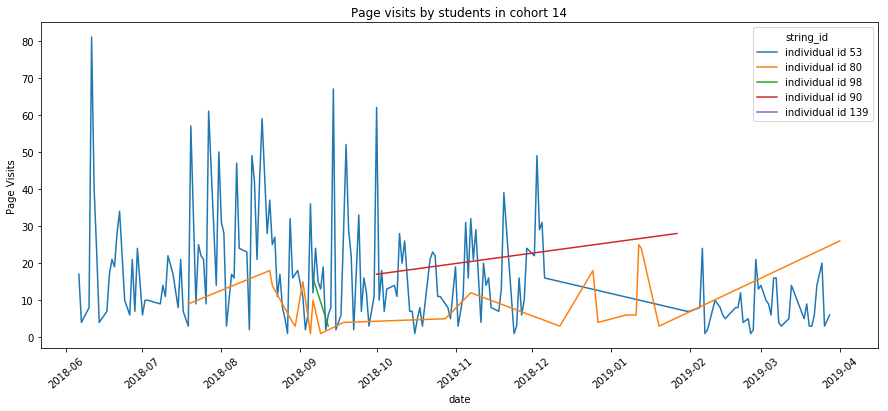

Cohort: 28


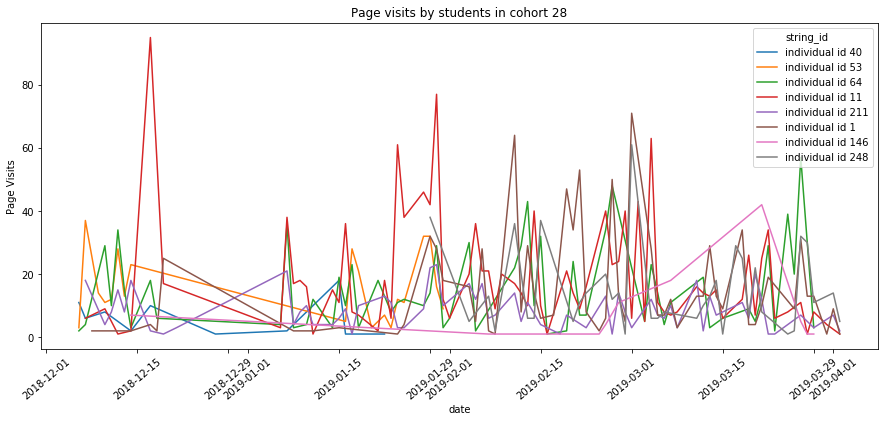

Cohort: 12


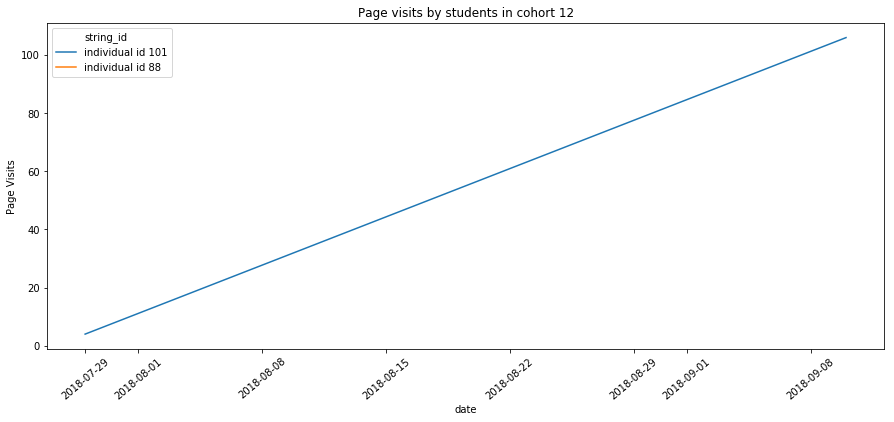

Cohort: 19


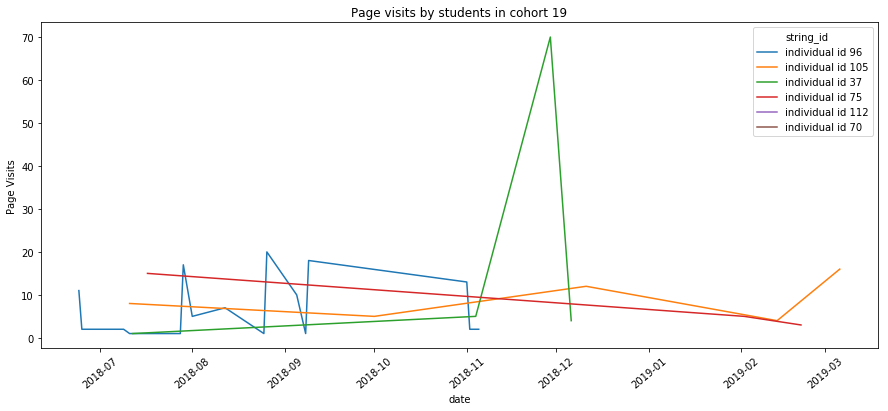

Cohort: 13


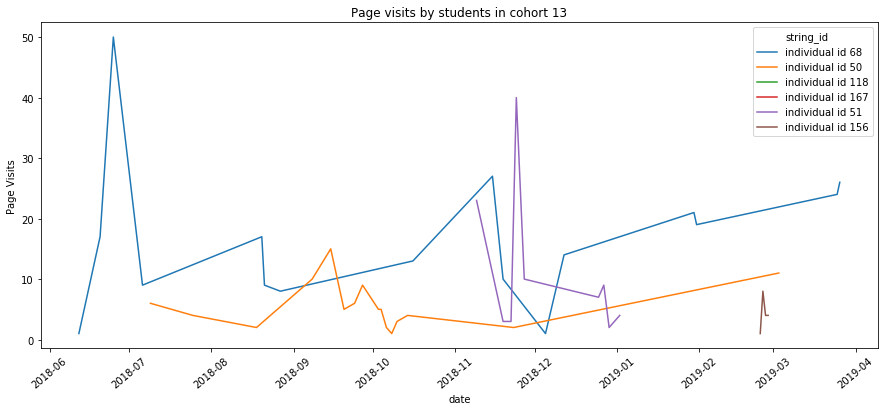

Cohort: 7


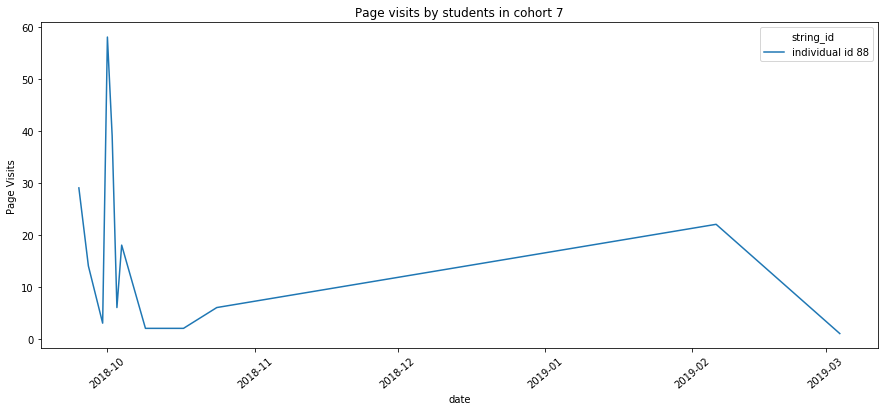

Cohort: 17


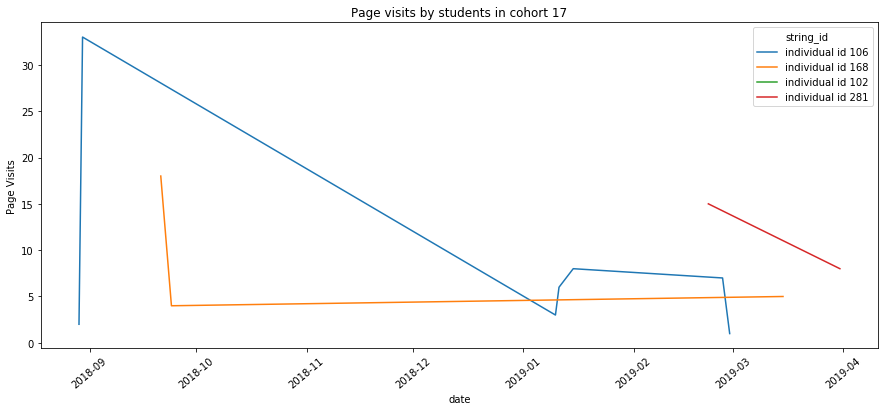

Cohort: 11


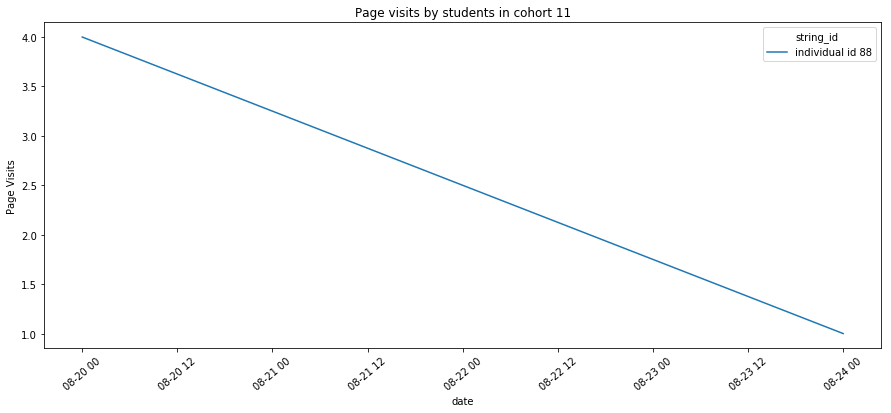

In [78]:
for cohort in df.cohort.unique():
    if cohort == 0:
        continue
    print(f'Cohort: {cohort}')
    plotting_cohorts(cohort)

In [79]:
df[(df.cohort == '25') & (df.individual_id == '223')].reset_index().date.value_counts()

2019-02-14    152
2019-01-21      6
2019-01-16      4
2019-01-19      4
2019-02-22      3
2019-01-20      2
Name: date, dtype: int64

In [80]:
df[(df.cohort == '25') & (df.individual_id == '223')].ip.value_counts()

136.50.20.17      168
172.58.109.155      2
97.105.19.58        1
Name: ip, dtype: int64

### Looked over 16% of the curriculum in one day

In [81]:
len(df[df.individual_id == '223']['2019-02-14'].page.unique())/len(df.page.unique())

0.1611185086551265

In [135]:
vday = df[df.individual_id == '223']['2019-02-14'].reset_index()
vday['date_time'] = vday.date.astype('str') + ' ' + vday.time

In [95]:
vday.head()

date individual_id      time                                   page  \
0 2019-02-14           223  22:40:49                        1._Fundamentals   
1 2019-02-14           223  22:46:58              2.00.04_PrepareData_Excel   
2 2019-02-14           223  22:47:11  2.00.05_Charts_PivotTables_Sparklines   
3 2019-02-14           223  22:47:24              2.01.00_Descriptive_Stats   
4 2019-02-14           223  22:47:48                    2.02.01_Probability   

  cohort            ip  days_gone  weeks_gone  months_gone  dg_probs  \
0     25  136.50.20.17         80        11.0          3.0  0.010767   
1     25  136.50.20.17         80        11.0          3.0  0.010767   
2     25  136.50.20.17         80        11.0          3.0  0.010767   
3     25  136.50.20.17         80        11.0          3.0  0.010767   
4     25  136.50.20.17         80        11.0          3.0  0.010767   

   wg_probs  mg_probs  page_probs            date_time  
0  0.037867  0.122304     0.00524  2019-02-14 22:40:49  
1  0.037867  0.122304     0.00088  2019-02-14 22:46:58  
2  0.037867  0.122304     0.00076  2019-02-14 22:47:11  
3  0.037867  0.122304     0.00176  2019-02-14 22:47:24  
4  0.037867  0.122304     0.00140  2019-02-14 22:47:48

In [136]:
vday.date_time = pd.to_datetime(vday.date_time)

In [137]:
vday.set_index('date_time', inplace=True)

In [100]:
vday.head()

date individual_id      time  \
date_time                                                
2019-02-14 22:40:49 2019-02-14           223  22:40:49   
2019-02-14 22:46:58 2019-02-14           223  22:46:58   
2019-02-14 22:47:11 2019-02-14           223  22:47:11   
2019-02-14 22:47:24 2019-02-14           223  22:47:24   
2019-02-14 22:47:48 2019-02-14           223  22:47:48   

                                                      page cohort  \
date_time                                                           
2019-02-14 22:40:49                        1._Fundamentals     25   
2019-02-14 22:46:58              2.00.04_PrepareData_Excel     25   
2019-02-14 22:47:11  2.00.05_Charts_PivotTables_Sparklines     25   
2019-02-14 22:47:24              2.01.00_Descriptive_Stats     25   
2019-02-14 22:47:48                    2.02.01_Probability     25   

                               ip  days_gone  weeks_gone  months_gone  \
date_time                                                               
2019-02-14 22:40:49  136.50.20.17         80        11.0          3.0   
2019-02-14 22:46:58  136.50.20.17         80        11.0          3.0   
2019-02-14 22:47:11  136.50.20.17         80        11.0          3.0   
2019-02-14 22:47:24  136.50.20.17         80        11.0          3.0   
2019-02-14 22:47:48  136.50.20.17         80        11.0          3.0   

                     dg_probs  wg_probs  mg_probs  page_probs  
date_time                                                      
2019-02-14 22:40:49  0.010767  0.037867  0.122304     0.00524  
2019-02-14 22:46:58  0.010767  0.037867  0.122304     0.00088  
2019-02-14 22:47:11  0.010767  0.037867  0.122304     0.00076  
2019-02-14 22:47:24  0.010767  0.037867  0.122304     0.00176  
2019-02-14 22:47:48  0.010767  0.037867  0.122304     0.00140

In [164]:
vday.index.to_series().sort_values().diff().fillna(0)

date_time
2019-02-14 22:40:49   00:00:00
2019-02-14 22:42:47   00:01:58
2019-02-14 22:44:39   00:01:52
2019-02-14 22:45:32   00:00:53
2019-02-14 22:46:32   00:01:00
2019-02-14 22:46:46   00:00:14
2019-02-14 22:46:58   00:00:12
2019-02-14 22:47:11   00:00:13
2019-02-14 22:47:24   00:00:13
2019-02-14 22:47:34   00:00:10
2019-02-14 22:47:48   00:00:14
2019-02-14 22:47:58   00:00:10
2019-02-14 22:48:08   00:00:10
2019-02-14 22:48:20   00:00:12
2019-02-14 22:48:32   00:00:12
2019-02-14 22:48:43   00:00:11
2019-02-14 22:48:55   00:00:12
2019-02-14 22:49:40   00:00:45
2019-02-14 22:49:51   00:00:11
2019-02-14 22:50:00   00:00:09
2019-02-14 22:50:10   00:00:10
2019-02-14 22:50:21   00:00:11
2019-02-14 22:50:31   00:00:10
2019-02-14 22:50:43   00:00:12
2019-02-14 22:50:52   00:00:09
2019-02-14 22:51:00   00:00:08
2019-02-14 22:51:09   00:00:09
2019-02-14 22:51:20   00:00:11
2019-02-14 22:51:31   00:00:11
2019-02-14 22:51:40   00:00:09
                        ...   
2019-02-14 23:15:24   00:00:0

## Detecting anomalies at an individual level.

In [143]:
df.individual_id.sort_values().unique()

array(['1', '10', '101', '102', '103', '105', '106', '11', '110', '111',
       '112', '116', '118', '119', '12', '120', '121', '123', '124',
       '126', '127', '128', '130', '131', '134', '135', '136', '138',
       '139', '14', '142', '145', '146', '148', '15', '153', '155', '156',
       '157', '159', '16', '160', '162', '164', '167', '168', '170',
       '171', '175', '179', '18', '181', '183', '184', '185', '186',
       '187', '188', '189', '19', '190', '193', '195', '197', '198', '20',
       '200', '201', '204', '206', '208', '21', '211', '215', '217',
       '219', '220', '223', '225', '226', '227', '228', '230', '231',
       '234', '238', '239', '240', '248', '249', '25', '252', '254',
       '258', '26', '260', '261', '262', '263', '264', '265', '266',
       '267', '269', '27', '270', '271', '272', '273', '274', '275',
       '277', '278', '28', '281', '282', '284', '288', '289', '29', '290',
       '291', '292', '293', '294', '295', '296', '297', '299', '3', '302',
    

In [145]:
df = df.reset_index()
df['date_time'] = df.date.astype('str') + ' ' + df.time

In [147]:
df.date_time = pd.to_datetime(df.date_time)
df.set_index('date_time', inplace=True)

This is the page visit plot for: 1


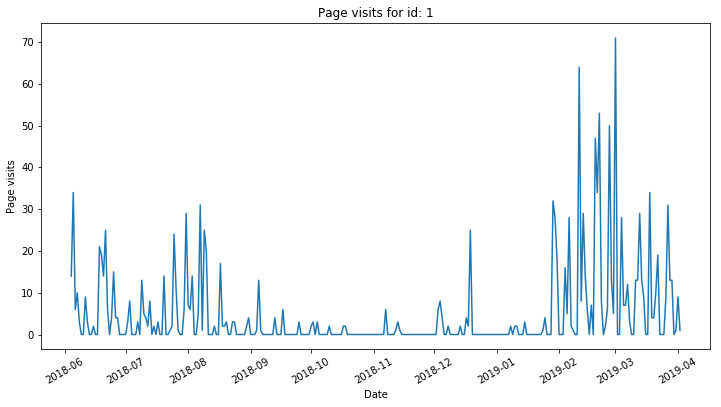

This is the page visit plot for: 11


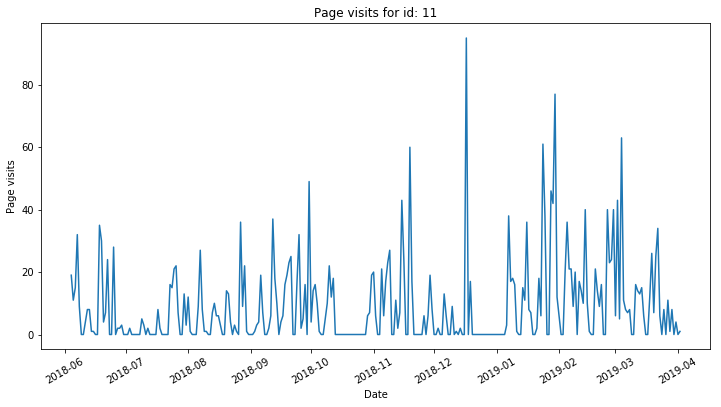

This is the page visit plot for: 211


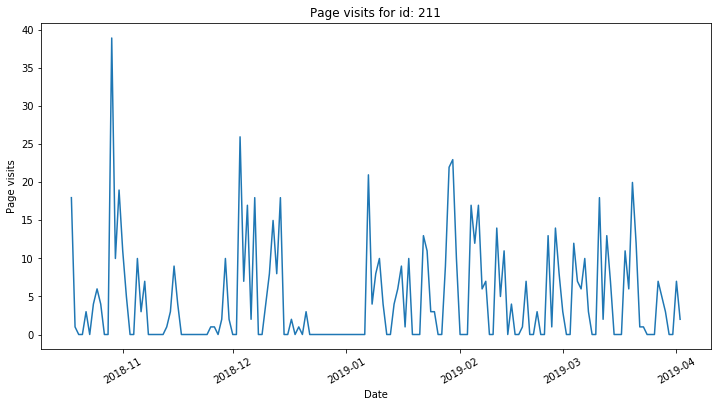

This is the page visit plot for: 25


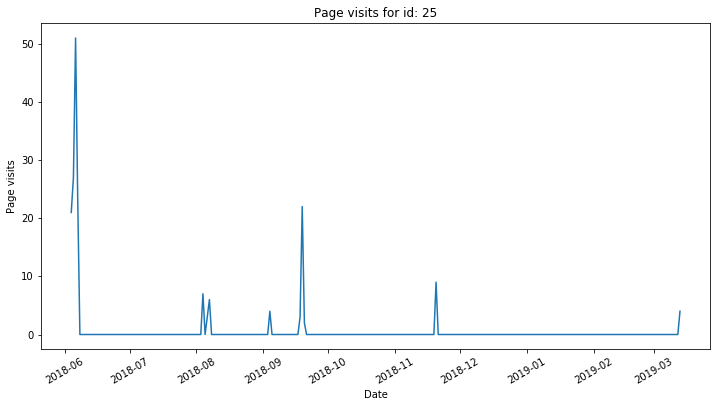

This is the page visit plot for: 29


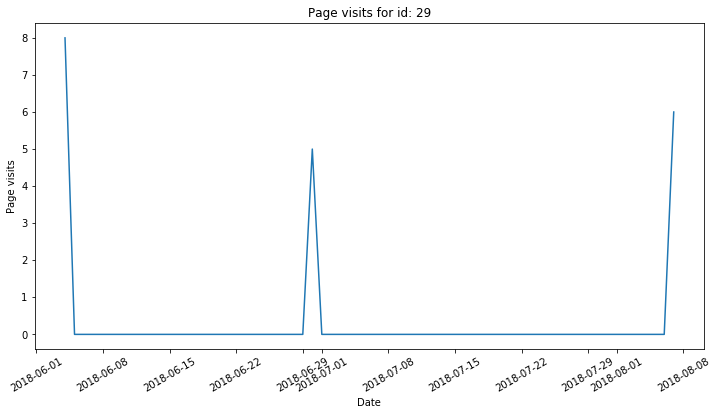

This is the page visit plot for: 293


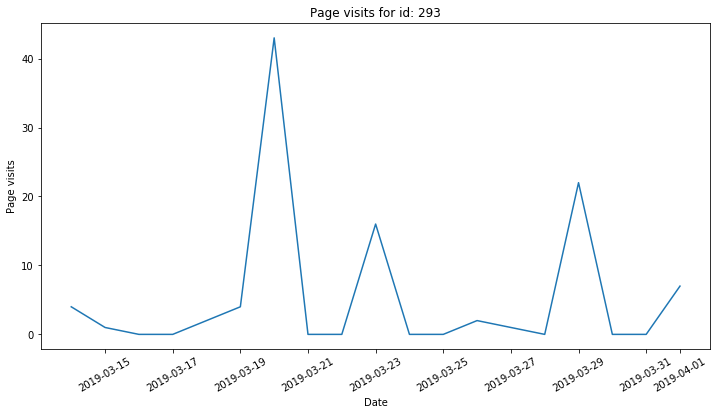

This is the page visit plot for: 269


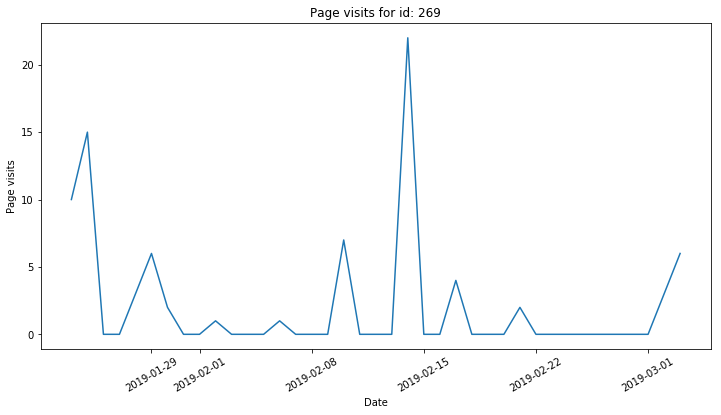

This is the page visit plot for: 272


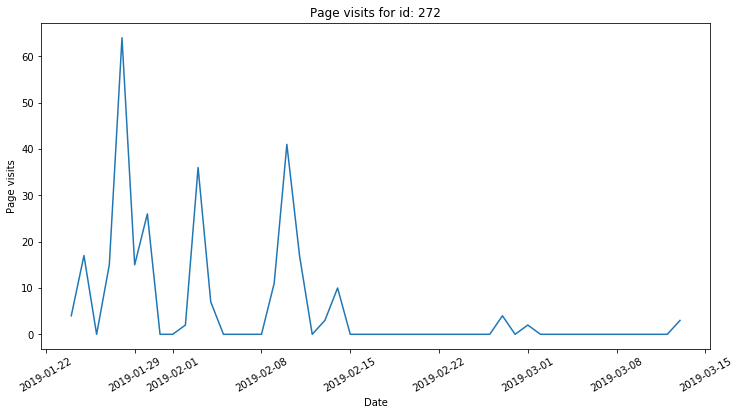

This is the page visit plot for: 274


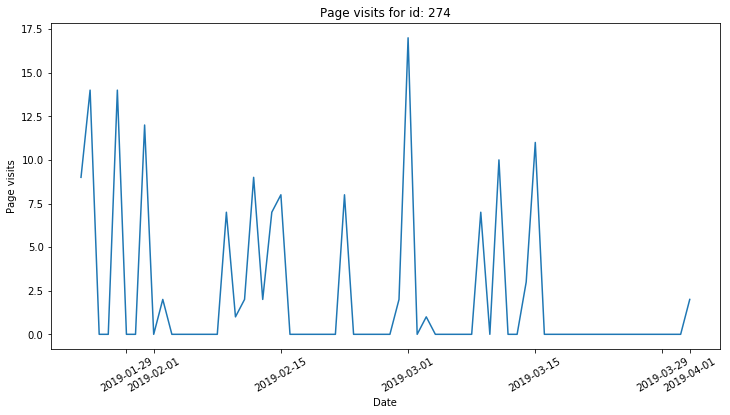

This is the page visit plot for: 277


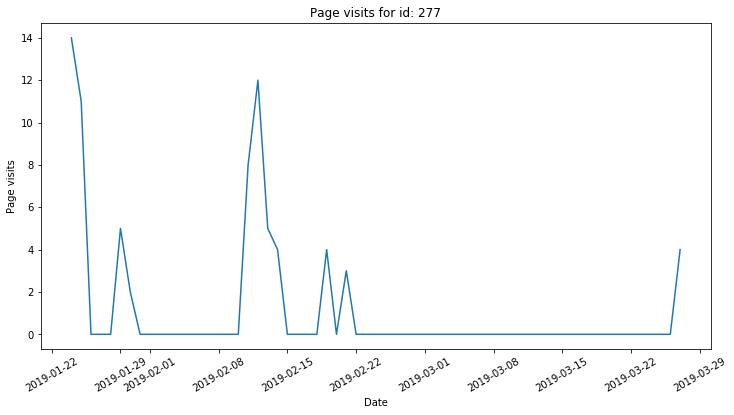

This is the page visit plot for: 288


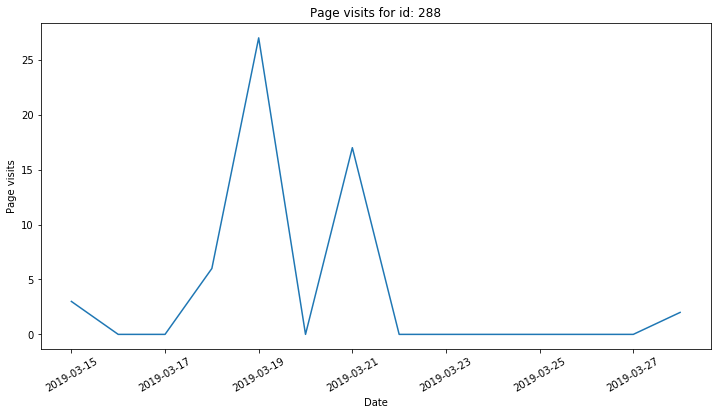

This is the page visit plot for: 198


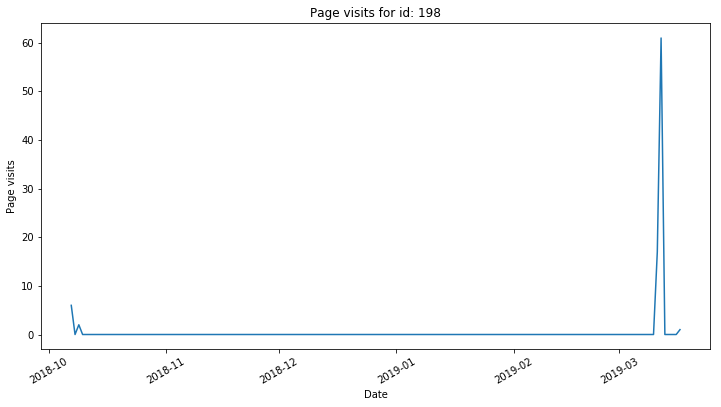

This is the page visit plot for: 135


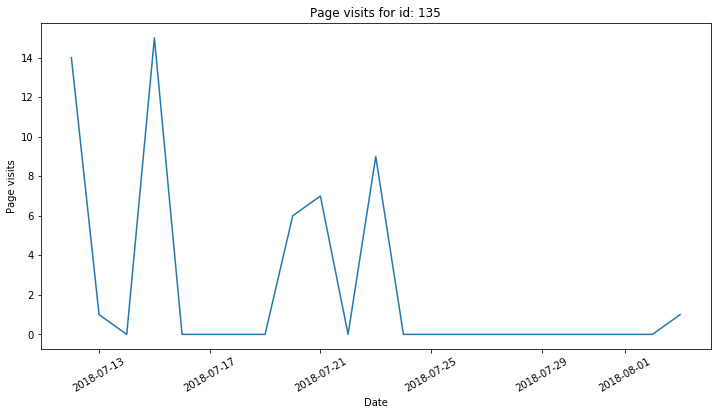

This is the page visit plot for: 64


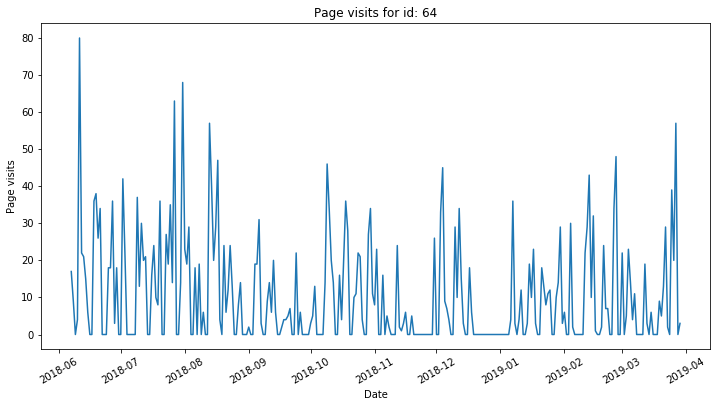

This is the page visit plot for: 20


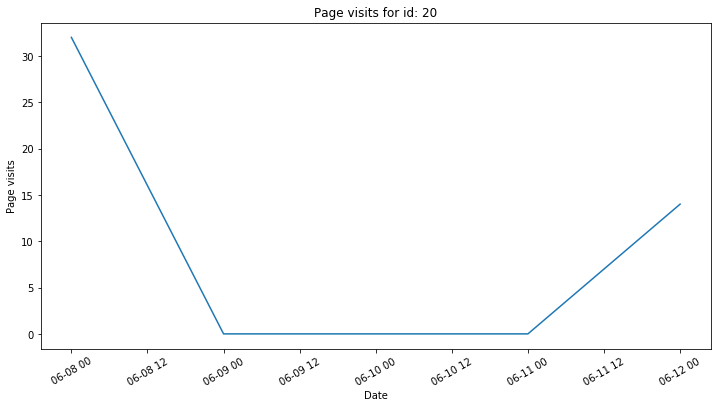

This is the page visit plot for: 262


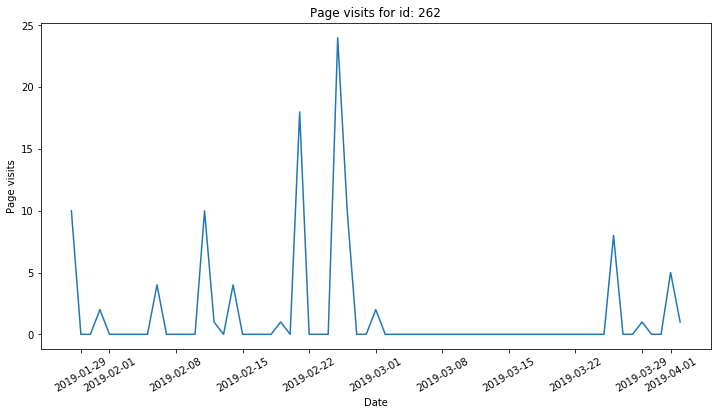

This is the page visit plot for: 273


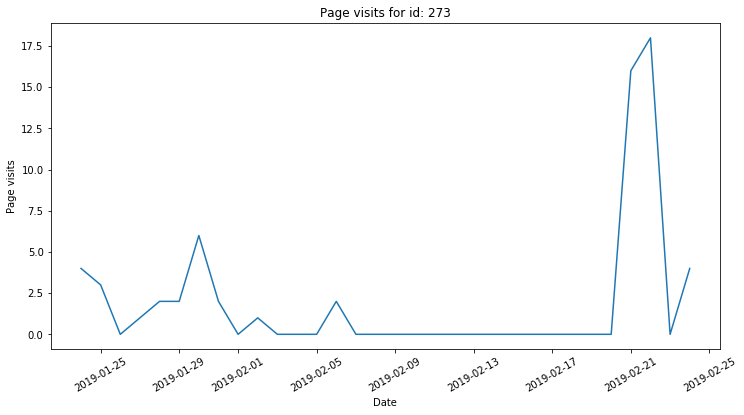

This is the page visit plot for: 188


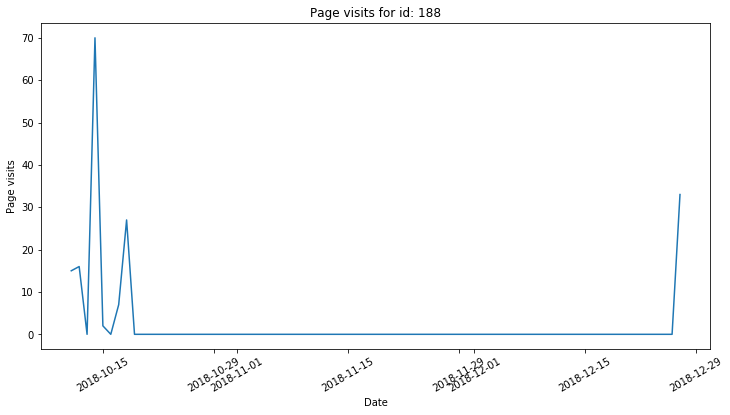

This is the page visit plot for: 299


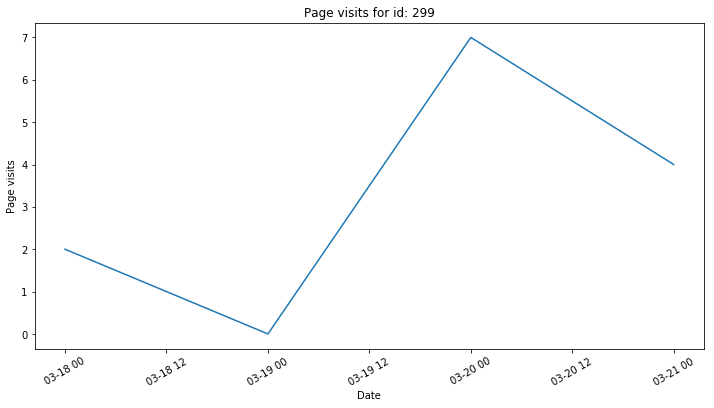

This is the page visit plot for: 303


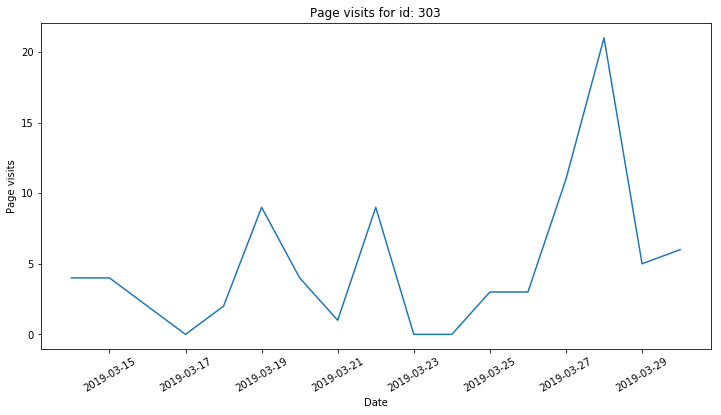

This is the page visit plot for: 134


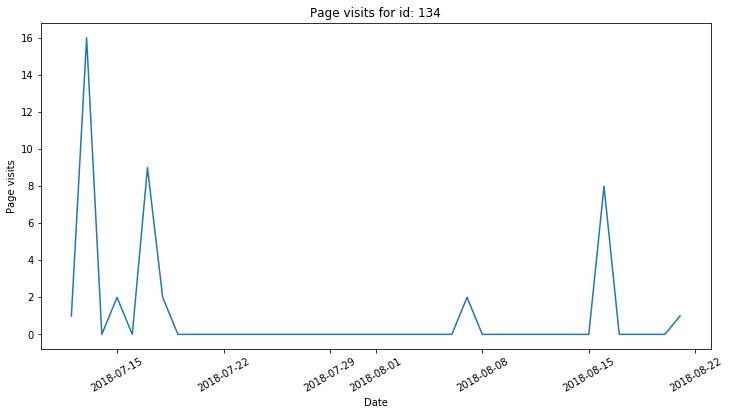

This is the page visit plot for: 261


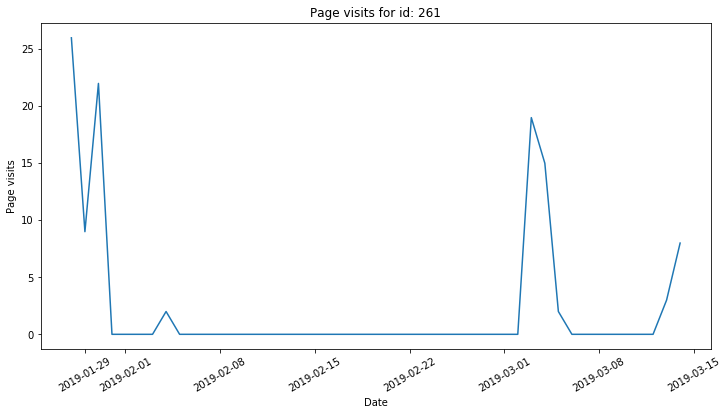

This is the page visit plot for: 291


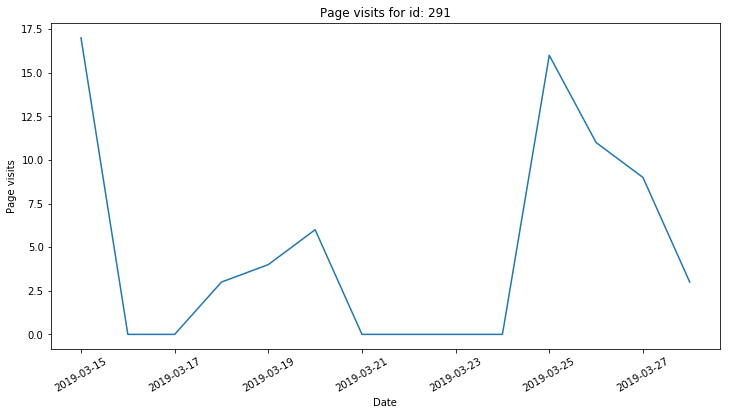

This is the page visit plot for: 61


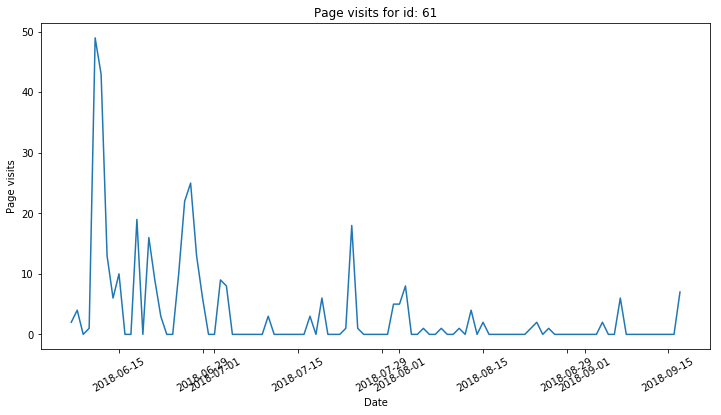

This is the page visit plot for: 175


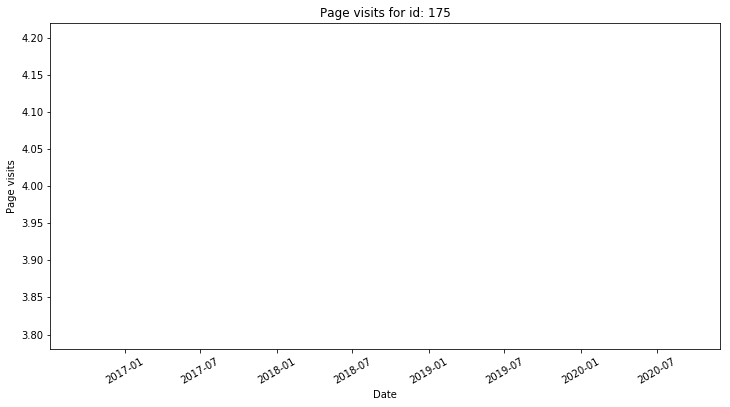

This is the page visit plot for: 184


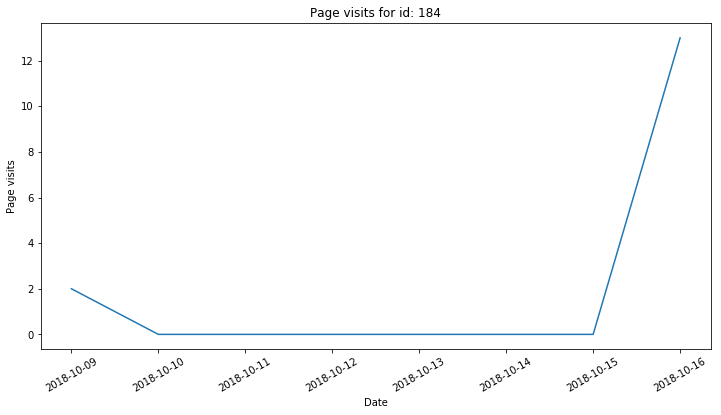

This is the page visit plot for: 186


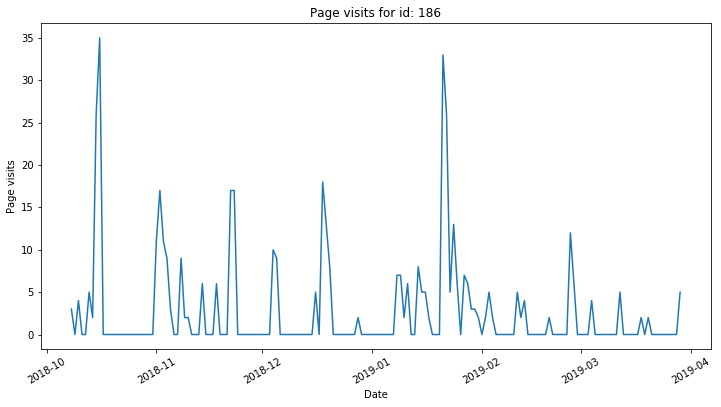

This is the page visit plot for: 3


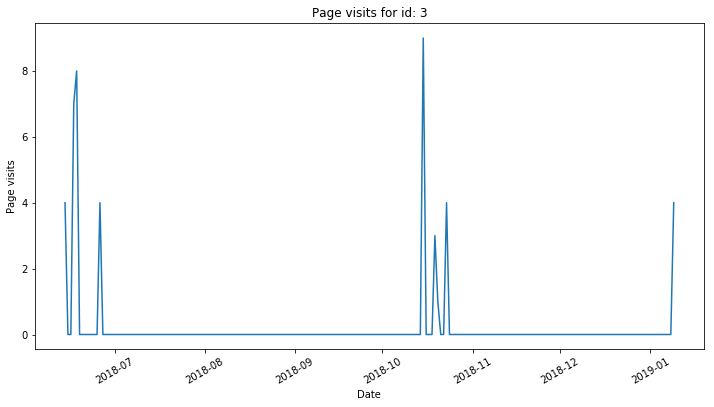

This is the page visit plot for: 28


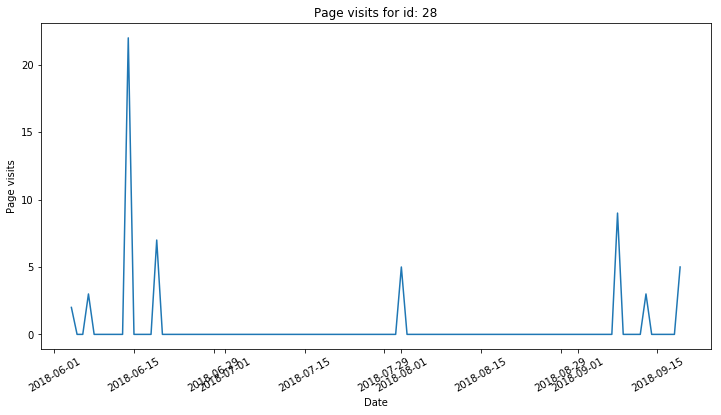

This is the page visit plot for: 31


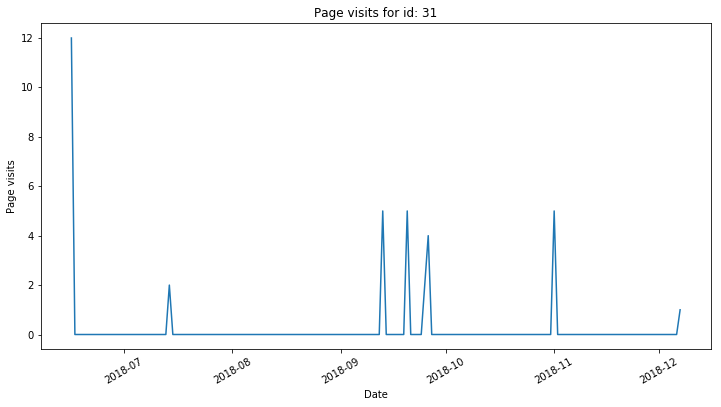

This is the page visit plot for: 73


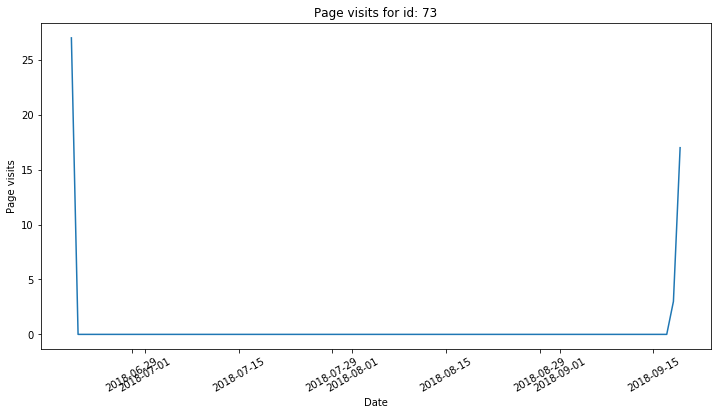

This is the page visit plot for: 26


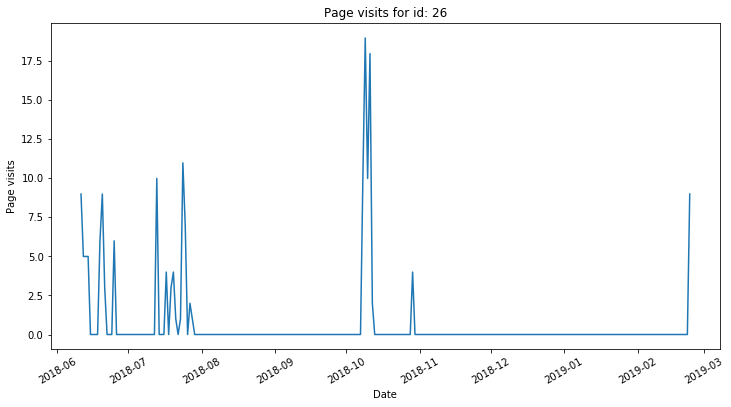

This is the page visit plot for: 72


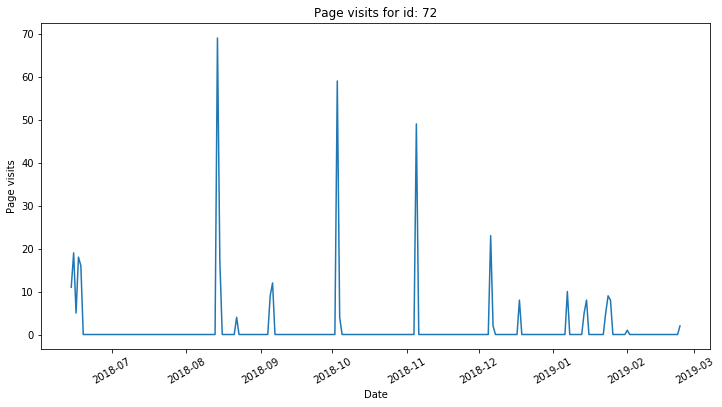

This is the page visit plot for: 195


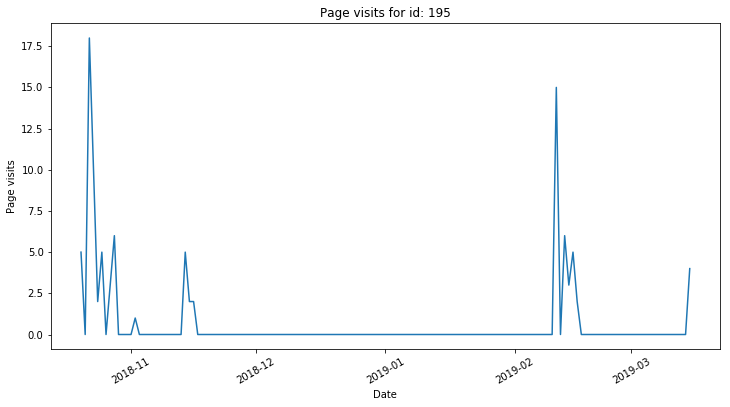

This is the page visit plot for: 258


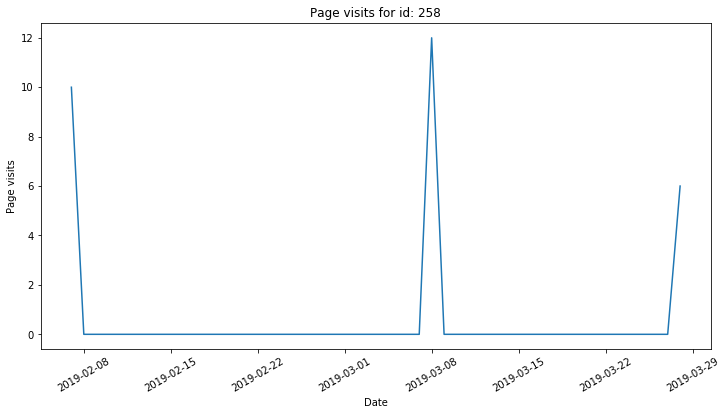

This is the page visit plot for: 263


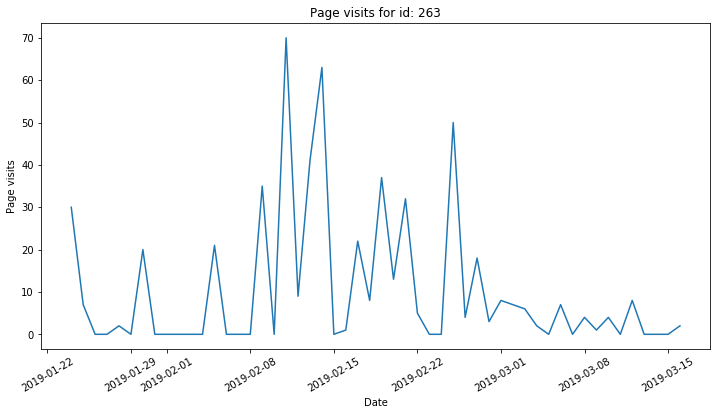

This is the page visit plot for: 275


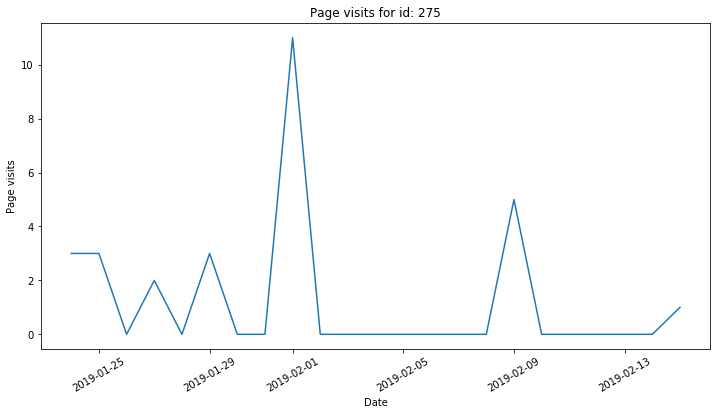

This is the page visit plot for: 206


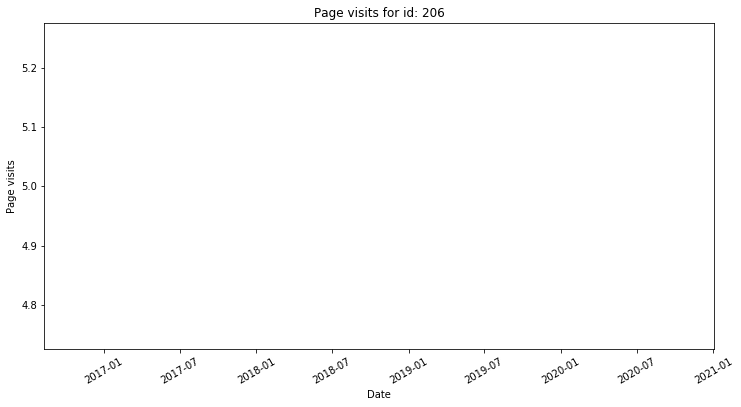

This is the page visit plot for: 40


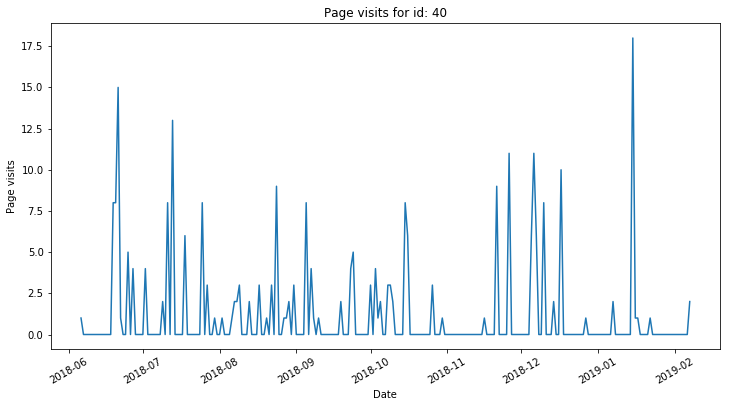

This is the page visit plot for: 128


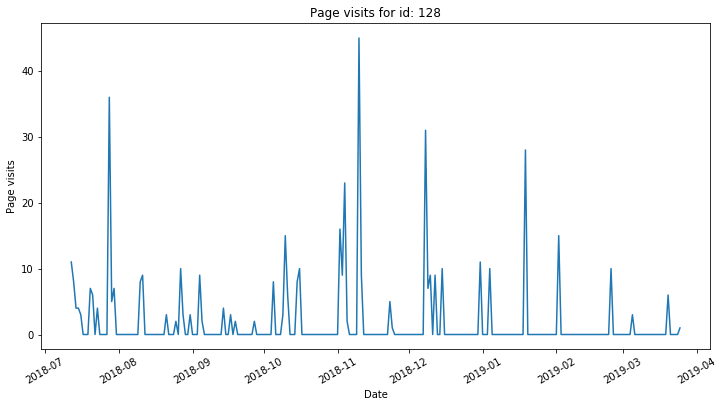

This is the page visit plot for: 266


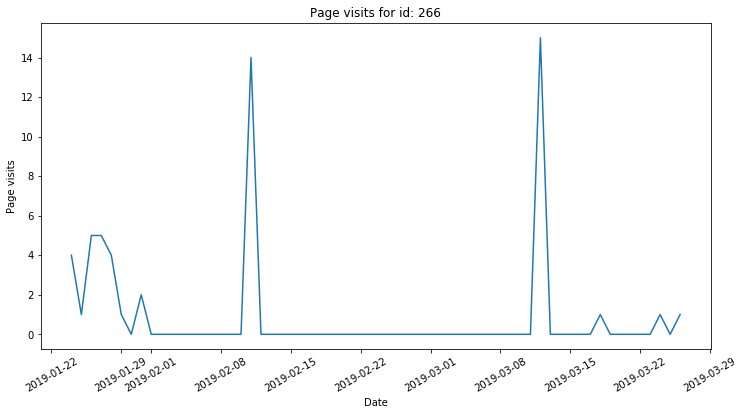

This is the page visit plot for: 59


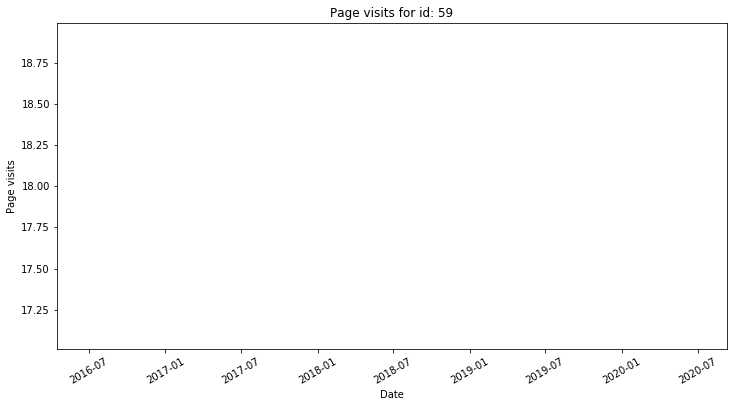

This is the page visit plot for: 110


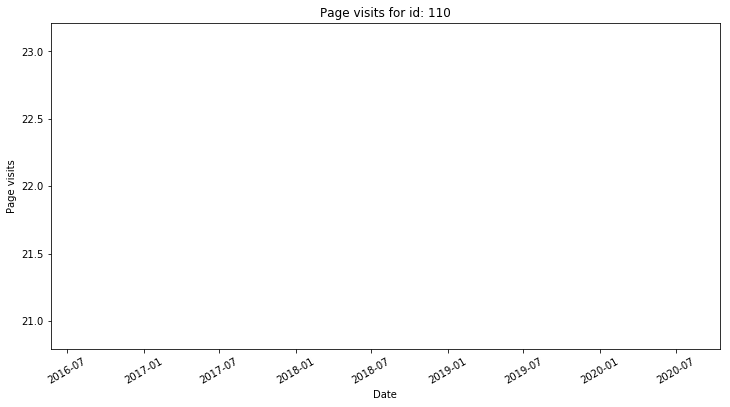

This is the page visit plot for: 142


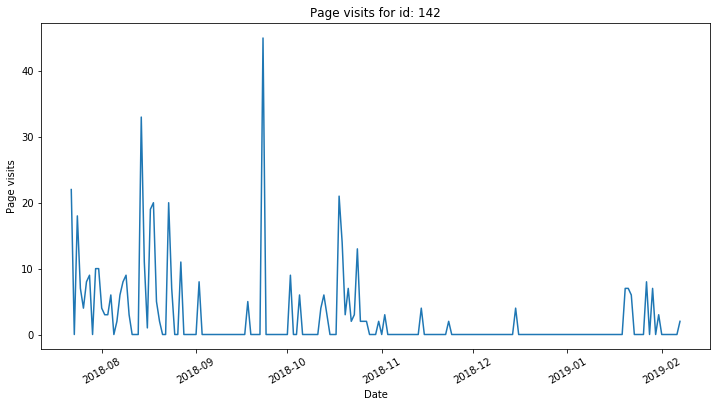

This is the page visit plot for: 99


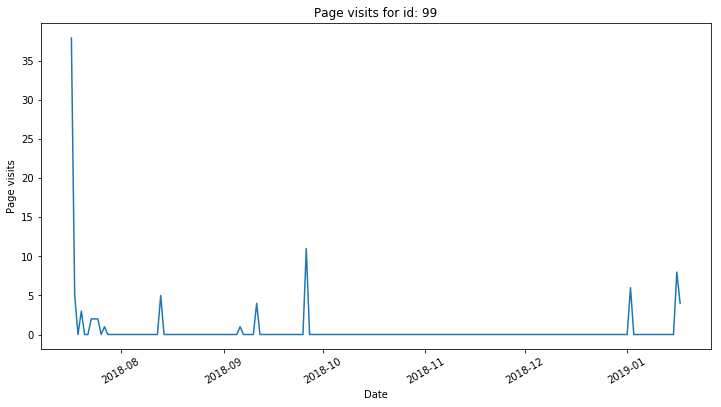

This is the page visit plot for: 193


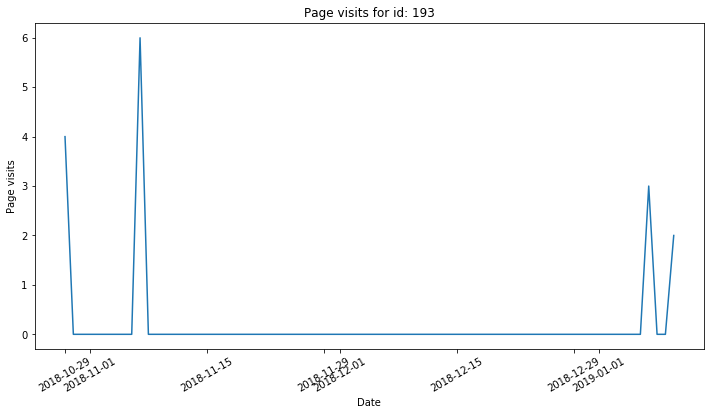

This is the page visit plot for: 264


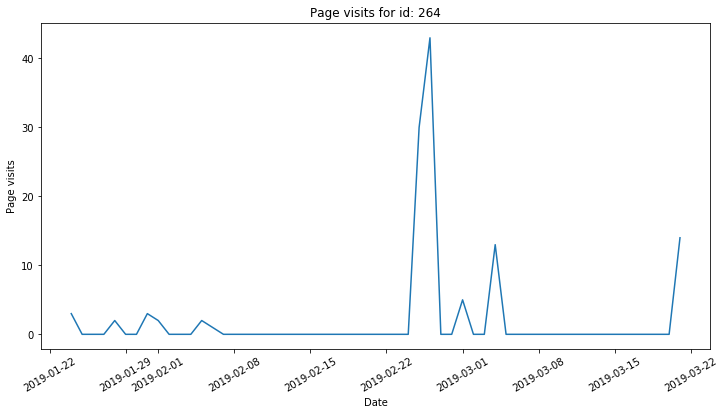

This is the page visit plot for: 271


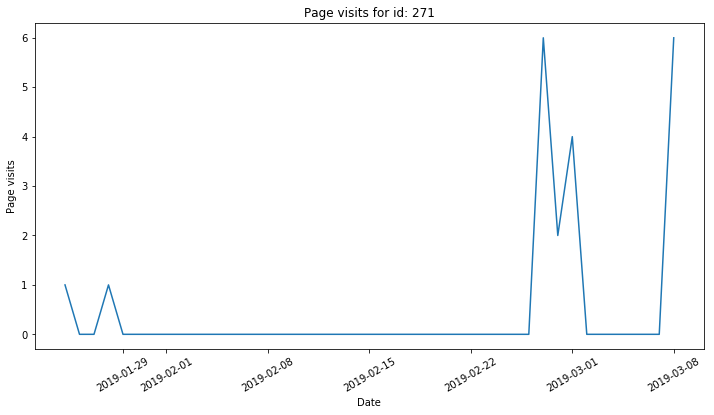

This is the page visit plot for: 127


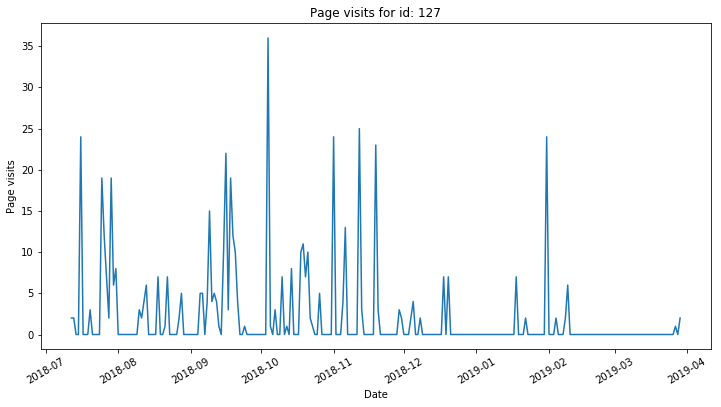

This is the page visit plot for: 270


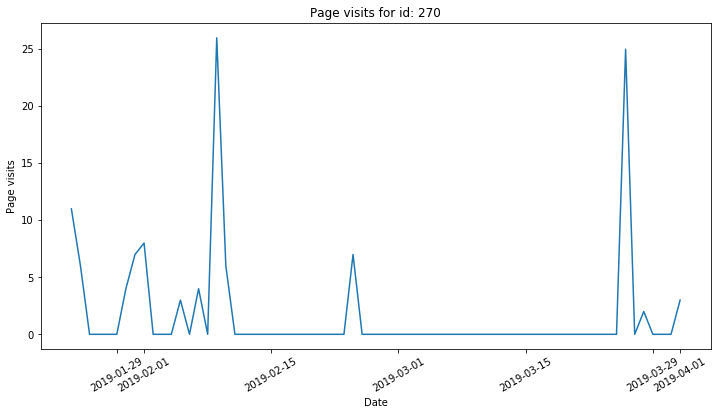

This is the page visit plot for: 57


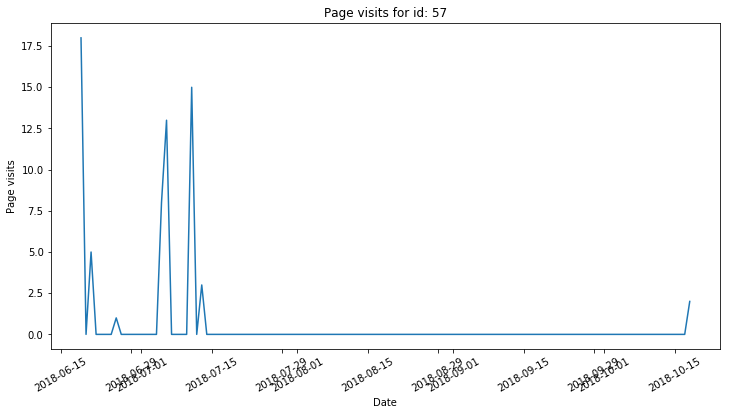

This is the page visit plot for: 187


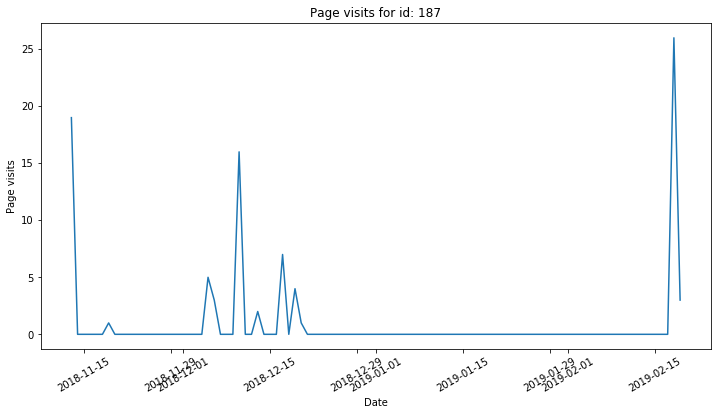

This is the page visit plot for: 145


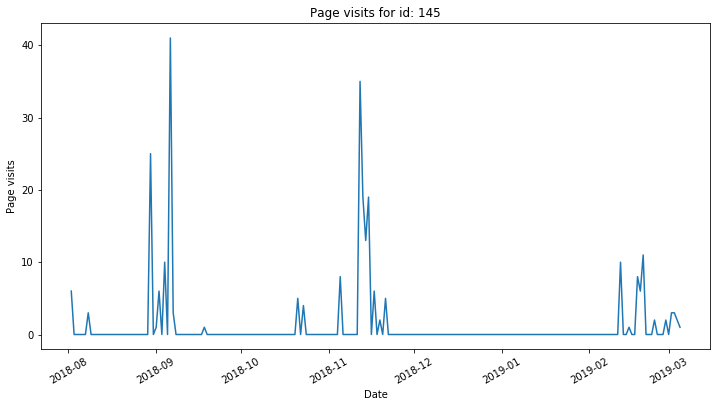

This is the page visit plot for: 190


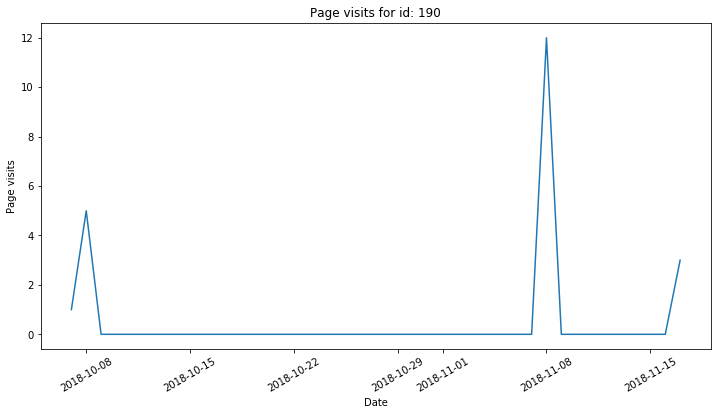

This is the page visit plot for: 249


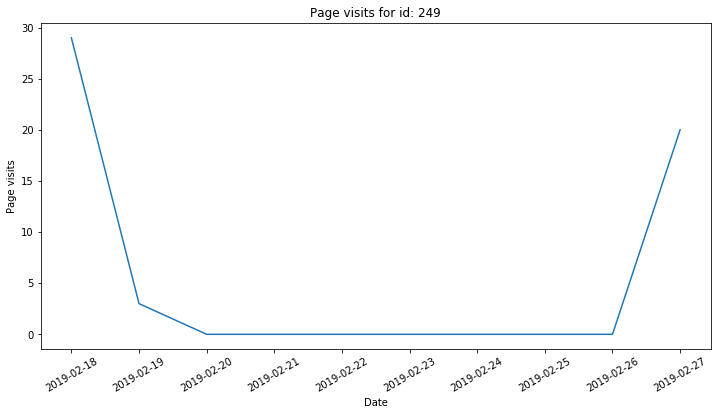

This is the page visit plot for: 130


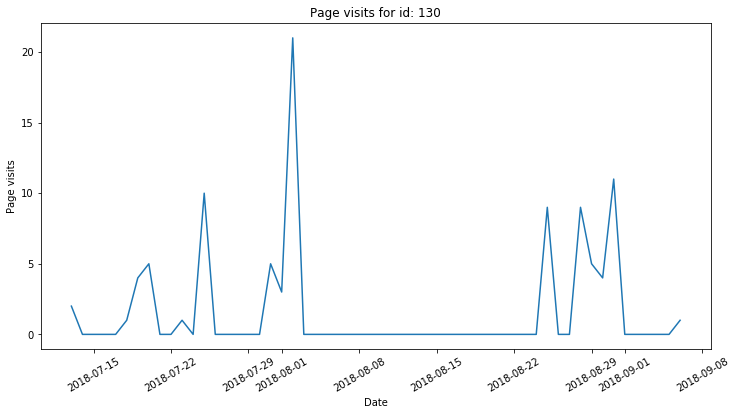

This is the page visit plot for: 53


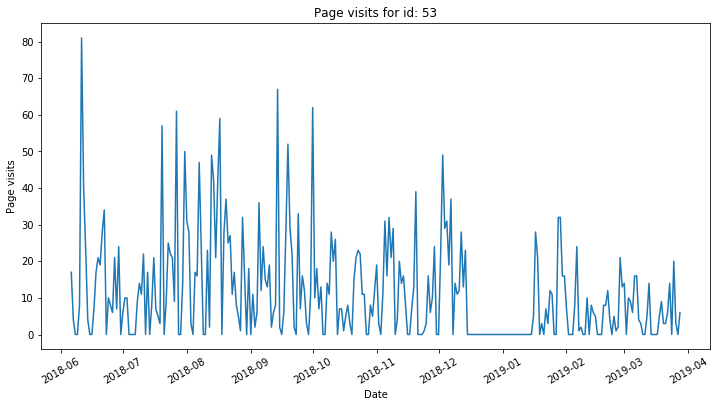

This is the page visit plot for: 252


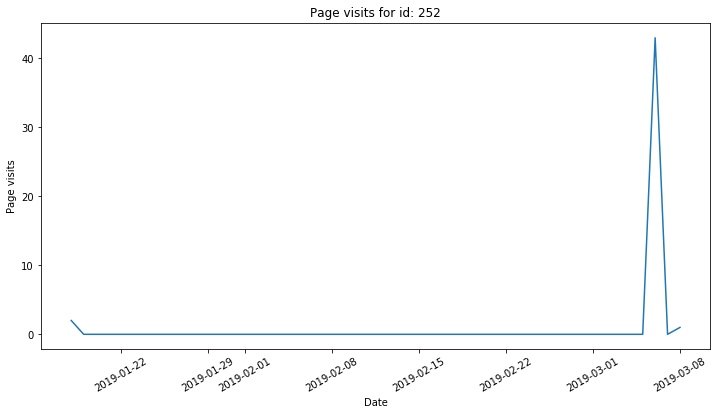

This is the page visit plot for: 10


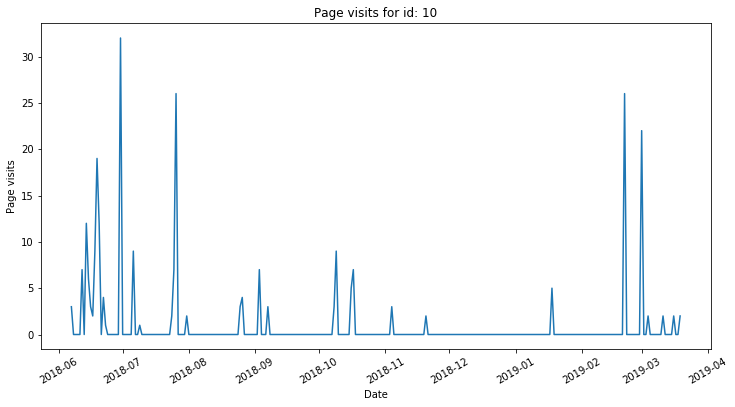

This is the page visit plot for: 43


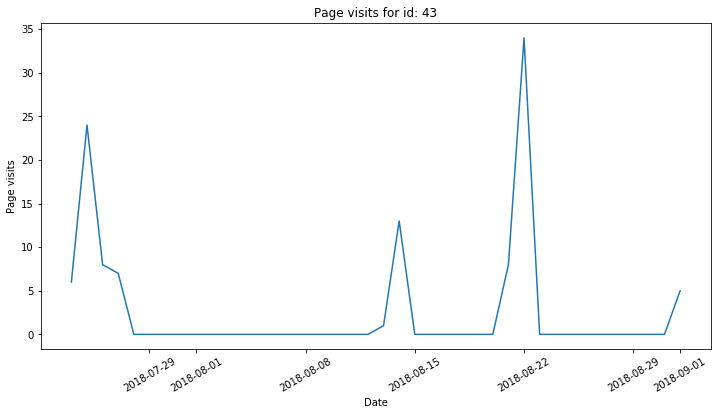

This is the page visit plot for: 88


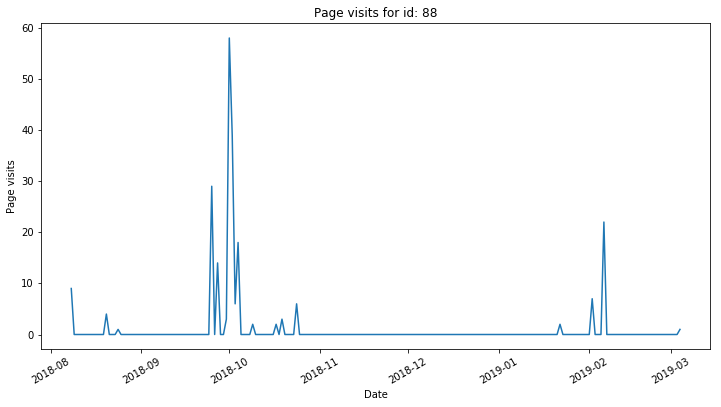

This is the page visit plot for: 239


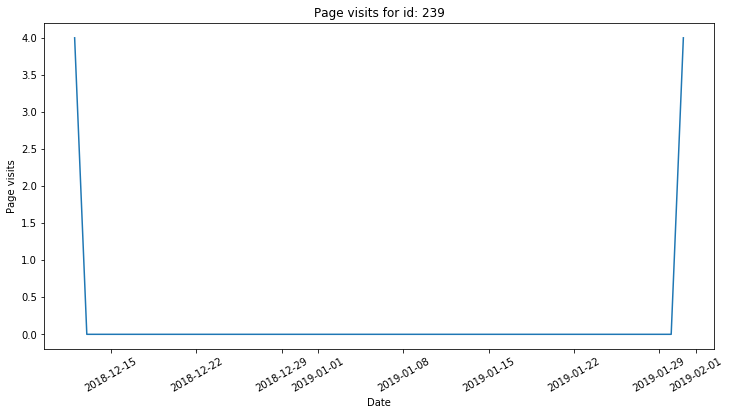

This is the page visit plot for: 96


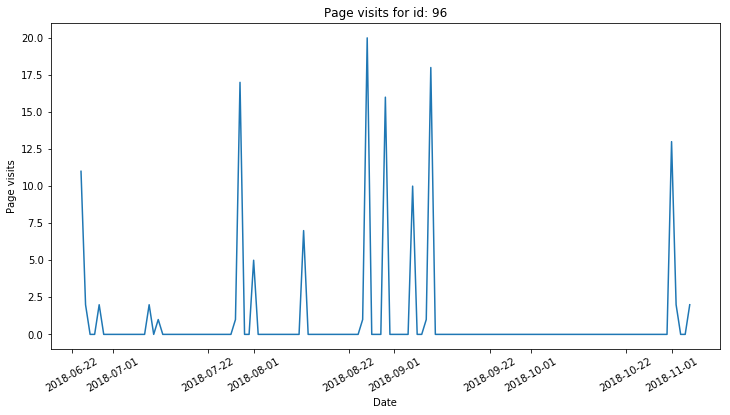

This is the page visit plot for: 189


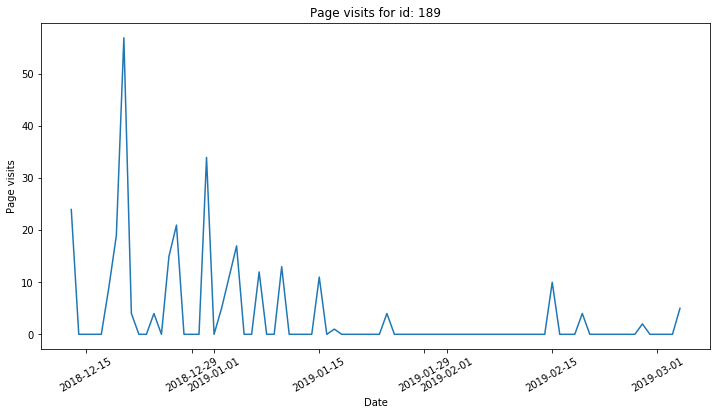

This is the page visit plot for: 155


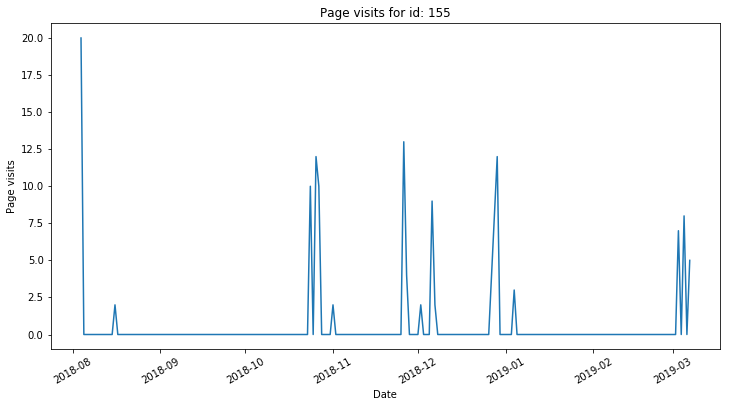

This is the page visit plot for: 7


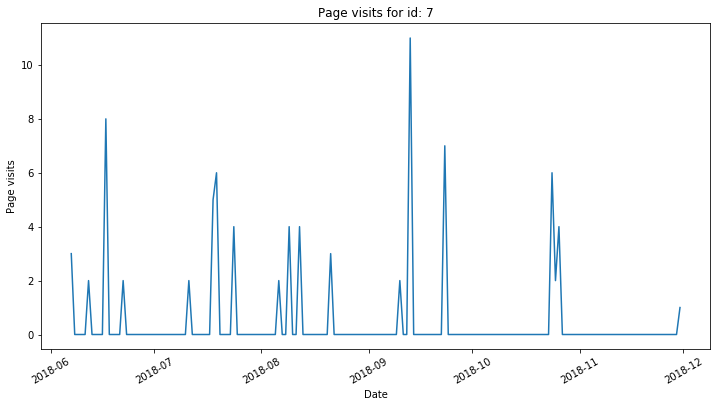

This is the page visit plot for: 146


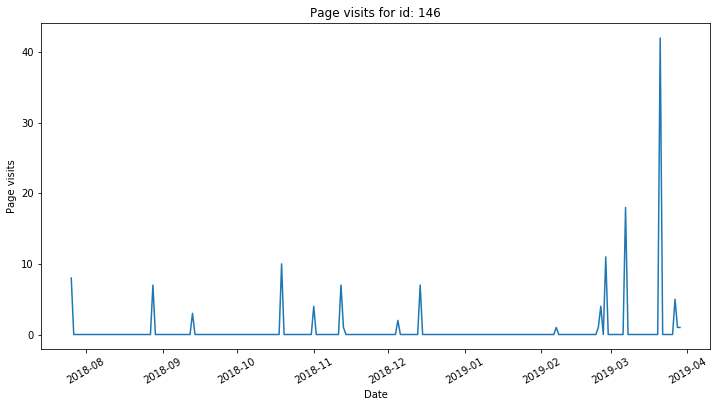

This is the page visit plot for: 157


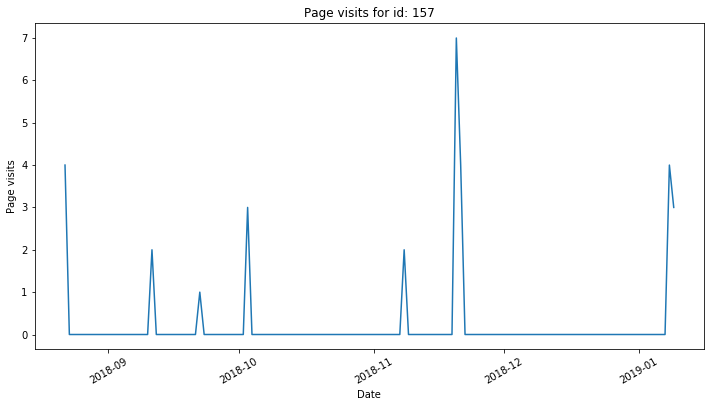

This is the page visit plot for: 119


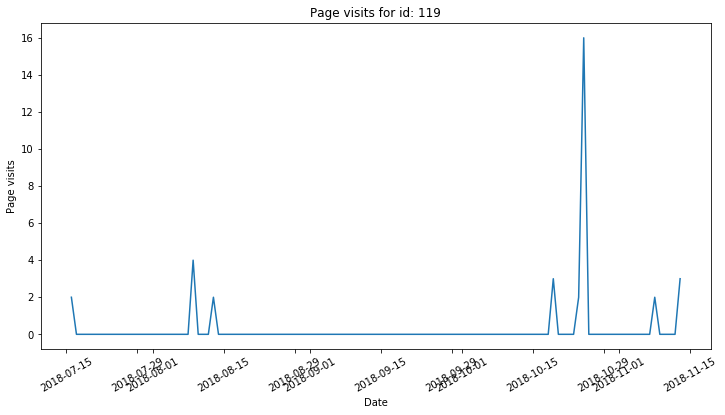

This is the page visit plot for: 50


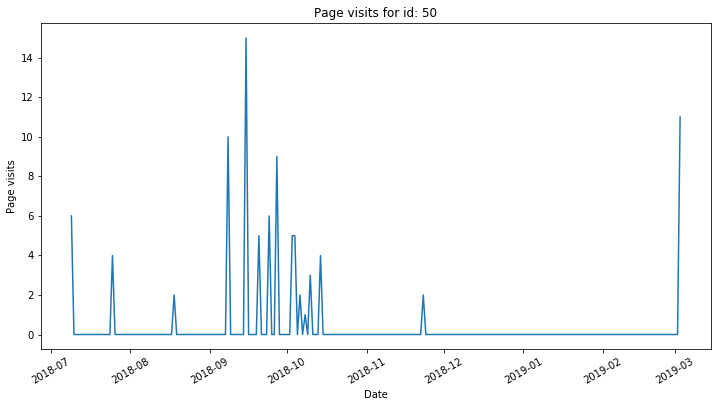

This is the page visit plot for: 116


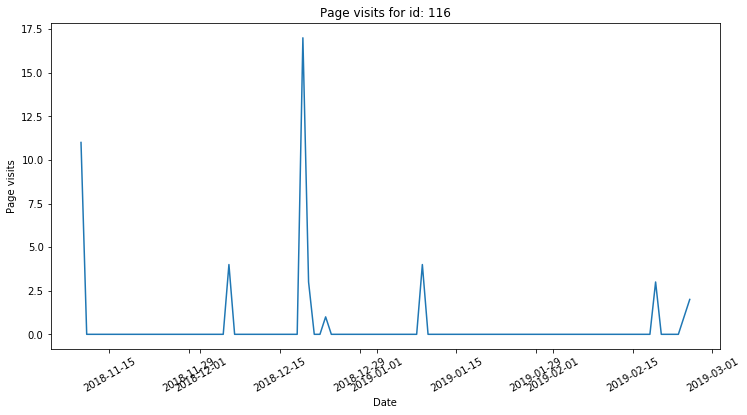

This is the page visit plot for: 197


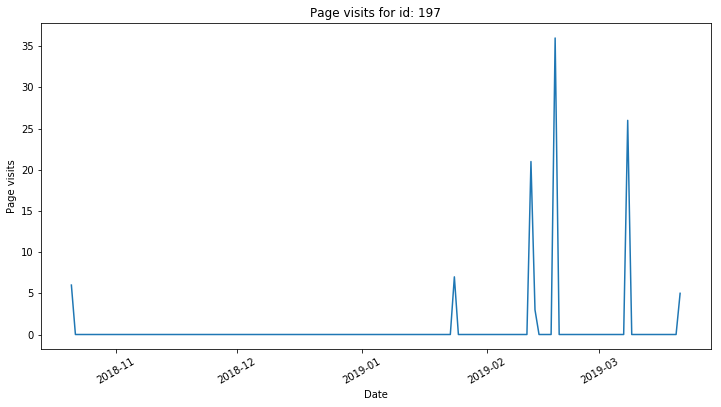

This is the page visit plot for: 164


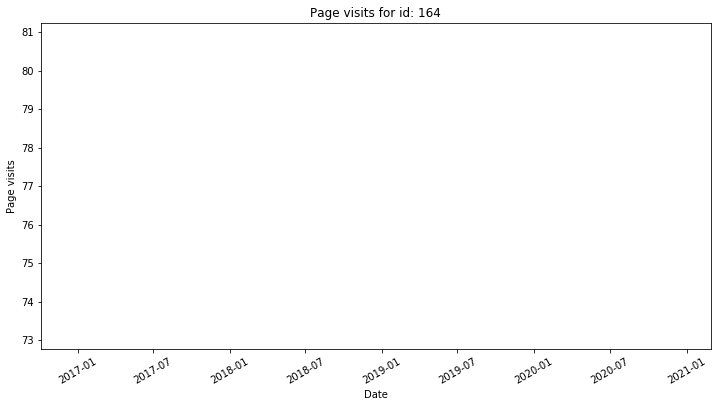

This is the page visit plot for: 58


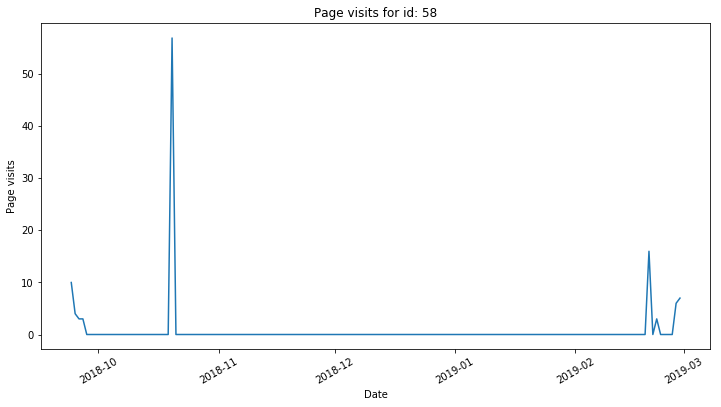

This is the page visit plot for: 160


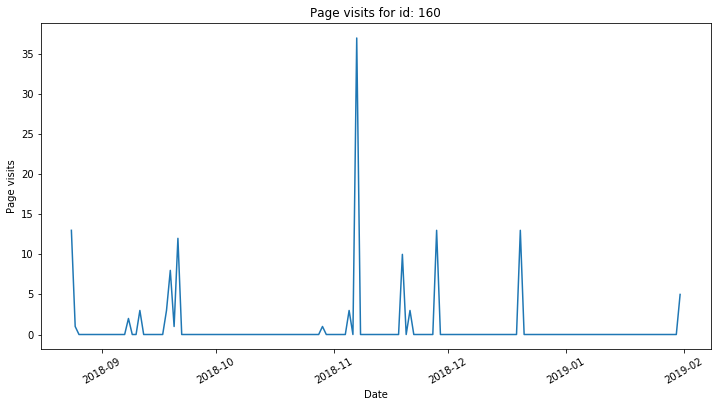

This is the page visit plot for: 185


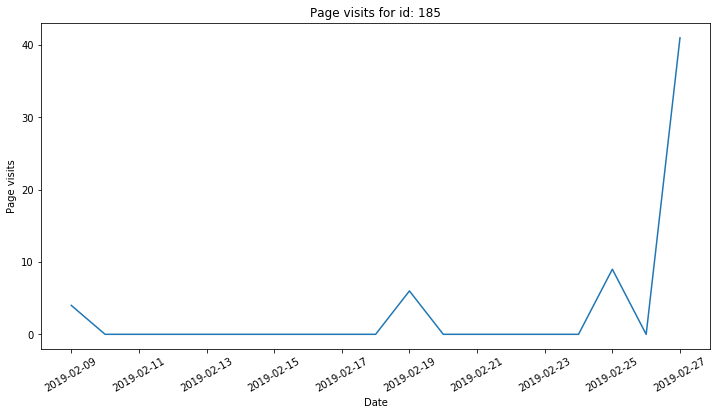

This is the page visit plot for: 36


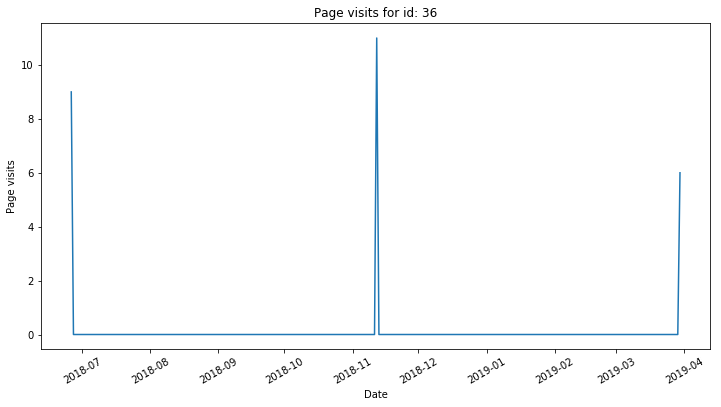

This is the page visit plot for: 111


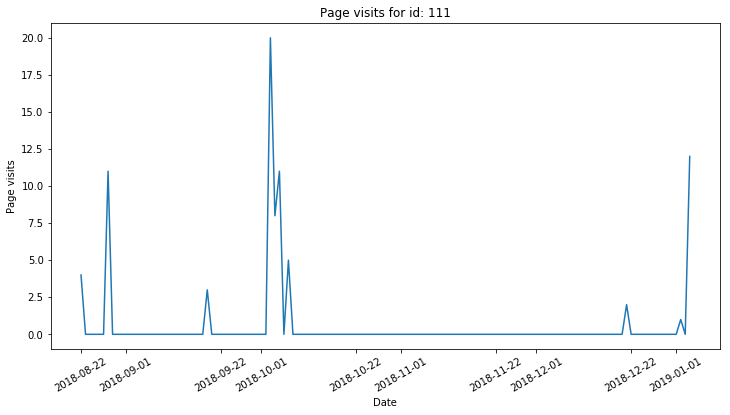

This is the page visit plot for: 41


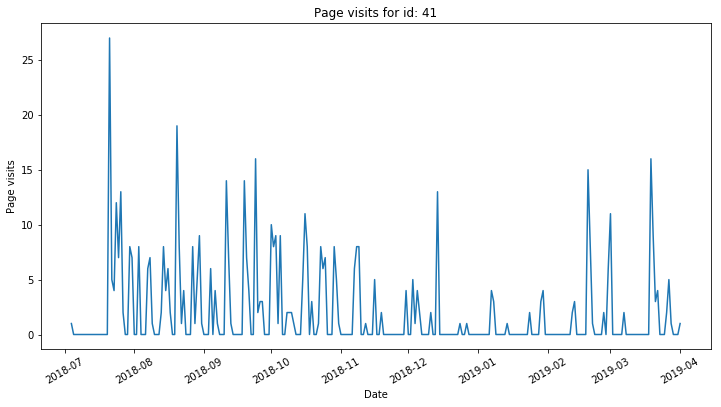

This is the page visit plot for: 131


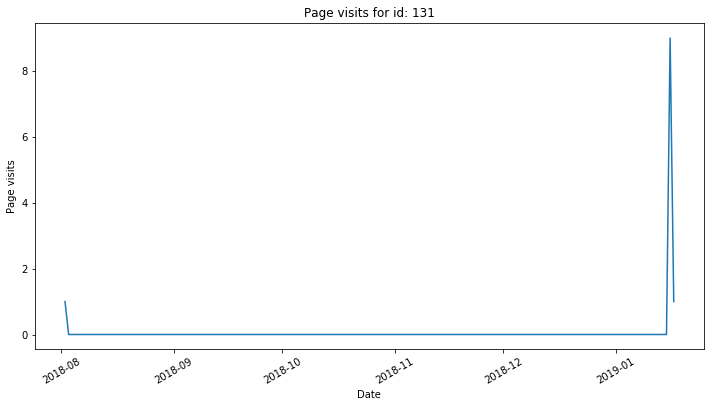

This is the page visit plot for: 54


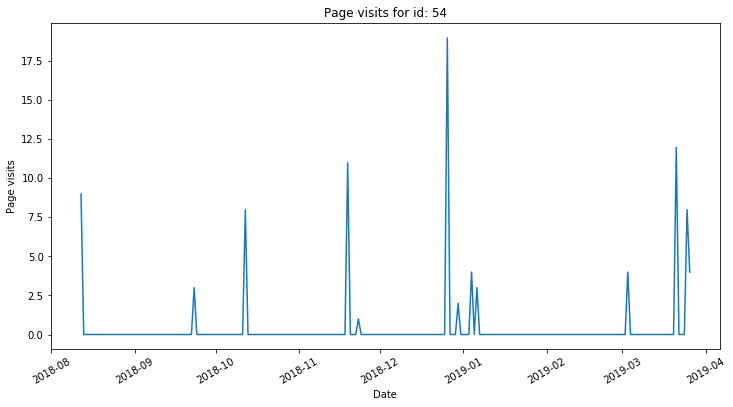

This is the page visit plot for: 123


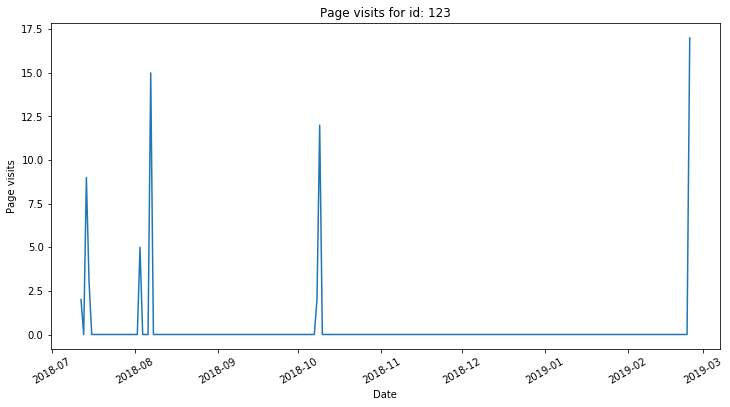

This is the page visit plot for: 6


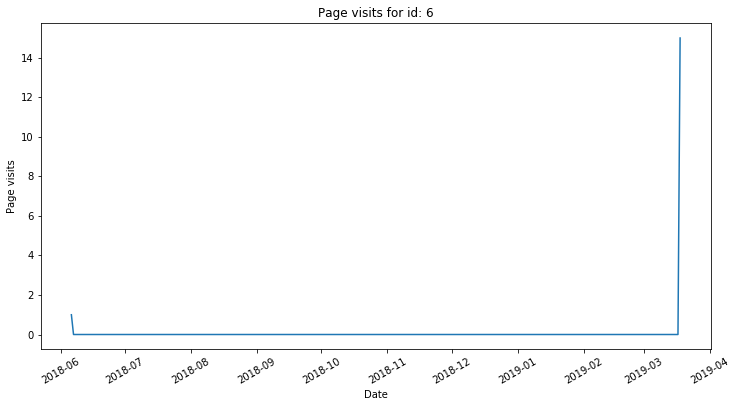

This is the page visit plot for: 167


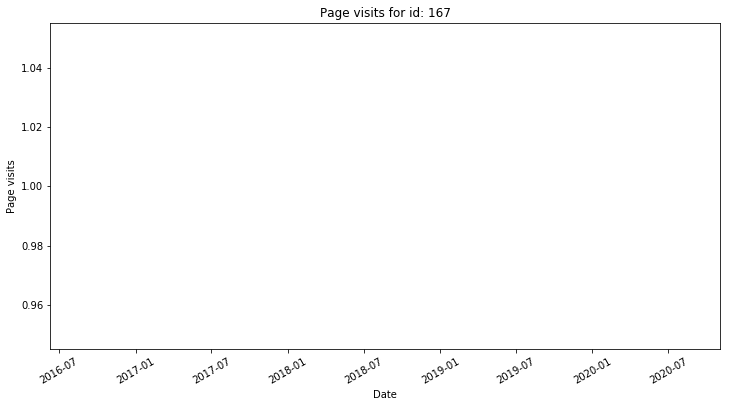

This is the page visit plot for: 308


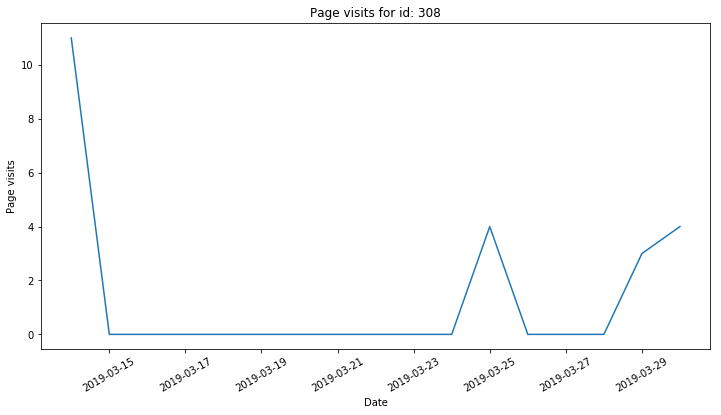

This is the page visit plot for: 220


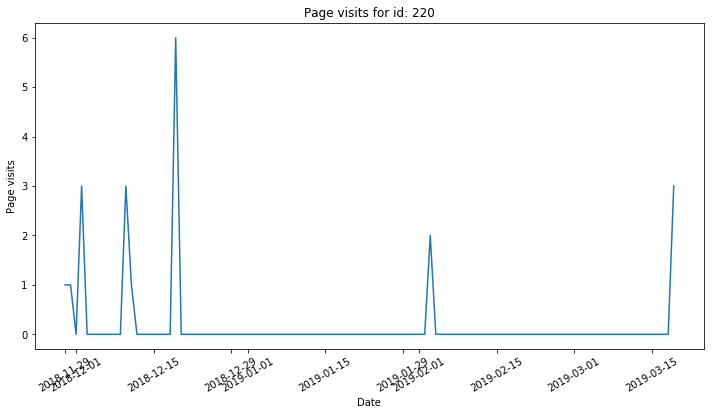

This is the page visit plot for: 201


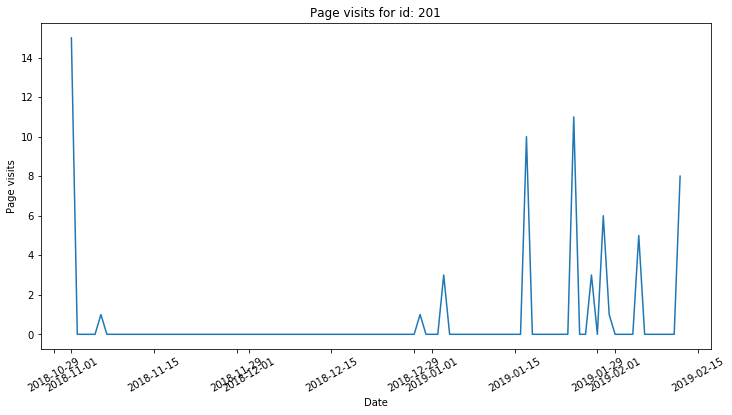

This is the page visit plot for: 305


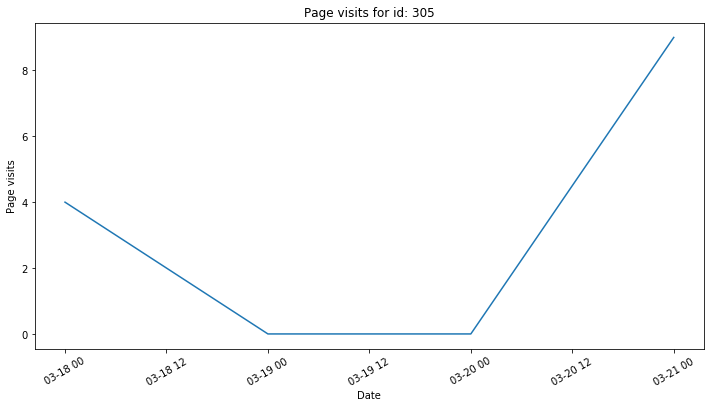

This is the page visit plot for: 118


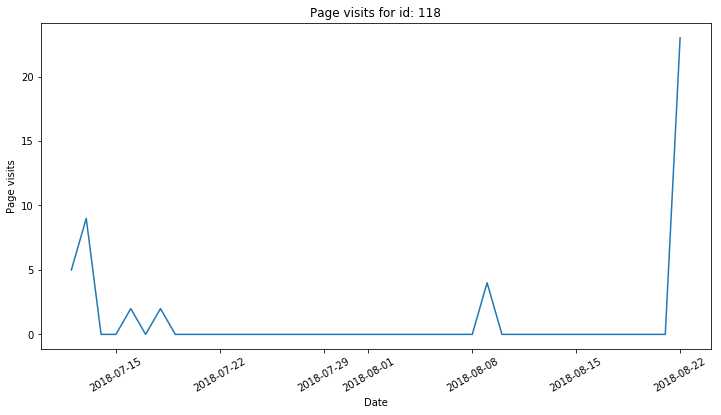

This is the page visit plot for: 79


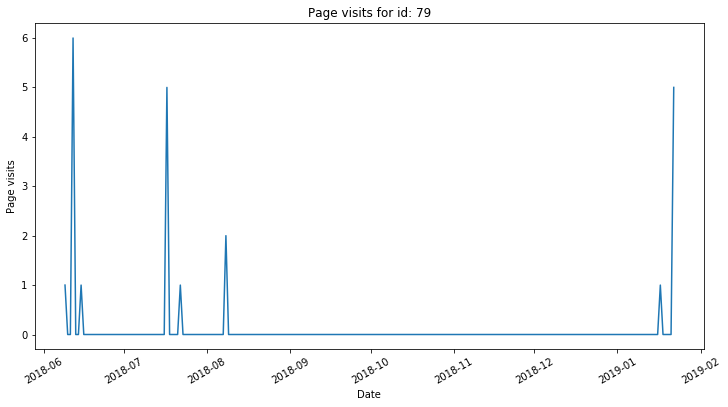

This is the page visit plot for: 27


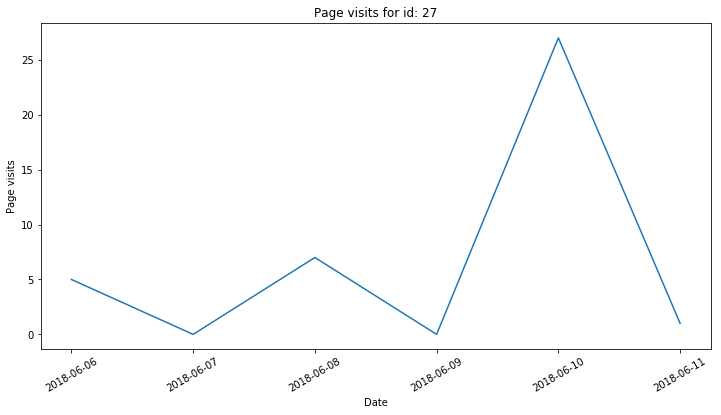

This is the page visit plot for: 56


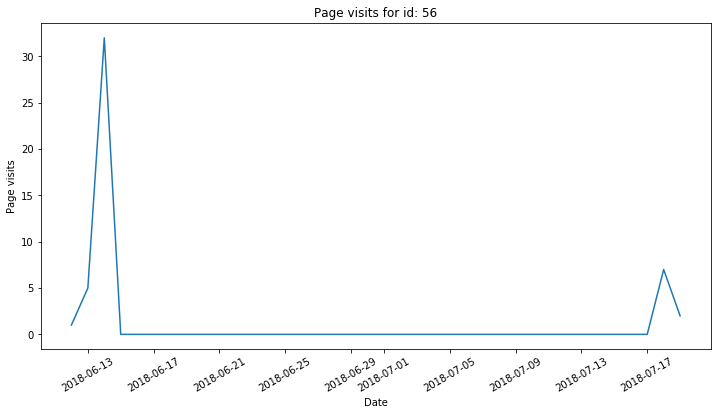

This is the page visit plot for: 138


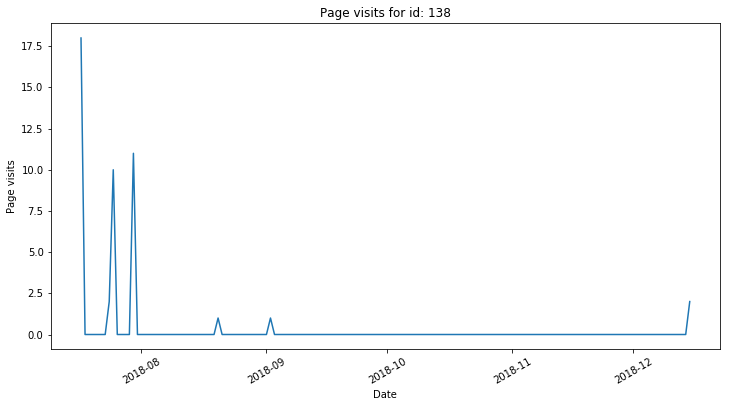

This is the page visit plot for: 260


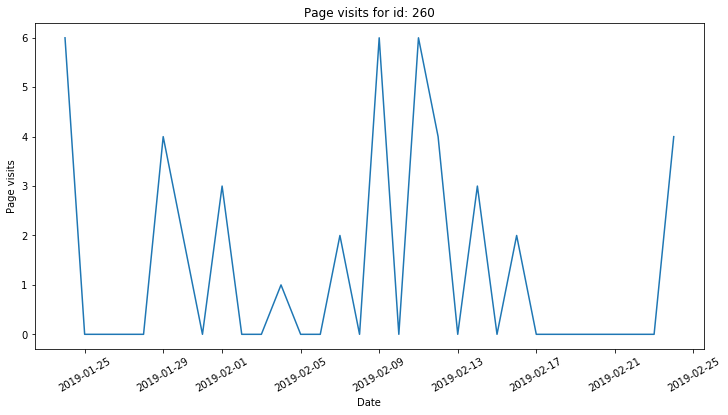

This is the page visit plot for: 294


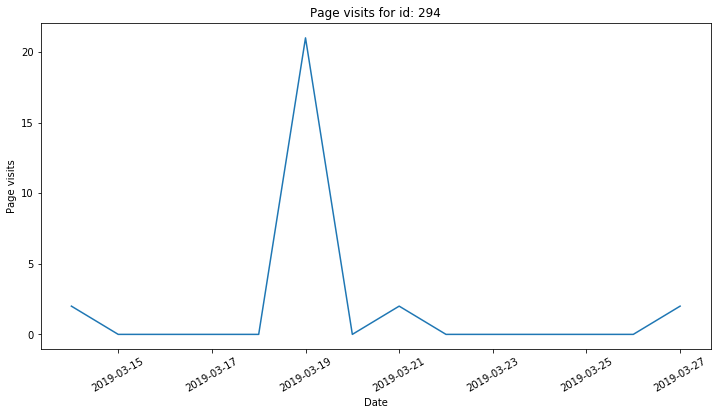

This is the page visit plot for: 307


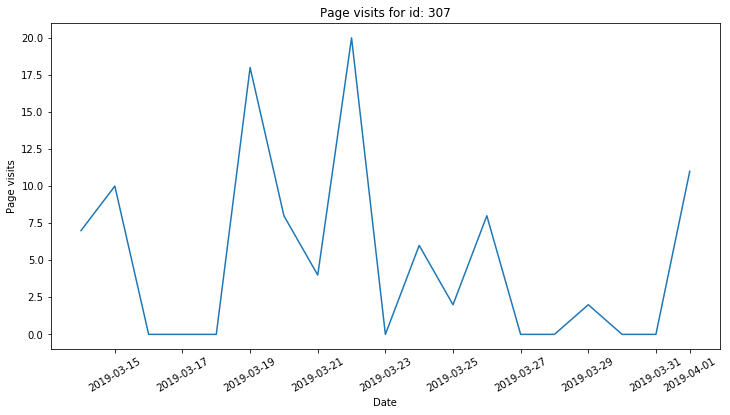

This is the page visit plot for: 230


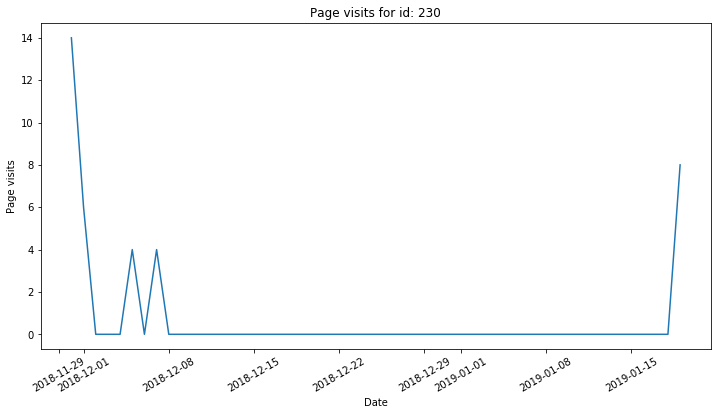

This is the page visit plot for: 295


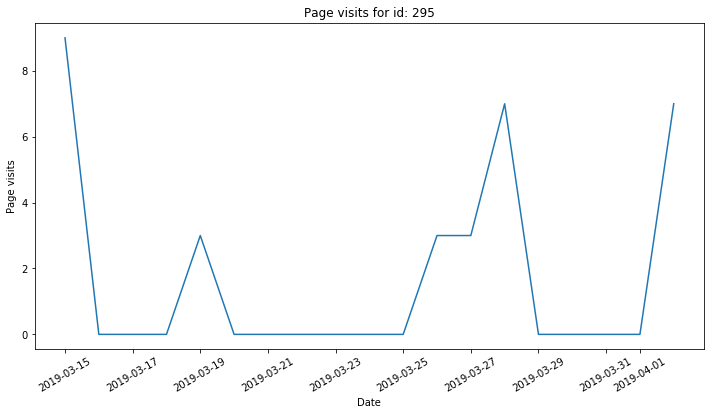

This is the page visit plot for: 296


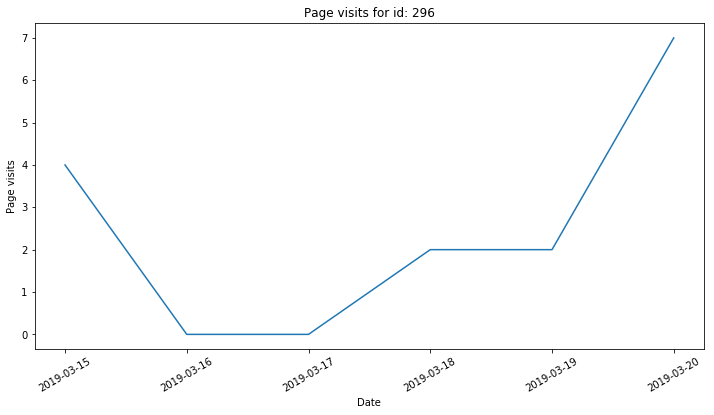

This is the page visit plot for: 124


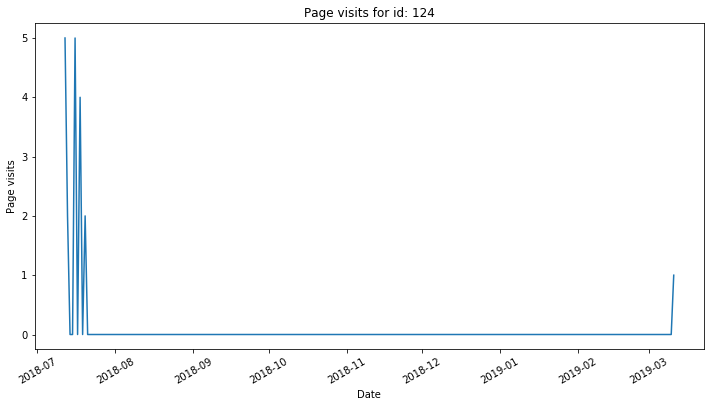

This is the page visit plot for: 278


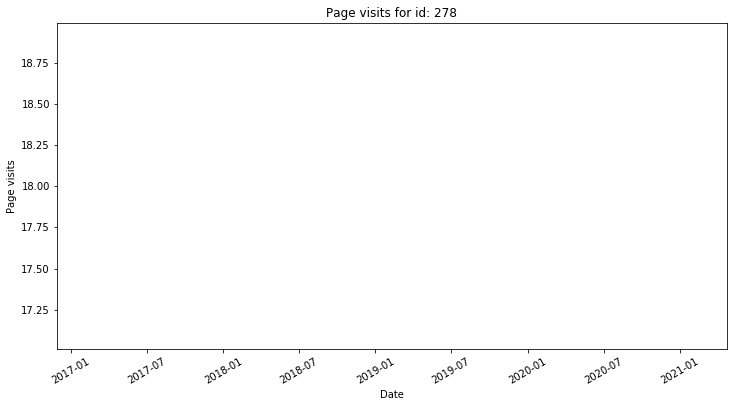

This is the page visit plot for: 306


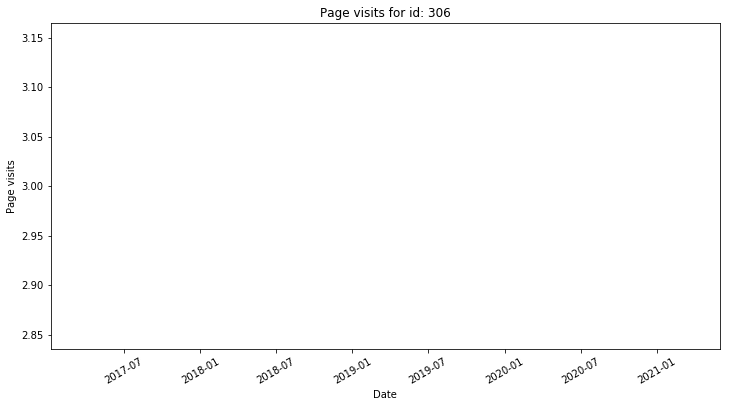

This is the page visit plot for: 136


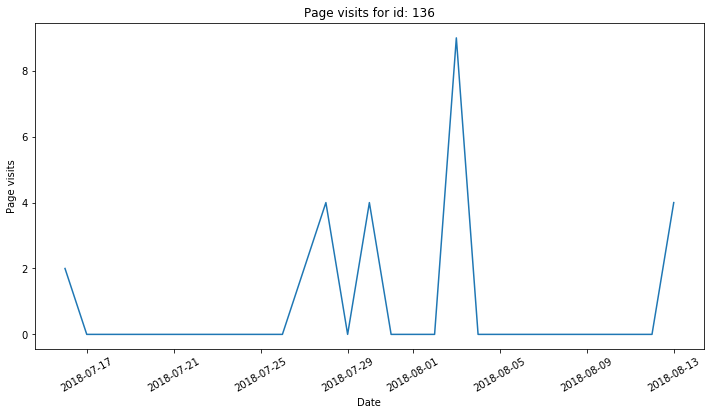

This is the page visit plot for: 290


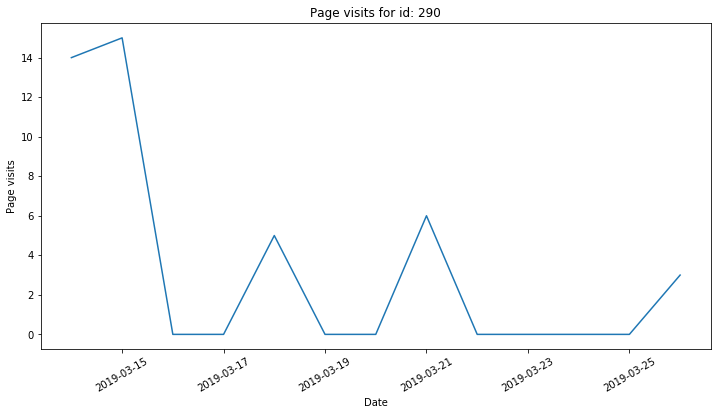

This is the page visit plot for: 267


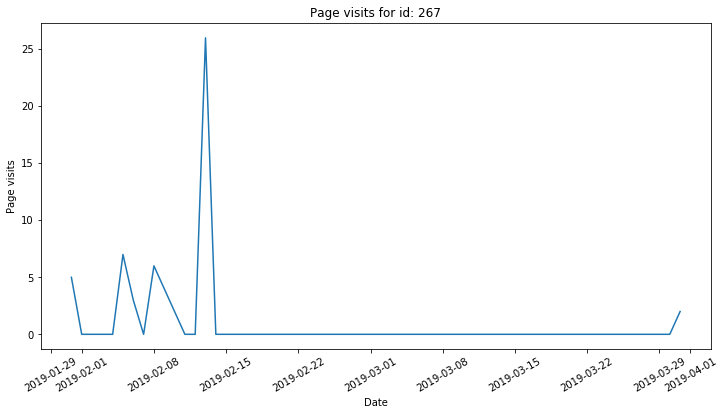

This is the page visit plot for: 183


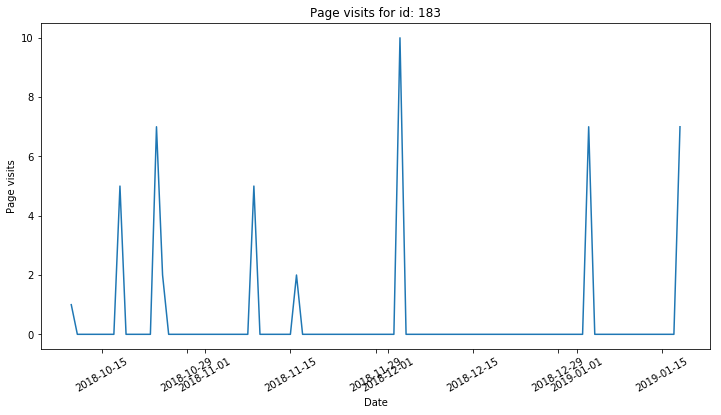

This is the page visit plot for: 215


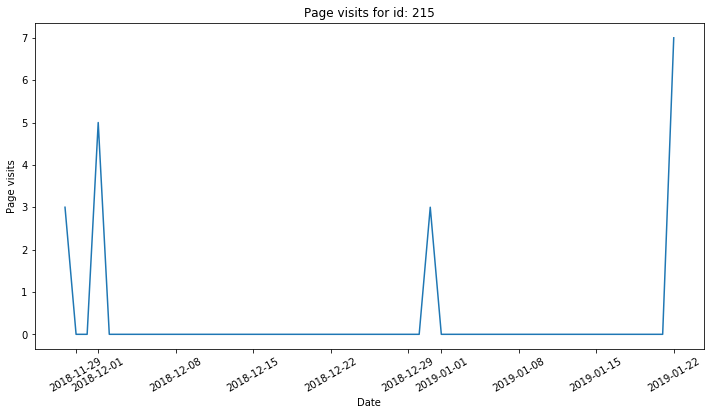

This is the page visit plot for: 5


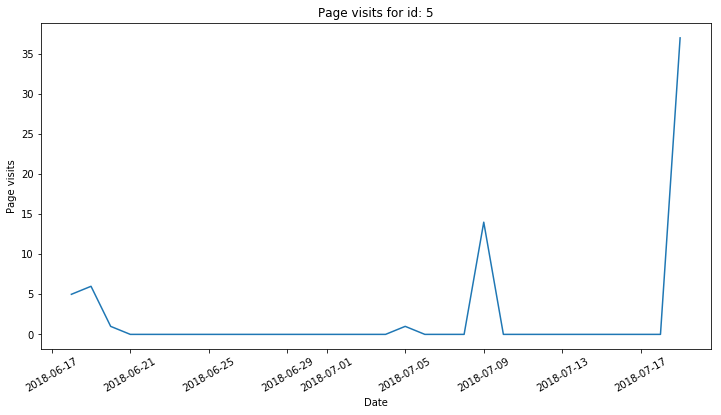

This is the page visit plot for: 254


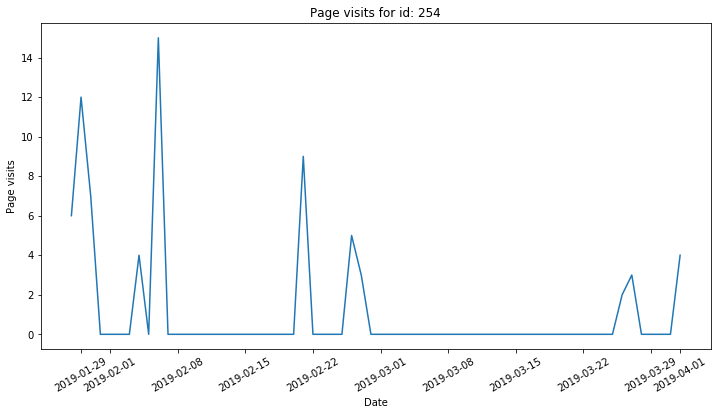

This is the page visit plot for: 21


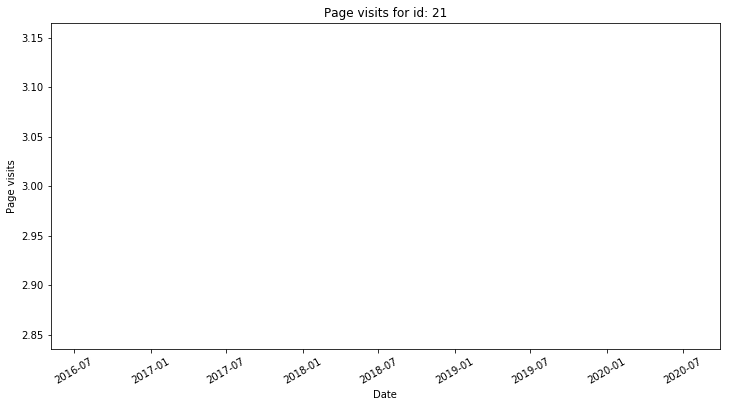

This is the page visit plot for: 238


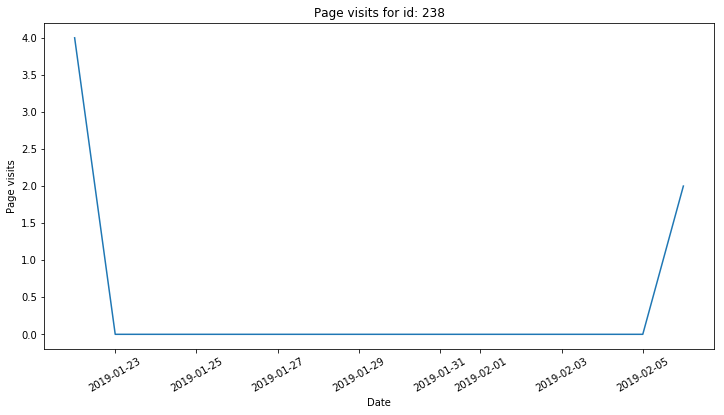

This is the page visit plot for: 15


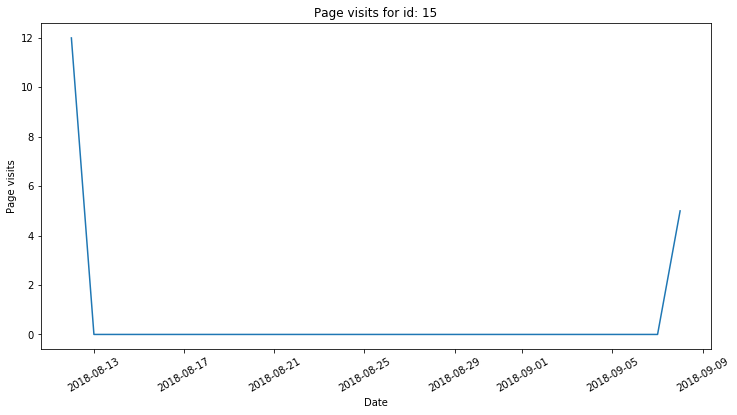

This is the page visit plot for: 18


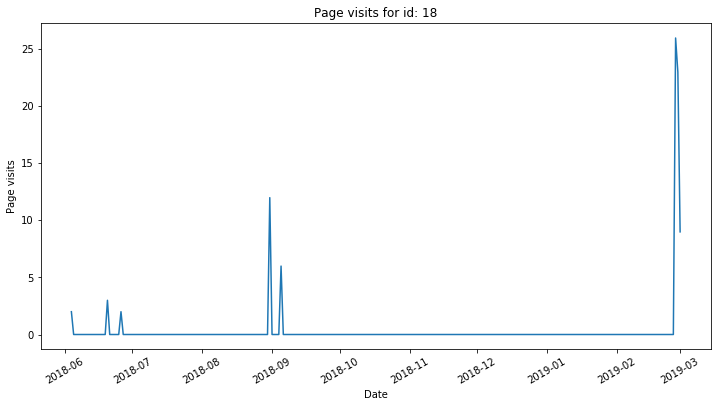

This is the page visit plot for: 226


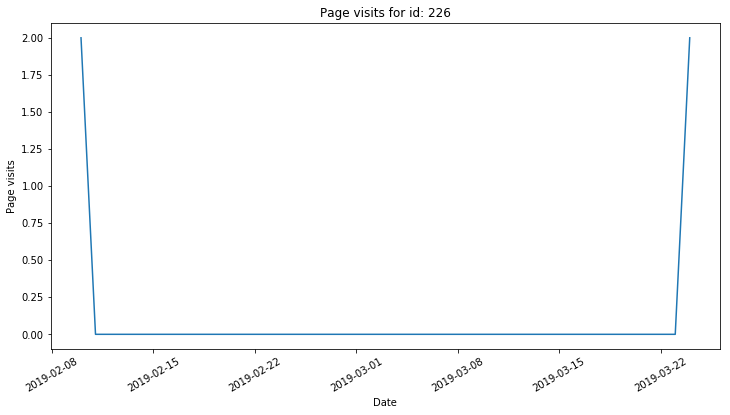

This is the page visit plot for: 83


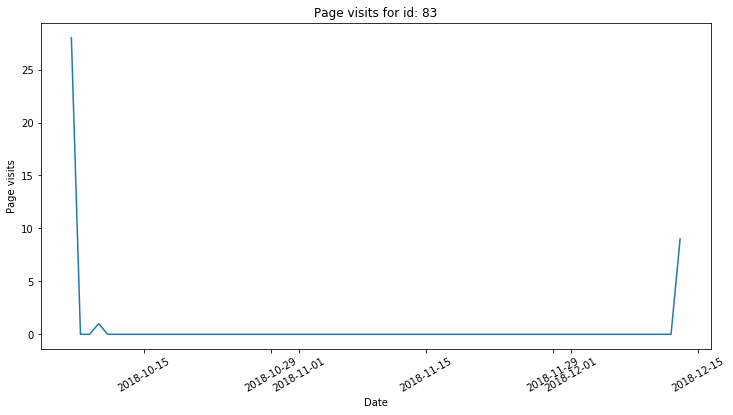

This is the page visit plot for: 67


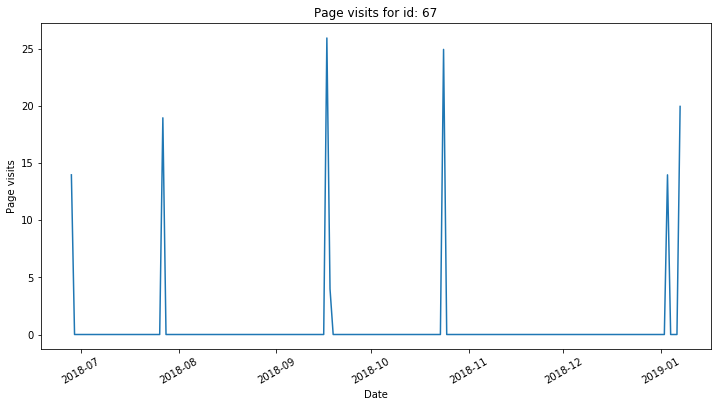

This is the page visit plot for: 48


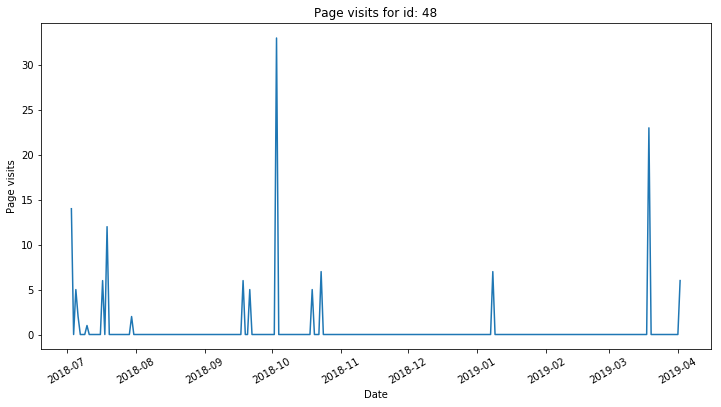

This is the page visit plot for: 51


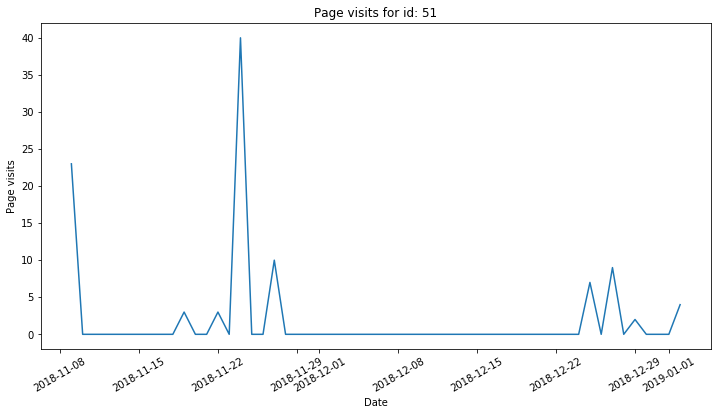

This is the page visit plot for: 33


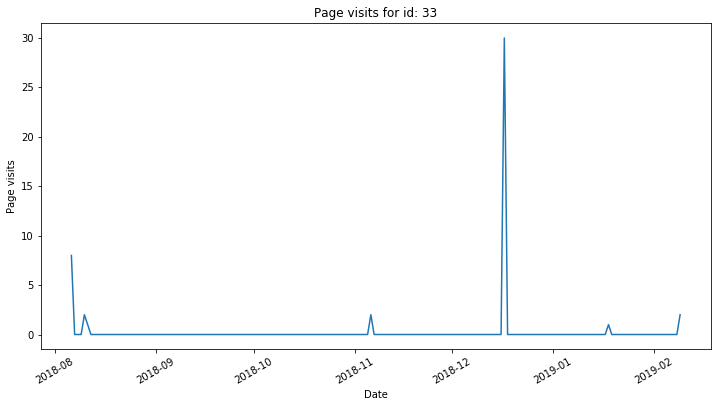

This is the page visit plot for: 153


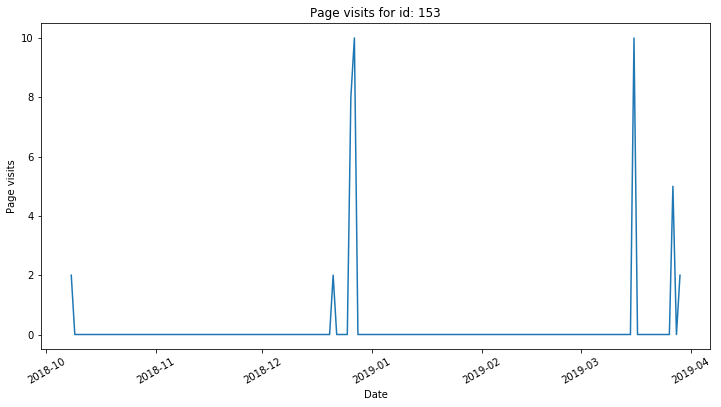

This is the page visit plot for: 126


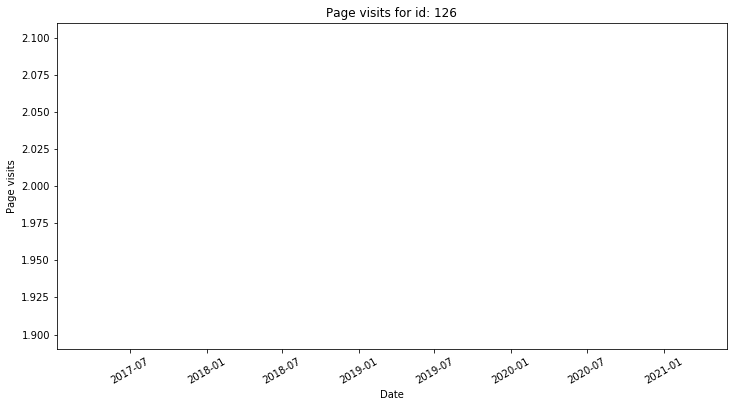

This is the page visit plot for: 121


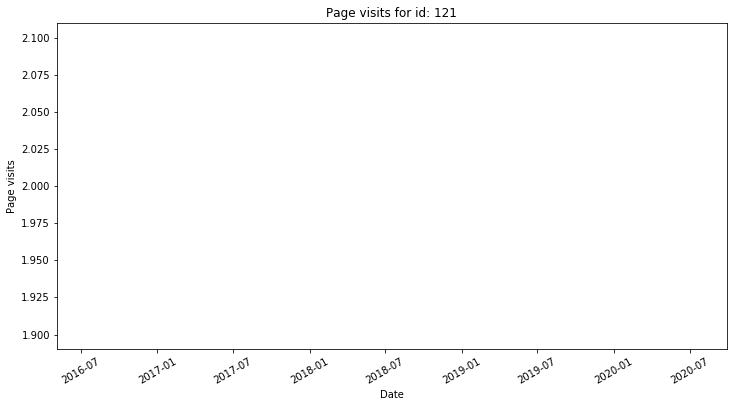

This is the page visit plot for: 297


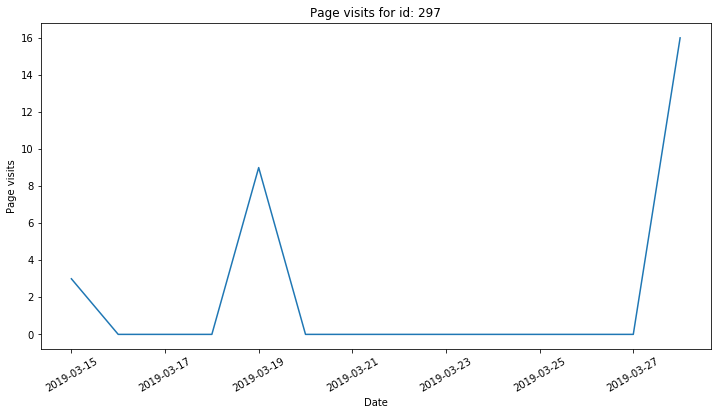

This is the page visit plot for: 265


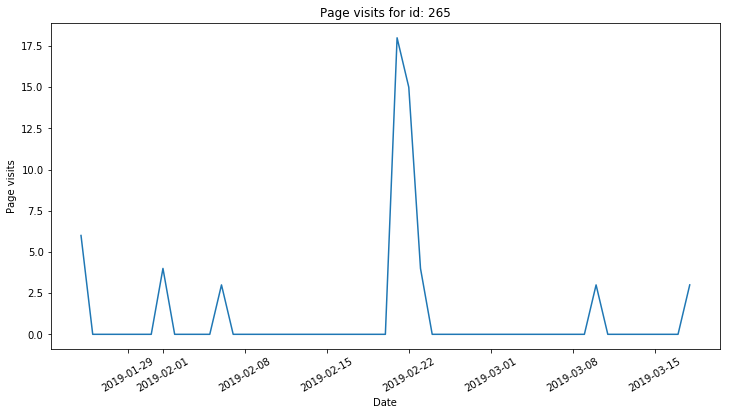

This is the page visit plot for: 289


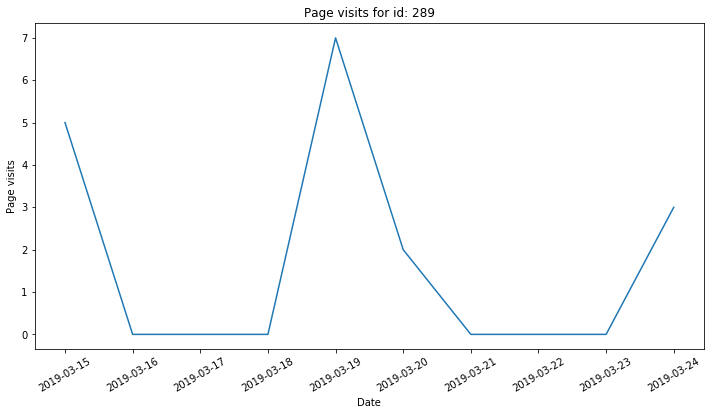

This is the page visit plot for: 309


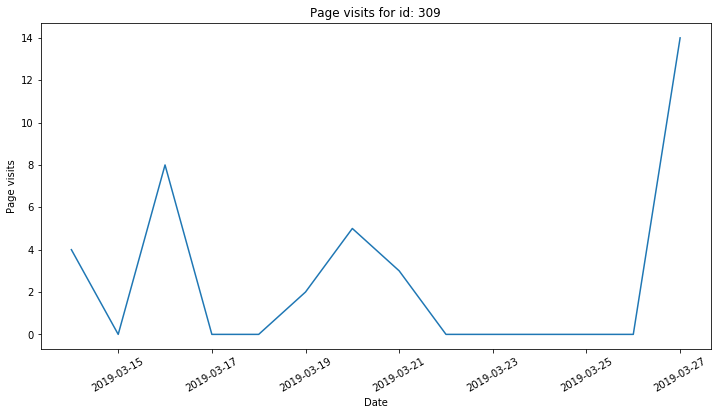

This is the page visit plot for: 78


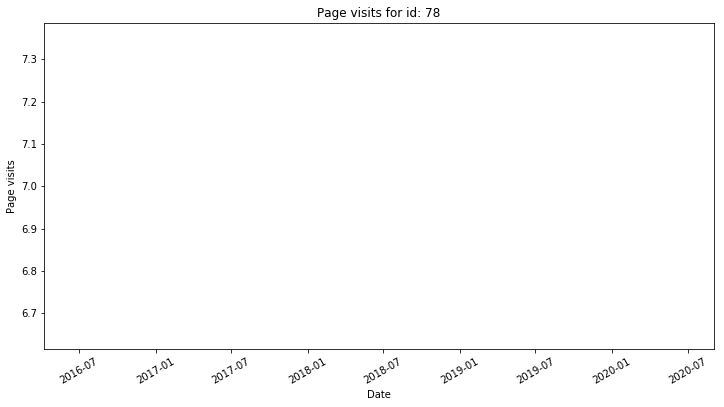

This is the page visit plot for: 223


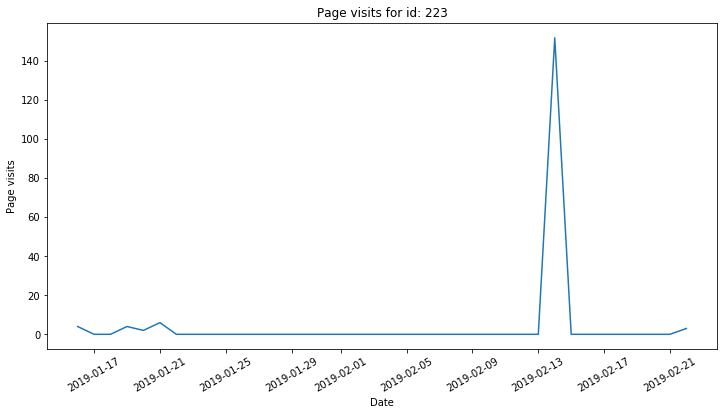

This is the page visit plot for: 12


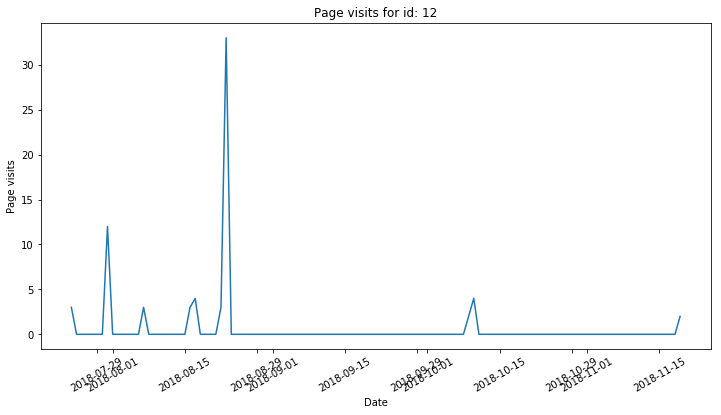

This is the page visit plot for: 75


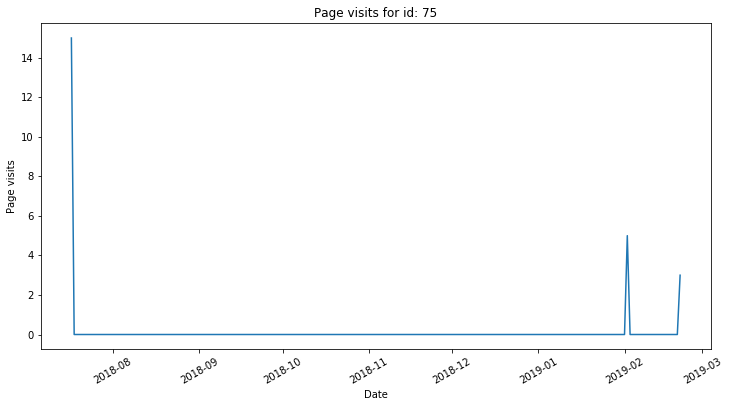

This is the page visit plot for: 304


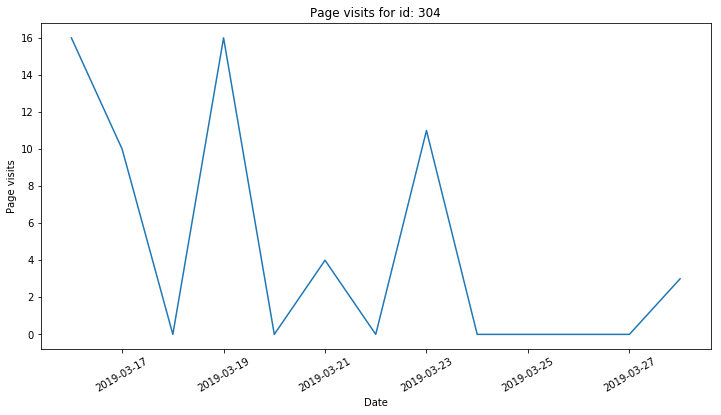

This is the page visit plot for: 60


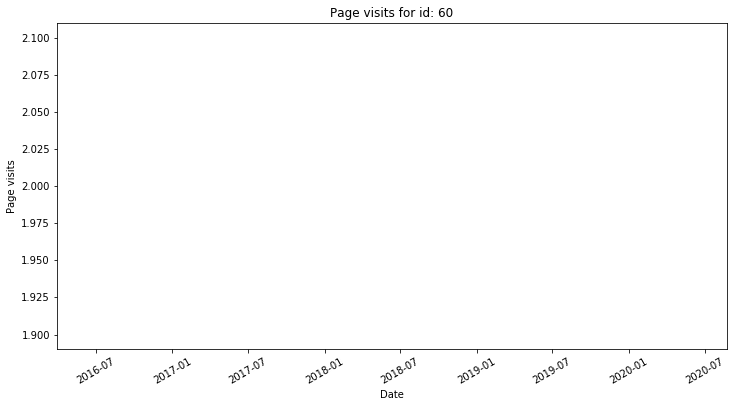

This is the page visit plot for: 227


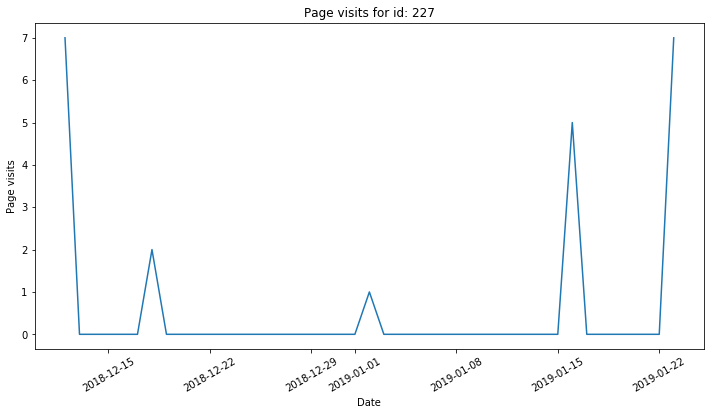

This is the page visit plot for: 159


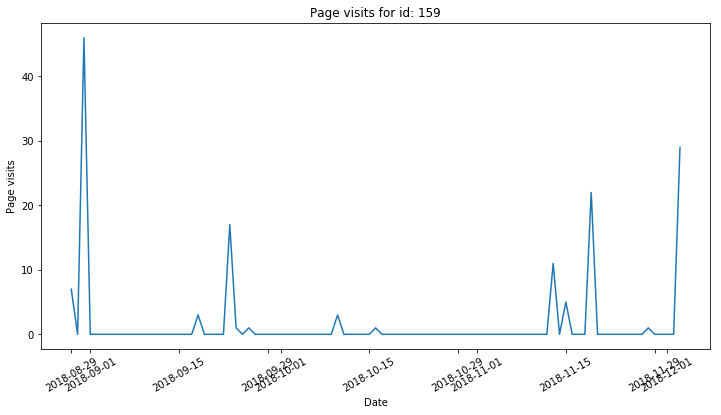

This is the page visit plot for: 284


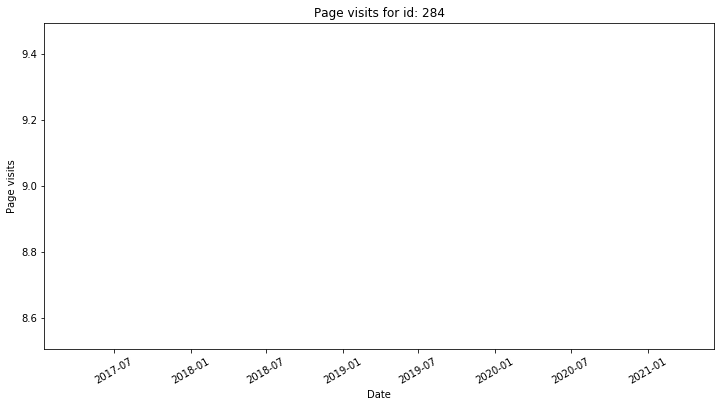

This is the page visit plot for: 65


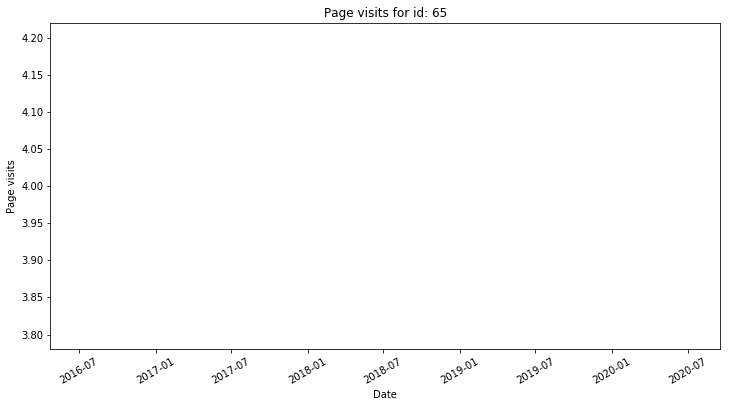

This is the page visit plot for: 16


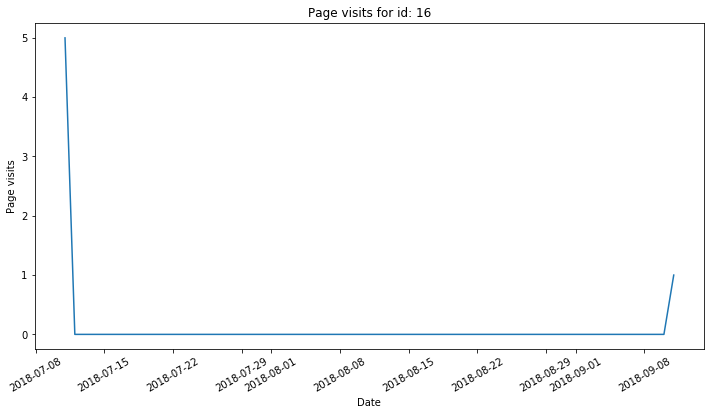

This is the page visit plot for: 181


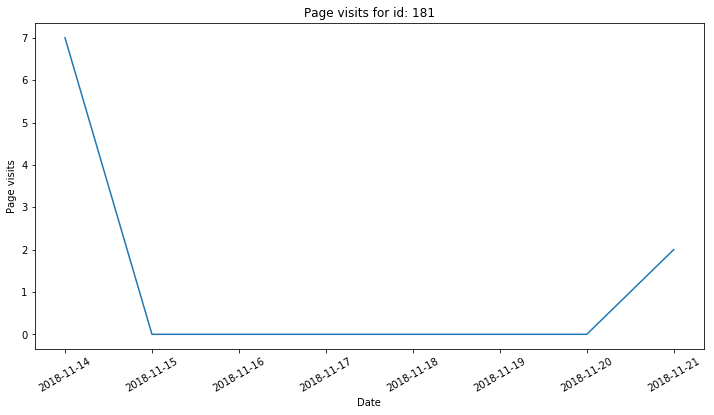

This is the page visit plot for: 98


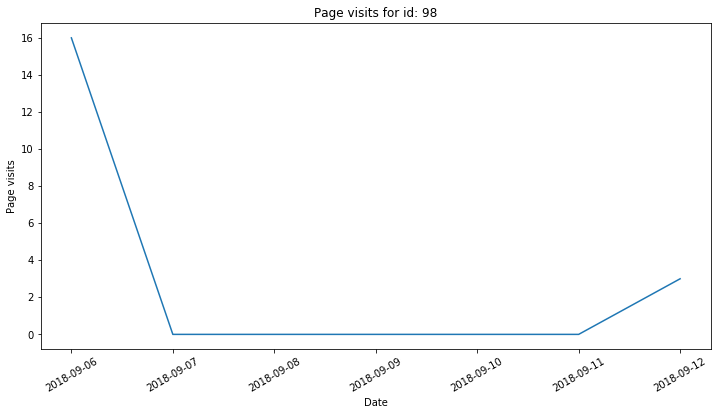

This is the page visit plot for: 38


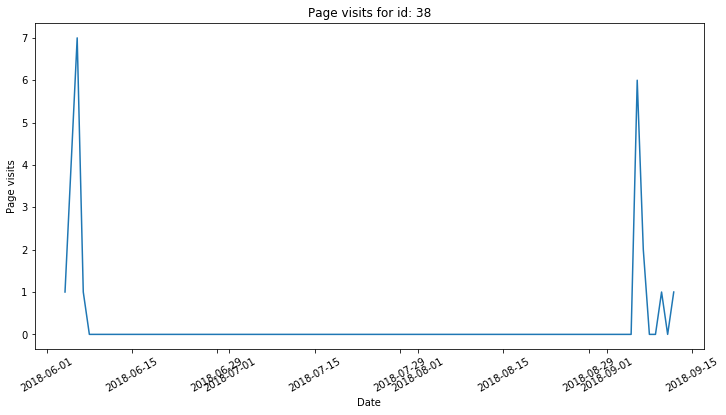

This is the page visit plot for: 231


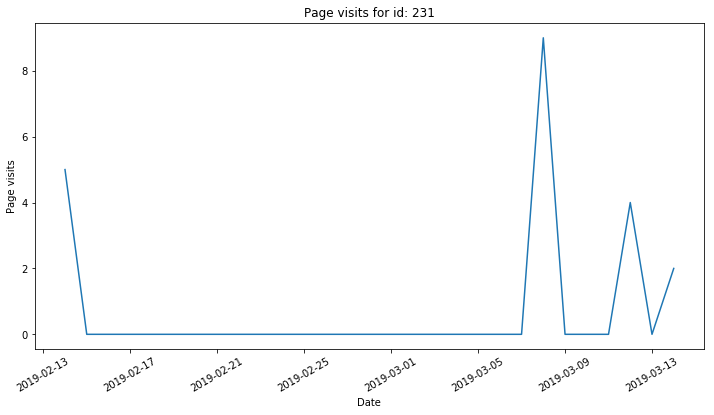

This is the page visit plot for: 170


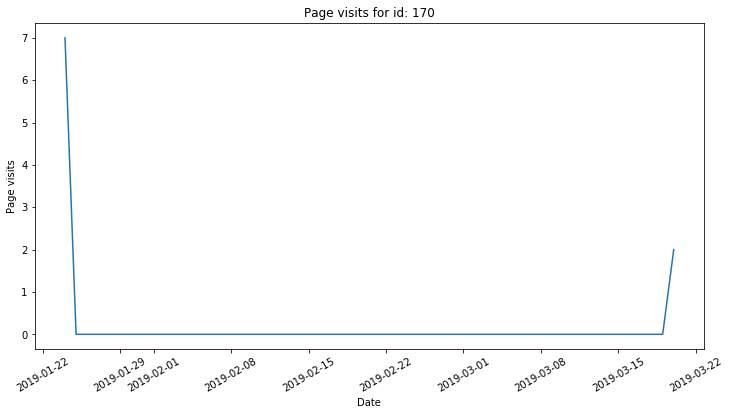

This is the page visit plot for: 120


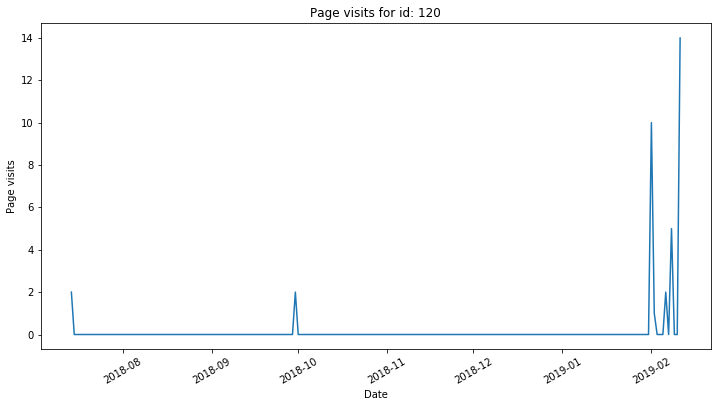

This is the page visit plot for: 168


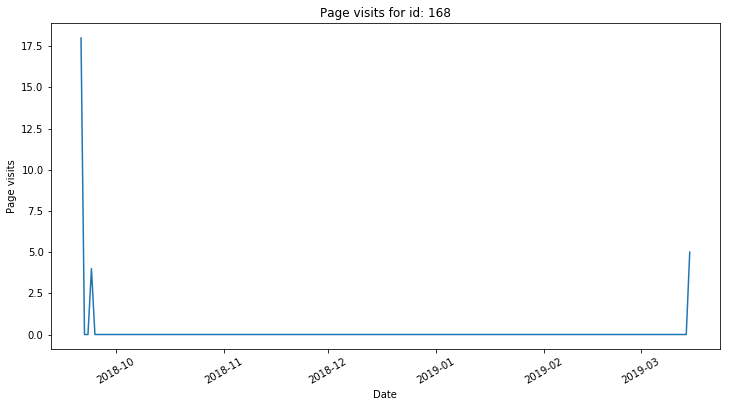

This is the page visit plot for: 105


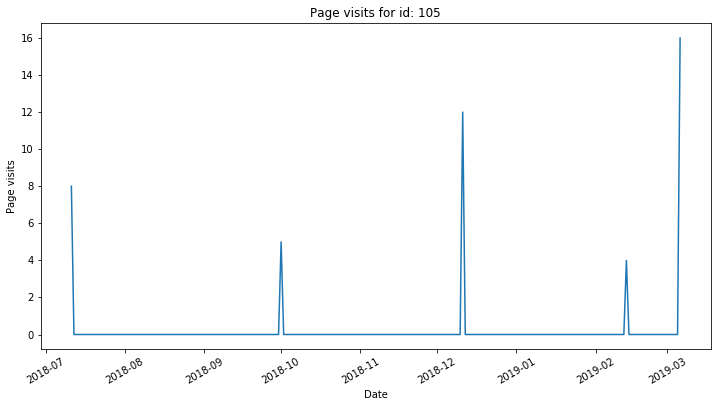

This is the page visit plot for: 282


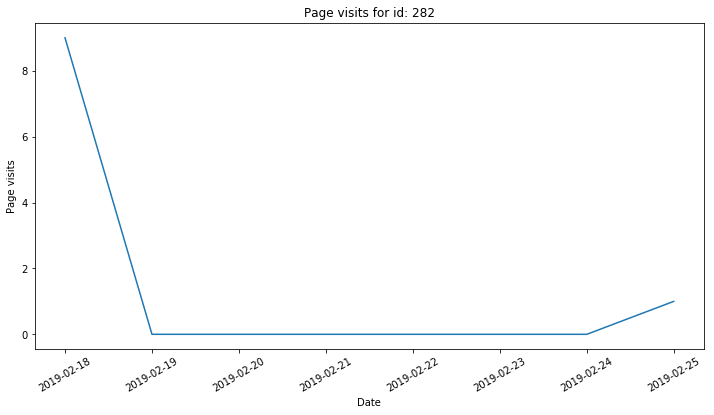

This is the page visit plot for: 228


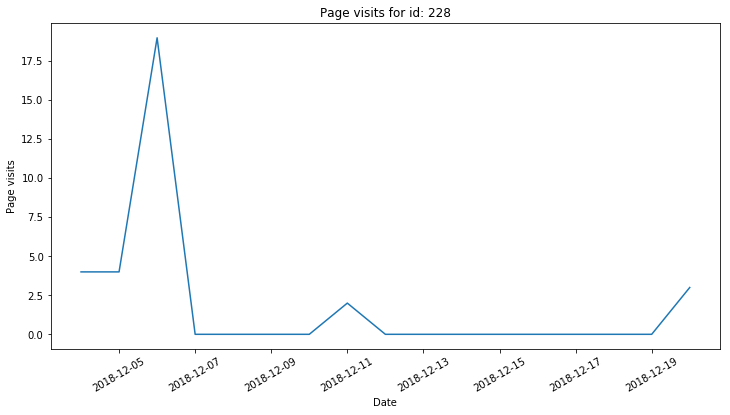

This is the page visit plot for: 302


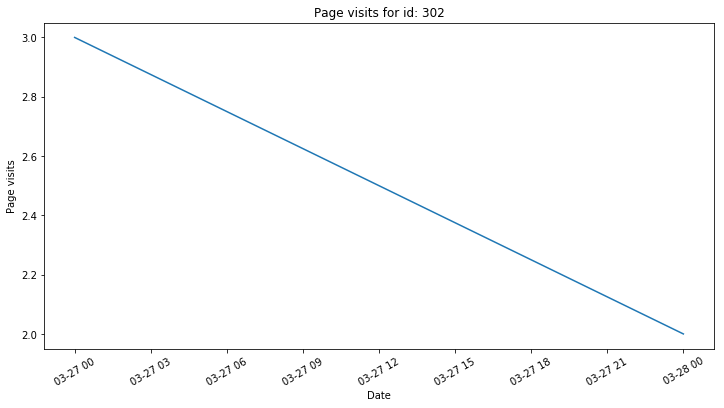

This is the page visit plot for: 19


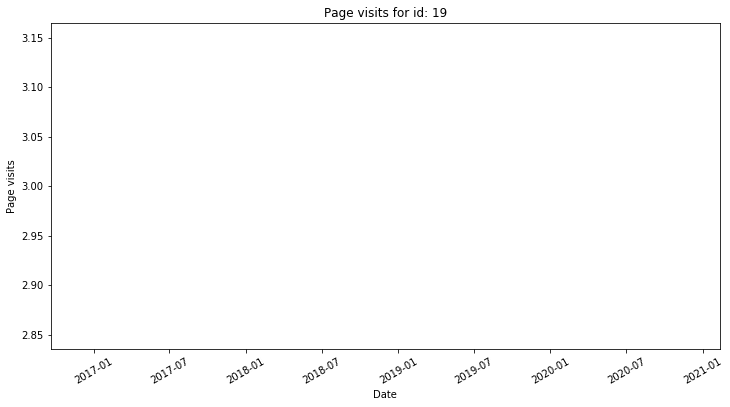

This is the page visit plot for: 225


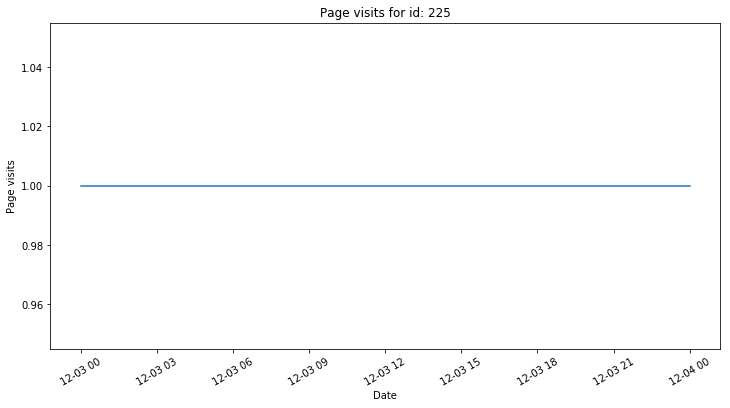

This is the page visit plot for: 204


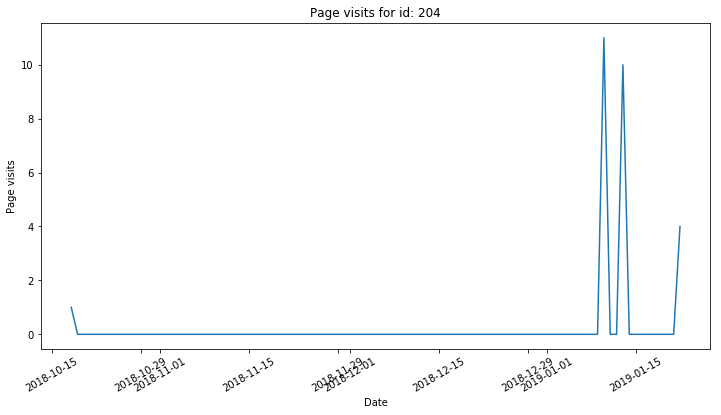

This is the page visit plot for: 292


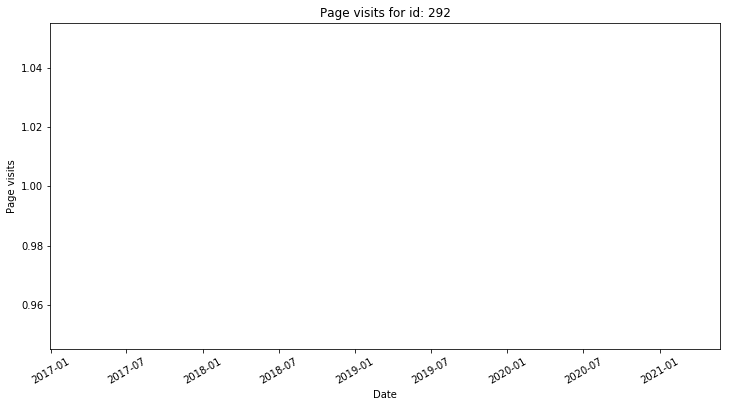

This is the page visit plot for: 281


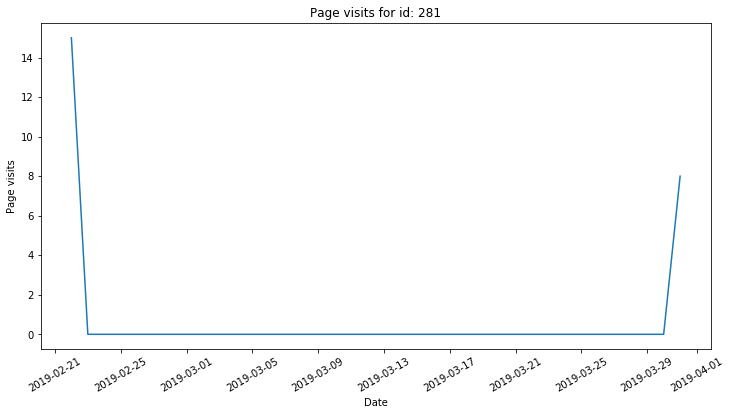

This is the page visit plot for: 200


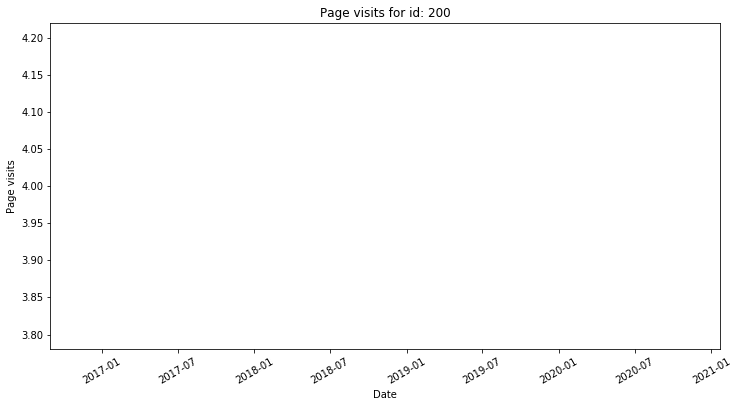

This is the page visit plot for: 80


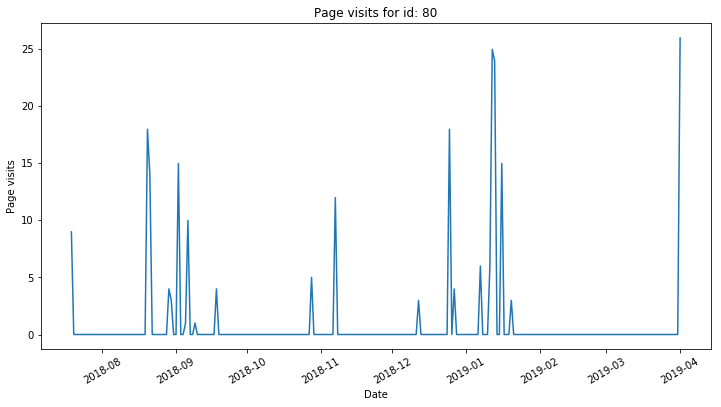

This is the page visit plot for: 217


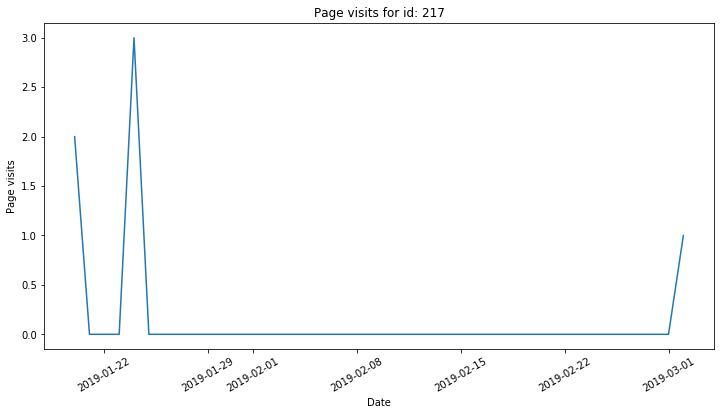

This is the page visit plot for: 234


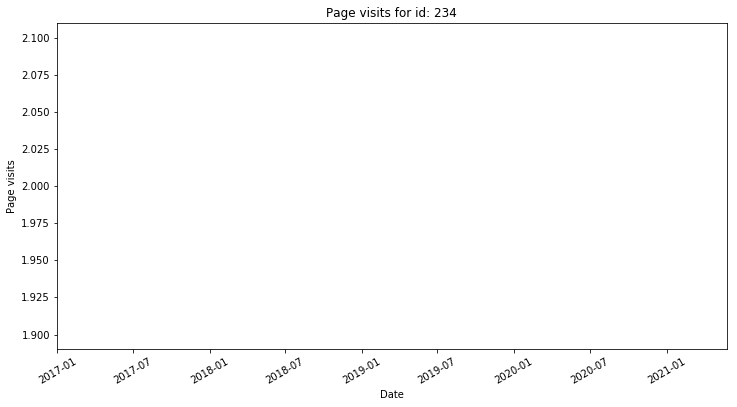

This is the page visit plot for: 162


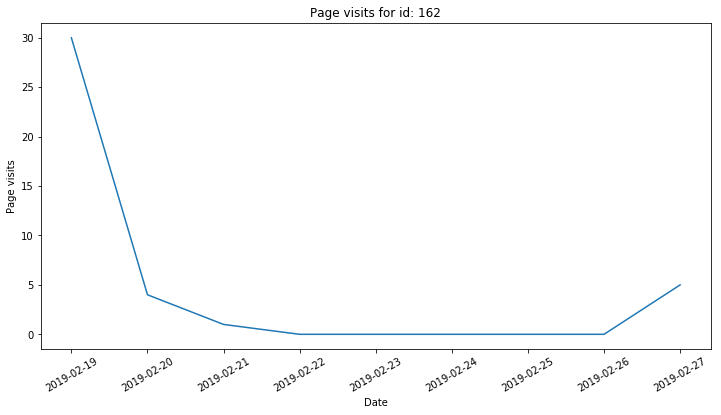

This is the page visit plot for: 208


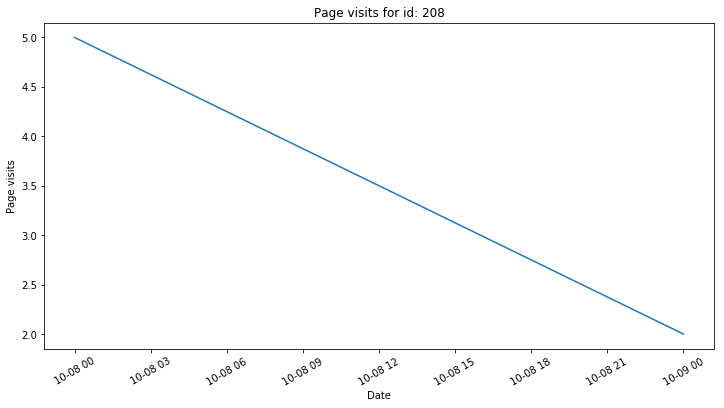

This is the page visit plot for: 148


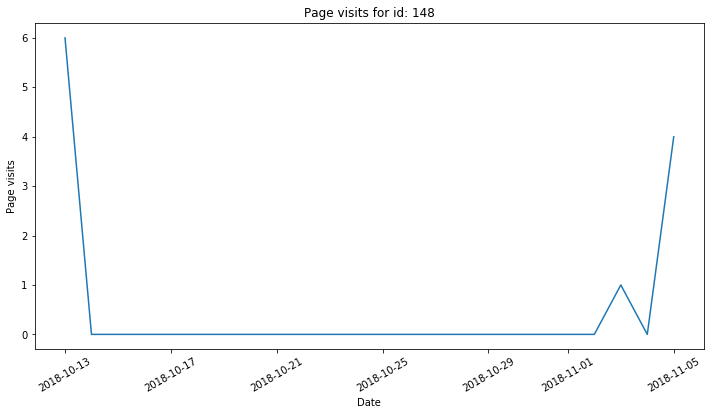

This is the page visit plot for: 156


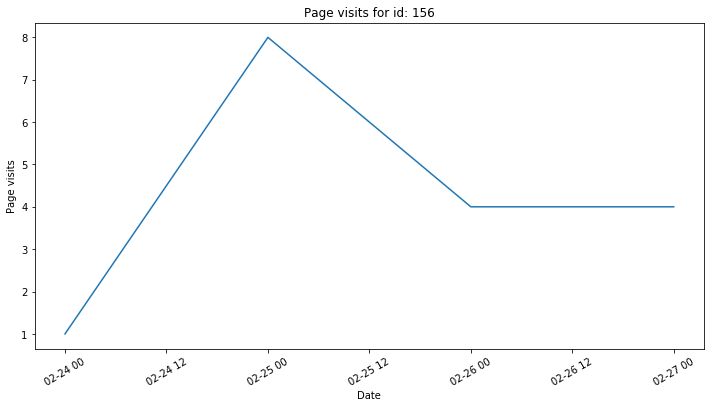

This is the page visit plot for: 219


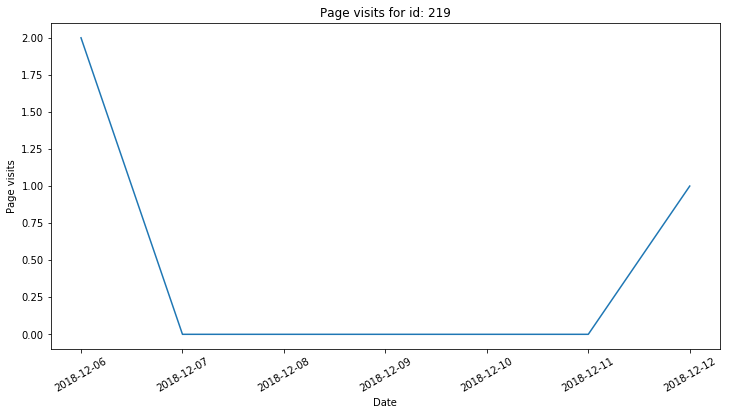

This is the page visit plot for: 14


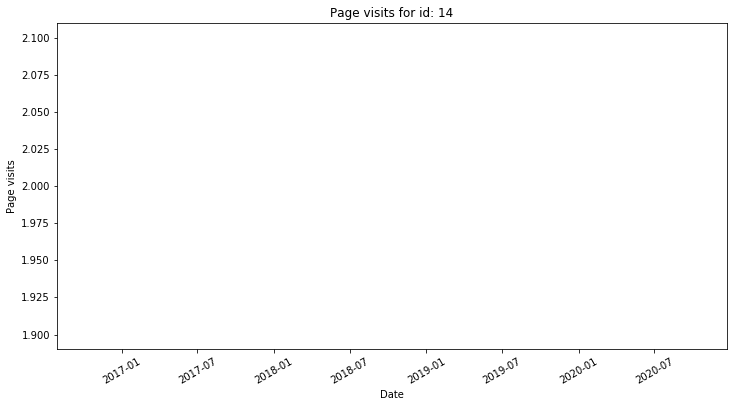

This is the page visit plot for: 240


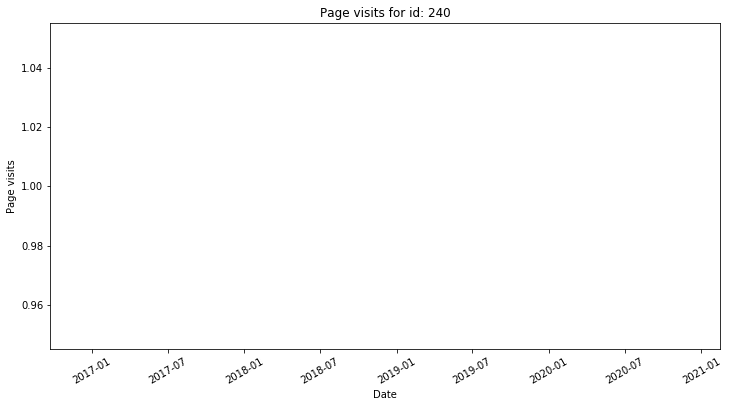

This is the page visit plot for: 37


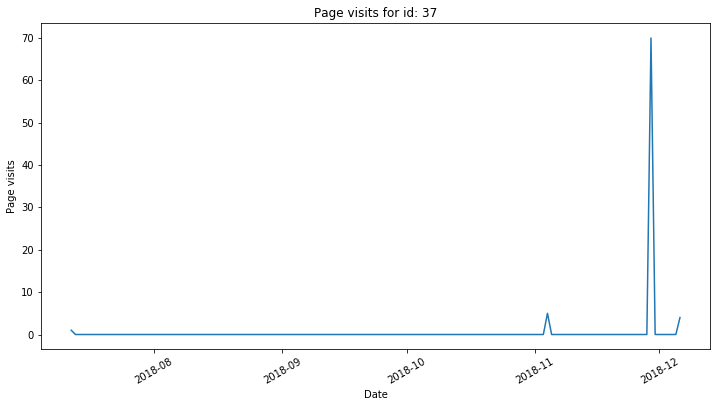

This is the page visit plot for: 248


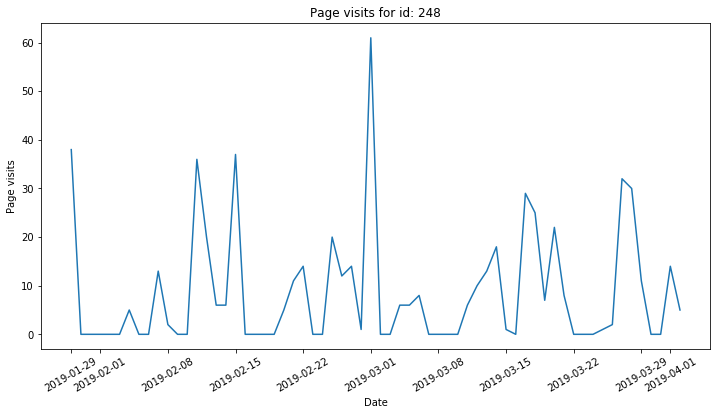

This is the page visit plot for: 76


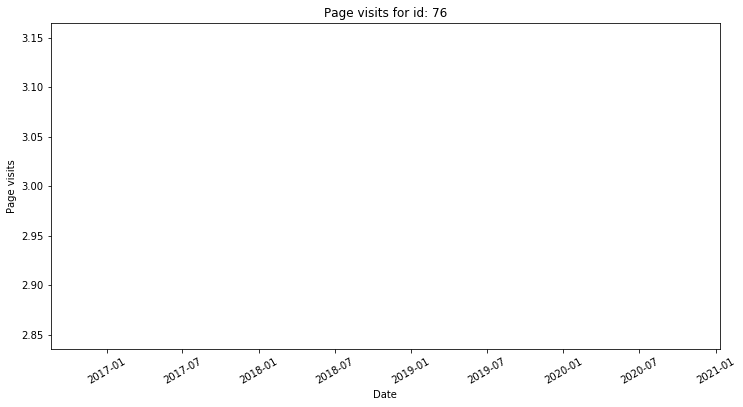

This is the page visit plot for: 68


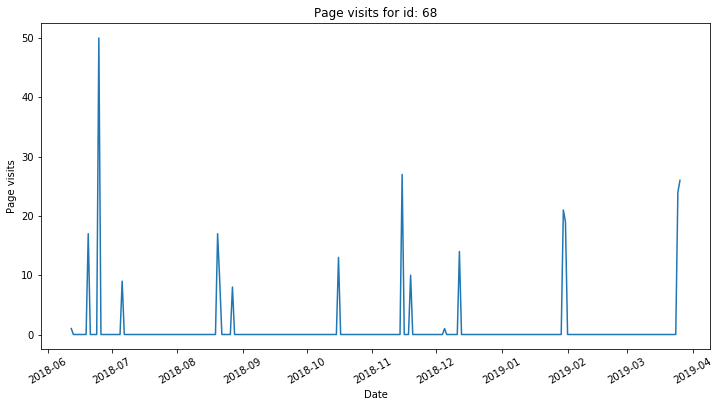

This is the page visit plot for: 179


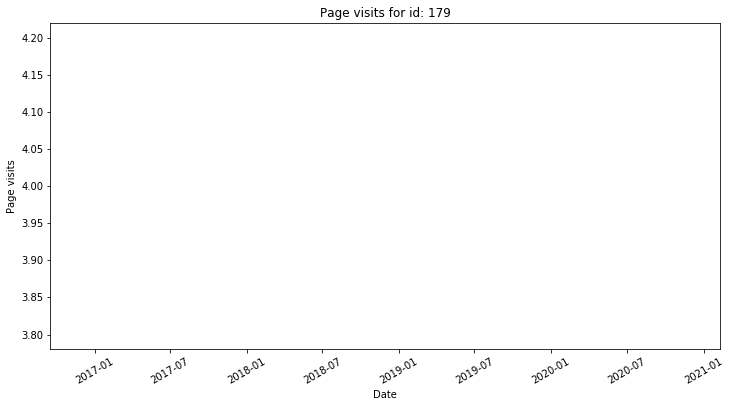

This is the page visit plot for: 90


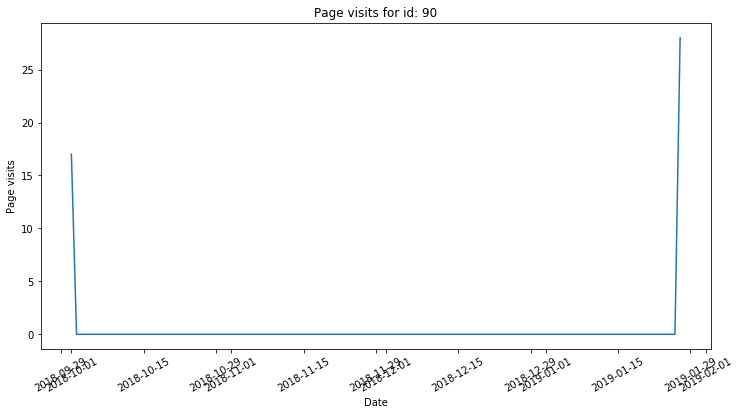

This is the page visit plot for: 102


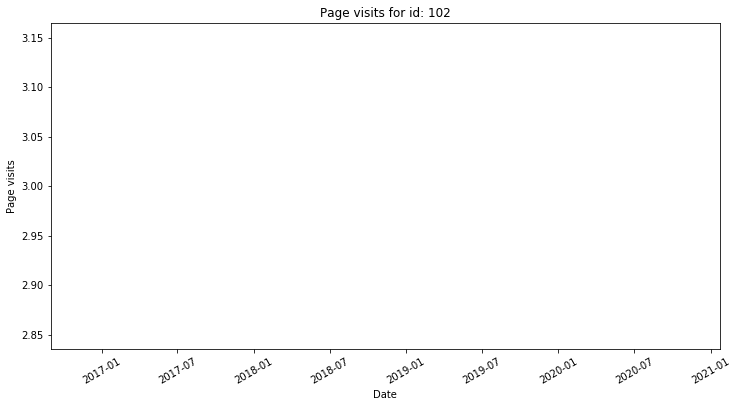

This is the page visit plot for: 101


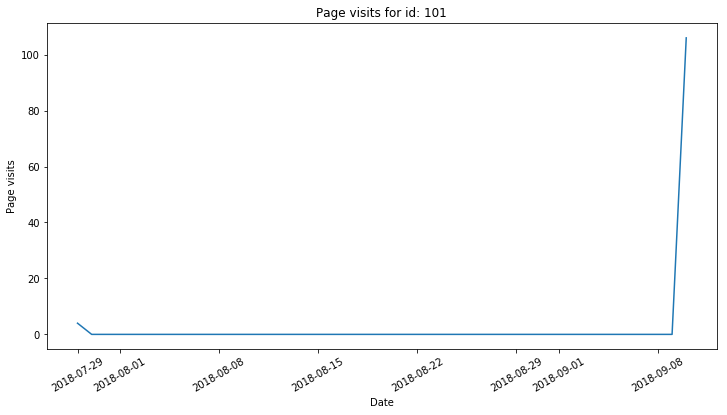

This is the page visit plot for: 106


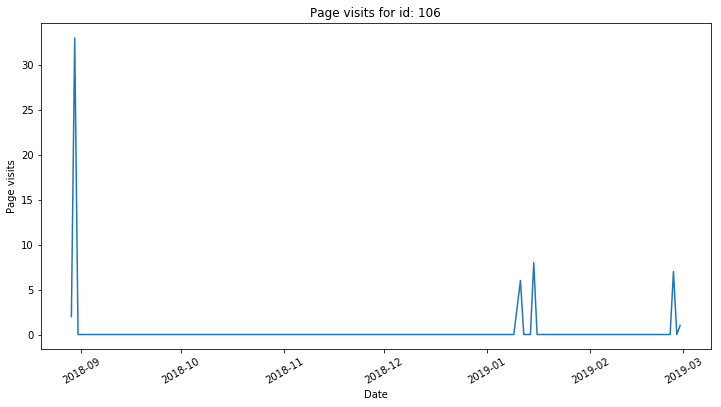

This is the page visit plot for: 139


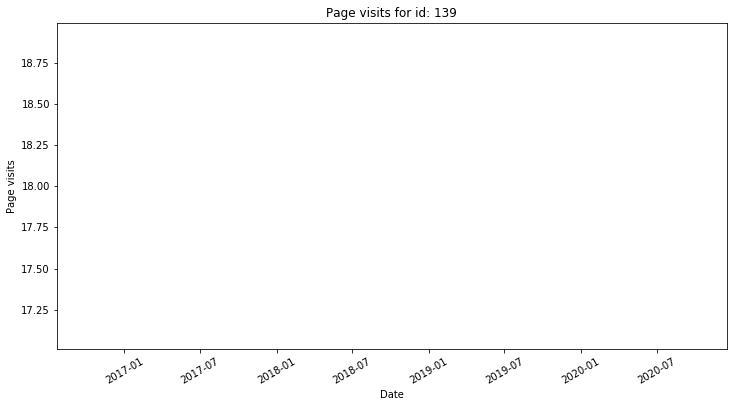

This is the page visit plot for: 171


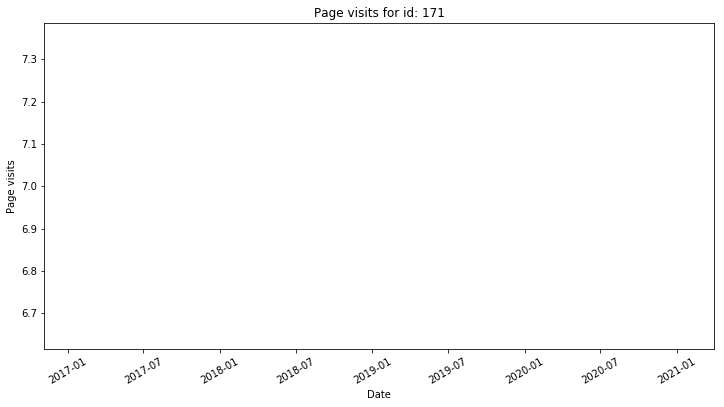

This is the page visit plot for: 103


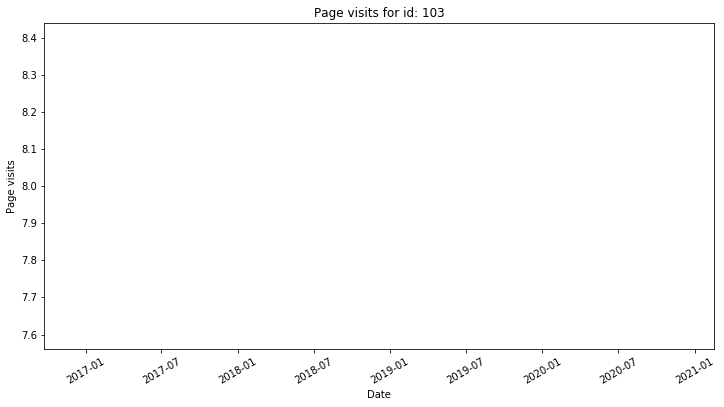

This is the page visit plot for: 70


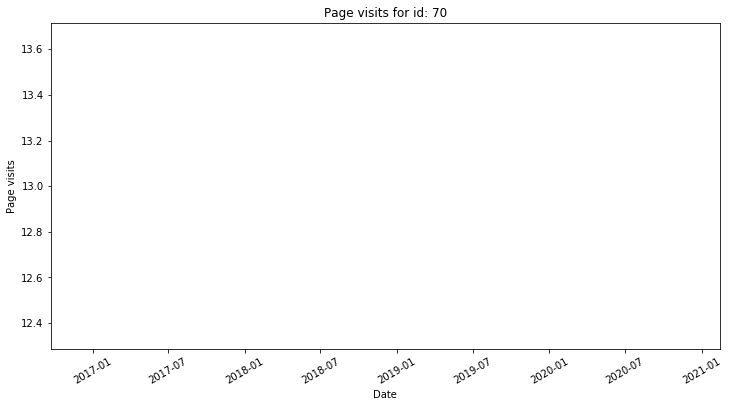

This is the page visit plot for: 112


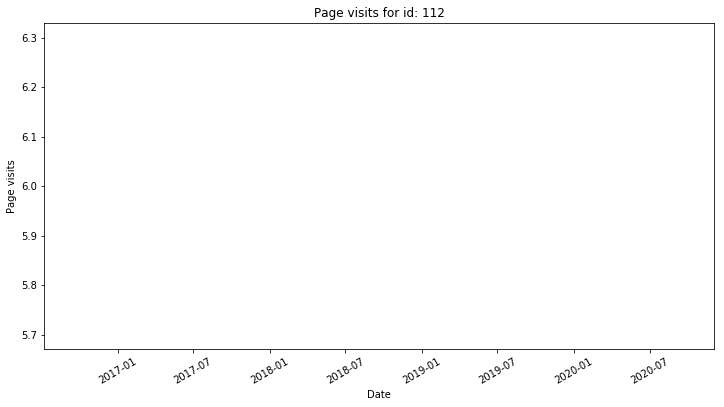

This is the page visit plot for: 84


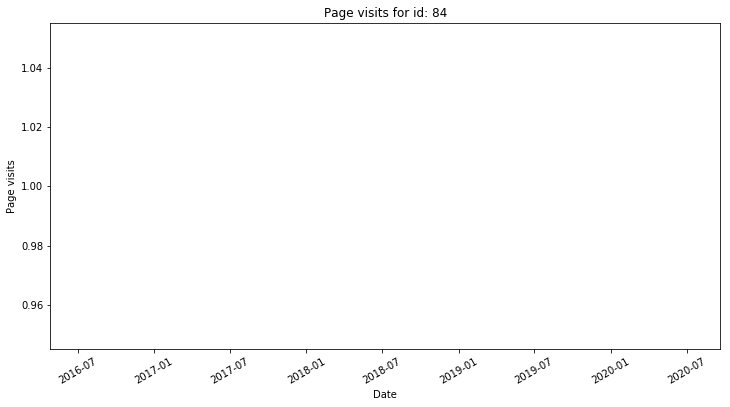

In [165]:
for id in df.individual_id.unique():
    print(f'This is the page visit plot for: {id}')
    indie = df[df.individual_id == f'{id}']
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=indie.resample('D')['page'].count())
    plt.xlabel('Date')
    plt.ylabel('Page visits')
    plt.xticks(rotation=30)
    plt.title(f'Page visits for id: {id}')
    plt.show()

In [184]:
indie_one = df[df.individual_id == '1']

In [205]:
ts_data = indie_one.resample('D')['page'].count()

In [207]:
# Calculating the short-window simple moving average
short_rolling = ts_data.rolling(window=14).mean()

# Calculating the long-window simple moving average
long_rolling = ts_data.rolling(window=30).mean()

Text(0, 0.5, 'Size (MB)')

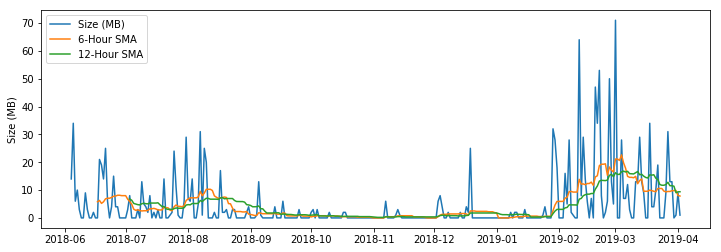

In [210]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(ts_data.index, 
        ts_data,
        label='Page visits')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)



In [224]:
# Using Pandas to calculate a 2 hour span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = ts_data.ewm(span=14, adjust=False).mean()
ema_short[0:3]

ema_long = ts_data.ewm(span=30, adjust=False).mean()
ema_long[0:3]

midband = ema_long[-1]
ub = midband + ema_long[-30:-1].std()*3
lb = midband - ema_long[-30:-1].std()*3

yhat = pd.DataFrame(dict(actual=ts_data))
yhat['moving_avg_forecast'] = midband

Text(0, 0.5, 'Size (MB)')

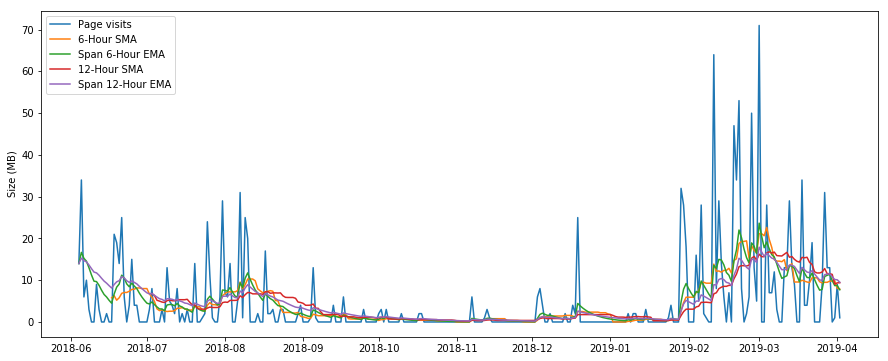

In [225]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(ts_data.index, 
        ts_data,
        label='Page visits')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')



In [226]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

In [227]:
yhat[yhat.pct_b > 1]

actual  moving_avg_forecast      error     pct_b
date_time                                                   
2018-06-05      34             9.510379  24.489621  2.851061
2018-06-18      21             9.510379  11.489621  1.603031
2018-06-19      19             9.510379   9.489621  1.411026
2018-06-21      25             9.510379  15.489621  1.987040
2018-06-25      15             9.510379   5.489621  1.027017
2018-07-25      24             9.510379  14.489621  1.891038
2018-07-31      29             9.510379  19.489621  2.371049
2018-08-07      31             9.510379  21.489621  2.563054
2018-08-09      25             9.510379  15.489621  1.987040
2018-08-10      20             9.510379  10.489621  1.507028
2018-08-17      17             9.510379   7.489621  1.219021
2018-12-19      25             9.510379  15.489621  1.987040
2019-01-29      32             9.510379  22.489621  2.659056
2019-01-30      28             9.510379  18.489621  2.275047
2019-01-31      18             9.510379   8.489621  1.315024
2019-02-04      16             9.510379   6.489621  1.123019
2019-02-06      28             9.510379  18.489621  2.275047
2019-02-11      64             9.510379  54.489621  5.731132
2019-02-13      29             9.510379  19.489621  2.371049
2019-02-19      47             9.510379  37.489621  4.099092
2019-02-20      34             9.510379  24.489621  2.851061
2019-02-21      53             9.510379  43.489621  4.675106
2019-02-26      50             9.510379  40.489621  4.387099
2019-03-01      71             9.510379  61.489621  6.403148
2019-03-04      28             9.510379  18.489621  2.275047
2019-03-13      29             9.510379  19.489621  2.371049
2019-03-18      34             9.510379  24.489621  2.851061
2019-03-22      19             9.510379   9.489621  1.411026
2019-03-27      31             9.510379  21.489621  2.563054

In [181]:
df[(df.ip == '97.105.19.61') & (df.days_gone > 30)]

date individual_id      time  \
date_time                                                
2018-07-09 10:23:54 2018-07-09            64  10:23:54   
2018-07-09 16:30:16 2018-07-09            64  16:30:16   
2018-07-09 16:54:22 2018-07-09            64  16:54:22   
2018-07-11 11:43:55 2018-07-11            64  11:43:55   
2018-07-10 10:20:27 2018-07-10            11  10:20:27   
2018-07-10 12:04:16 2018-07-10            61  12:04:16   
2018-07-11 09:43:09 2018-07-11            40  09:43:09   
2018-07-09 07:44:41 2018-07-09             1  07:44:41   
2018-07-11 16:31:19 2018-07-11            53  16:31:19   
2018-07-11 16:34:22 2018-07-11             1  16:34:22   
2018-07-11 16:31:23 2018-07-11            53  16:31:23   
2018-07-11 16:31:24 2018-07-11            53  16:31:24   
2018-07-03 07:52:13 2018-07-03             1  07:52:13   
2018-07-03 11:21:20 2018-07-03            11  11:21:20   
2018-07-10 12:04:05 2018-07-10            61  12:04:05   
2018-07-09 11:59:35 2018-07-09            11  11:59:35   
2018-07-09 12:03:04 2018-07-09            11  12:03:04   
2018-07-09 17:23:46 2018-07-09            11  17:23:46   
2018-07-09 10:40:05 2018-07-09            40  10:40:05   
2018-07-10 14:41:30 2018-07-10             1  14:41:30   
2018-07-11 14:24:10 2018-07-11             1  14:24:10   
2018-07-11 09:31:26 2018-07-11            40  09:31:26   
2018-07-12 10:11:52 2018-07-12            11  10:11:52   
2018-07-13 10:38:09 2018-07-13            26  10:38:09   
2018-07-13 14:53:30 2018-07-13            40  14:53:30   
2018-07-13 15:35:59 2018-07-13            40  15:35:59   
2018-07-09 17:23:50 2018-07-09            11  17:23:50   
2018-07-11 12:51:49 2018-07-11            40  12:51:49   
2018-07-02 13:48:18 2018-07-02             1  13:48:18   
2018-07-12 15:40:18 2018-07-12             1  15:40:18   
...                        ...           ...       ...   
2018-07-03 08:52:08 2018-07-03             1  08:52:08   
2018-07-03 09:04:15 2018-07-03             1  09:04:15   
2018-07-09 07:46:40 2018-07-09             1  07:46:40   
2018-07-09 14:12:14 2018-07-09            53  14:12:14   
2018-07-10 10:00:52 2018-07-10            64  10:00:52   
2018-07-10 10:03:25 2018-07-10            64  10:03:25   
2018-07-10 15:37:21 2018-07-10            64  15:37:21   
2018-07-11 10:00:29 2018-07-11            53  10:00:29   
2018-07-09 09:05:31 2018-07-09            64  09:05:31   
2018-07-09 09:37:28 2018-07-09            64  09:37:28   
2018-07-09 09:45:46 2018-07-09            64  09:45:46   
2018-07-09 16:23:25 2018-07-09            64  16:23:25   
2018-07-10 08:46:44 2018-07-10            53  08:46:44   
2018-07-09 11:05:37 2018-07-09            53  11:05:37   
2018-07-09 11:23:58 2018-07-09             1  11:23:58   
2018-07-09 09:05:29 2018-07-09            64  09:05:29   
2018-07-09 07:46:26 2018-07-09             1  07:46:26   
2018-07-10 10:00:50 2018-07-10            64  10:00:50   
2018-07-09 09:39:54 2018-07-09            64  09:39:54   
2018-07-09 09:39:56 2018-07-09            64  09:39:56   
2018-07-13 16:09:38 2018-07-13            26  16:09:38   
2018-07-13 16:30:55 2018-07-13            26  16:30:55   
2018-07-10 15:37:17 2018-07-10            64  15:37:17   
2018-07-09 09:39:55 2018-07-09            64  09:39:55   
2018-07-13 09:13:25 2018-07-13             1  09:13:25   
2018-07-09 14:03:45 2018-07-09            64  14:03:45   
2018-07-09 12:26:46 2018-07-09            53  12:26:46   
2018-07-09 14:03:49 2018-07-09            64  14:03:49   
2018-07-09 12:27:21 2018-07-09            53  12:27:21   
2018-07-09 15:00:17 2018-07-09            64  15:00:17   

                                                                  page cohort  \
date_time                                                                       
2018-07-09 10:23:54                           mkdocs/search_index.json      1   
2018-07-09 16:30:16                           mkdocs/search_index.json      1   
2018-07-09 16:54:22                           m

In [176]:
df[df.cohort == 0].ip.value_counts()

97.105.19.61       269
216.177.189.26     134
70.121.163.5        84
70.120.28.81        57
24.160.159.122      45
170.248.173.247     34
24.155.130.61       27
70.123.203.131      24
97.105.19.58        20
107.242.113.6       20
8.46.73.102         19
170.248.173.245     15
172.58.99.200       14
108.239.187.113     11
71.42.116.142       11
172.58.67.213       10
12.219.109.178       8
173.173.127.101      7
71.137.145.92        7
192.171.117.210      6
172.56.7.90          6
12.131.8.222         5
208.54.86.135        5
173.173.114.158      5
70.117.13.185        4
71.40.249.34         4
64.183.206.122       3
99.57.17.35          3
72.177.171.217       3
170.248.173.246      3
107.77.219.65        2
67.10.163.140        1
67.79.223.235        1
72.177.192.121       1
Name: ip, dtype: int64